In [1370]:
%matplotlib inline
import json
import folium
import pyproj
import math
import pandas as pd
from ggplot import *
from convertbng.util import convert_bng, convert_lonlat
import numpy

In [450]:
with open('packets.json','r') as f:
    data = json.load(f)

In [3]:
data

[{u'gateways': [{u'addr': u'70b3d54b13830000',
    u'alt': 91,
    u'lat': 51.52291,
    u'lon': -0.13228,
    u'rssi': -103,
    u'time': 1488895867.222774},
   {u'addr': u'70b3d54b12600000',
    u'alt': 47,
    u'lat': 51.5284,
    u'lon': -0.13808,
    u'rssi': -112,
    u'time': 1488895867.222774},
   {u'addr': u'70b3d54b110f0000',
    u'alt': 71,
    u'lat': 51.52876,
    u'lon': -0.12677,
    u'rssi': -100,
    u'time': 1488901053.21164},
   {u'addr': u'70b3d54b12600000',
    u'alt': 56,
    u'lat': 51.52841,
    u'lon': -0.13814,
    u'rssi': -99,
    u'time': 1488901053.211635}],
  u'payload': {u'alt': 60.477,
   u'hour': 14,
   u'i': 25741,
   u'lat': 51.536398,
   u'lon': -0.1352017,
   u'mins': 11,
   u'sats': 4,
   u'secs': 6}},
 {u'gateways': [{u'addr': u'70b3d54b12600000',
    u'alt': 53,
    u'lat': 51.52839,
    u'lon': -0.13811,
    u'rssi': -108,
    u'time': 1488895705.22184},
   {u'addr': u'70b3d54b110f0000',
    u'alt': 73,
    u'lat': 51.52878,
    u'lon': -0.1267

In [4]:
print "Number of packets: %d" % len(data)

Number of packets: 648


In [451]:
for packet in data:
    packet['gateways'] = [gw for gw in packet['gateways'] if gw['addr'] != '70b3d54b133f0000']

In [452]:
gateway_nums = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
for packet in data:
    gateway_nums[len(packet['gateways'])] += 1

print "Number of packets received by n gateways: "
print gateway_nums

Number of packets received by n gateways: 
{1: 310, 2: 168, 3: 111, 4: 46, 5: 13, 6: 0}


In [514]:
# Duplicates!?!?!?!

for packet in data:
    nums = {}
    for gw in packet['gateways']:
        if gw['addr'] not in nums:
            nums[gw['addr']] = 0
        nums[gw['addr']] += 1
    
    for key,vals in nums.iteritems():
        if vals > 1:
            print key
            print ""
            break

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b110f0000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b110f0000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b12600000

70b3d54b110f0000

70b3d54b12600000

70b3d54b110f0000



In [453]:
gateways = {}
for packet in data:
    for gw in packet['gateways']:
        gateways[gw['addr']]= {
                'lat': gw['lat'],
                'lon': gw['lon'],
                'alt': gw['alt']
                }
        
print "Number of unique gateways: %d" % len(gateways)


Number of unique gateways: 8


In [251]:
map_1 = folium.Map(location=[51.523668, -0.117931], tiles='Stamen Toner', zoom_start=13)

for addr,gw in gateways.iteritems():
    folium.Marker([gw['lat'], gw['lon']],
                  popup=addr,
                  icon=folium.Icon(color='blue',icon='wifi',prefix='fa')
                  ).add_to(map_1)

folium.Circle([gateways['70b3d54b13830000']['lat'], gateways['70b3d54b13830000']['lon']],
                    radius=750,
                    color='#0087c1',
                    fill_color='#0087c1',
                   ).add_to(map_1)


colours = {1: '#db3a00', 2: '#e07300', 3: '#9ce000', 4: '#4ee000', 5:'#10ff00'}

for packet in data:
    folium.CircleMarker([packet['payload']['lat'], packet['payload']['lon']],
                    radius=2,
                    color=colours[len(packet['gateways'])],
                    fill_color=colours[len(packet['gateways'])],
                   ).add_to(map_1)
    
map_1

## Conversion from ECEF to LLA and vice versa  (3D)

In [416]:
ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')

def llaToEcef(lat, lon, alt):
    x, y, z = pyproj.transform(lla, ecef, lon, lat, alt, radians=False)    
    return x, y, z

def EcefToLla(x, y, z):
    lon, lat, alt = pyproj.transform(ecef, lla, x, y, z, radians=False) 
    return lon, lat, alt

def distance3D(x1, y1, z1, x2, y2, z2):
    return math.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)

def distance2D(x1, y1, x2, y2):
    return math.sqrt((x1-x2)**2 + (y1-y2)**2)

## RSSI vs Distance

In [68]:
rssi_distance = []
for packet in data:
    #x1,y1,z1 = llaToEcef(packet['payload']['lat'], packet['payload']['lon'], packet['payload']['alt'])
    
    x1,y1 = convert_bng(packet['payload']['lon'], packet['payload']['lat'])

    for gw in packet['gateways']:
        #x2,y2,z2 = llaToEcef(gw['lat'], gw['lon'], gw['alt'])
        
        x2,y2 = convert_bng(gw['lon'], gw['lat'])
        
        #d = distance(x1, y1, z1, x2, y2, z2)
        d = math.sqrt((x1[0]-x2[0])**2 + (y1[0]-y2[0])**2)
        rssi_distance.append((gw['addr'],gw['rssi'],d))    

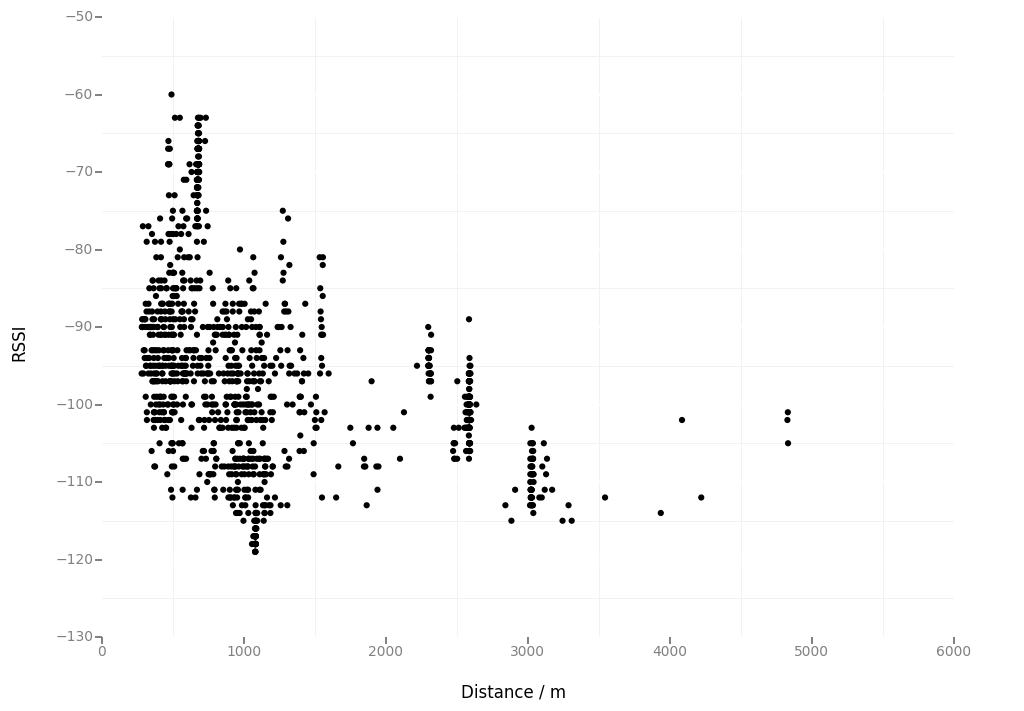

<ggplot: (331179561)>

In [69]:
rssi_distance = pd.DataFrame(rssi_distance, columns=['Gateway', 'RSSI', 'Distance'])
p = ggplot(aes(x='Distance', y='RSSI'), data=rssi_distance) #color='Gateway'
p + geom_point() + xlab("Distance / m") + theme_bw()

## TDOA

In [308]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

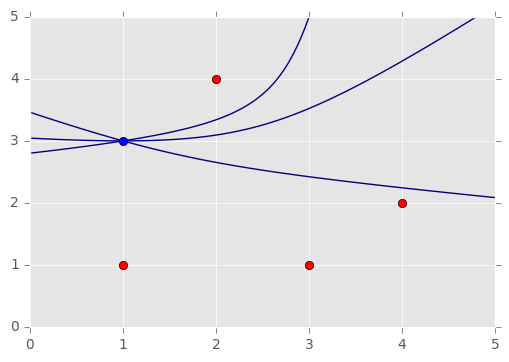

In [1705]:
xi = 1
yi = 1
xj = 4
yj = 2

xk = 2
yk = 4

xl = 3
yl = 1

d = 0


x = np.linspace(0, 5, 400)
y = np.linspace(0, 5, 400)
x, y = np.meshgrid(x, y)

plt.style.use('ggplot')

plt.axhline(0, alpha=.1)
plt.axvline(0, alpha=.1)

plt.contour(x, y, ( np.sqrt((x-xi)**2 + (y-yi)**2) - np.sqrt((x-xk)**2 + (y-yk)**2) ), [2-np.sqrt(2)])
plt.contour(x, y, ( np.sqrt((x-xj)**2 + (y-yj)**2) - np.sqrt((x-xk)**2 + (y-yk)**2) ), [np.sqrt(10)-np.sqrt(2)])


plt.plot([xi,xj,xk], [yi,yj,yk], 'or')

plt.plot([xl], [yl], 'or')
plt.contour(x, y, ( np.sqrt((x-xl)**2 + (y-yl)**2) - np.sqrt((x-xk)**2 + (y-yk)**2) ), [np.sqrt(8)-np.sqrt(2)])

plt.plot(1, 3, 'ob')

plt.show()
    



In [1528]:
def plotTDOA(D,A=None,B=None):
    x = np.linspace(528000, 532000, 1000)
    y = np.linspace(180000, 184000, 1000)
    x, y = np.meshgrid(x, y)
    
    for i in range(1,len(D),1):
        plt.contour(x, y, ( np.sqrt((x-D[i,0])**2 + (y-D[i,1])**2) - np.sqrt((x-D[0,0])**2 + (y-D[0,1])**2) ), [D[i,2]])

    plt.plot(D[:,0], D[:,1], 'or')
    if A is not None:
        plt.plot(A[0], A[1], 'ob')
    if B is not None:
        plt.plot(B[0], B[1], 'og')        
    plt.show()

In [85]:
import scipy

In [417]:
C=299792458.0

def deltaD(TOAi, TOAj):
    TDOA = TOAi - TOAj
    print TDOA
    return C*TDOA
    

In [84]:
deltaD(1,1.000001)

-9.99999999918e-07


-299.7924579753371

In [273]:
def TDOAs_2D(gateways):
    tmp = []
    for gw in gateways:
        x,y = convert_bng(gw['lon'], gw['lat'])
        tmp.append(x+y+[gw['time']])
    
    D = scipy.array(tmp)
    D = D[D[:,2].argsort()]
    D = D[-3:,:]

    for i in reversed(range(len(D[:,2]))):
        D[i,2] -= D[0,2]
        D[i,2] *= C
    return scipy.matrix(D)

3
[[ 530787.952       180896.81             0.        ]
 [ 529198.826       181926.615          857.71310234]
 [ 529664.249       182104.268         1215.09356165]]


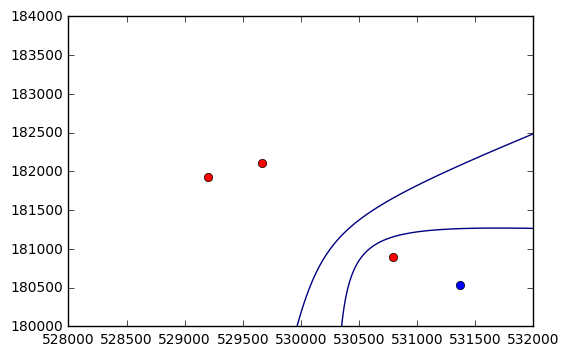

In [415]:
i = 632
D = TDOAs_2D(data[i]['gateways'])
print len(D)
print D
A = convert_bng(data[i]['payload']['lon'], data[i]['payload']['lat'])
plotTDOA(D,A)



In [843]:
def Chan_for3(D):
    P = D[1:3,0:2] - D[0,0:2]
    A = -P.I
    
    R = D[1:3,2]
    R_sq = scipy.matrix(R.A * R.A)
    
    K = scipy.zeros((3,1))
    M = D[:,0:2]
    for n in range(3):
        K[n] = M[n] * M[n].T
    
    B = (R_sq - K[1:4] + K[0]) / 2
    
    # T = E.R0 + F
    E = A*R
    F = A*B
    
    # Find R0
    a = 1 - (E.T * E)
    b = 2 * (M[0] * E - F.T * E)
    c = 2 * (M[0] * F) - F.T * F - K[0]
    
    discr = b*b - 4*a*c
    res = []
    if discr >= 0:
        h = scipy.sqrt(discr)
        for sign in [-1,1]:
            R0 = (sign*h-b)/(2*a)
            if R0 >= 0:
                T = E*R0 + F
                #print T
                res.append((T.A.squeeze(), R0))
        
    return res

In [842]:
k = [2, 2, 0]
j = [4, 2, np.sqrt(10)-np.sqrt(2)]
i = [1, 1, 2-np.sqrt(2)]
test = scipy.matrix([k, j, i])

Chan_for3(test)

[[ 1.]
 [ 3.]]
[[ 1.84832857]
 [ 1.58311176]]


[(array([ 1.,  3.]), matrix([[ 1.41421356]])),
 (array([ 1.84832857,  1.58311176]), matrix([[ 0.44362149]]))]

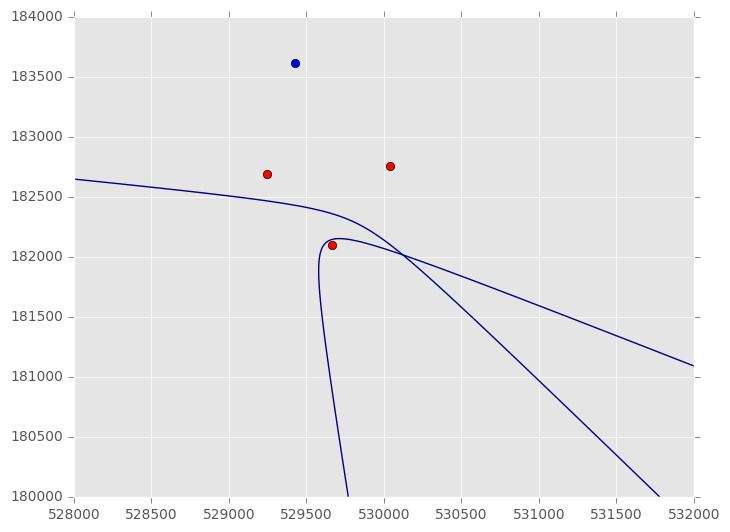

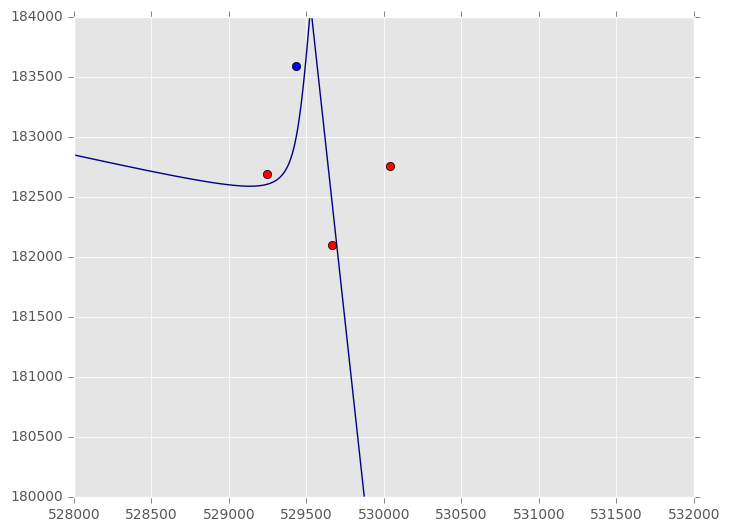

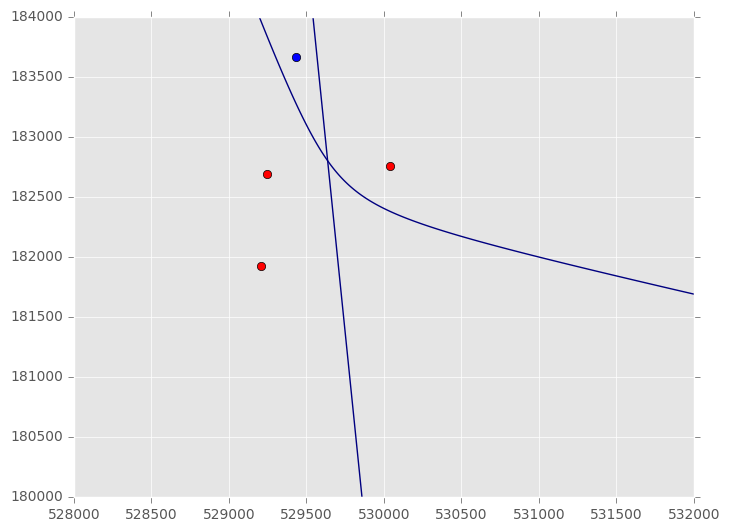

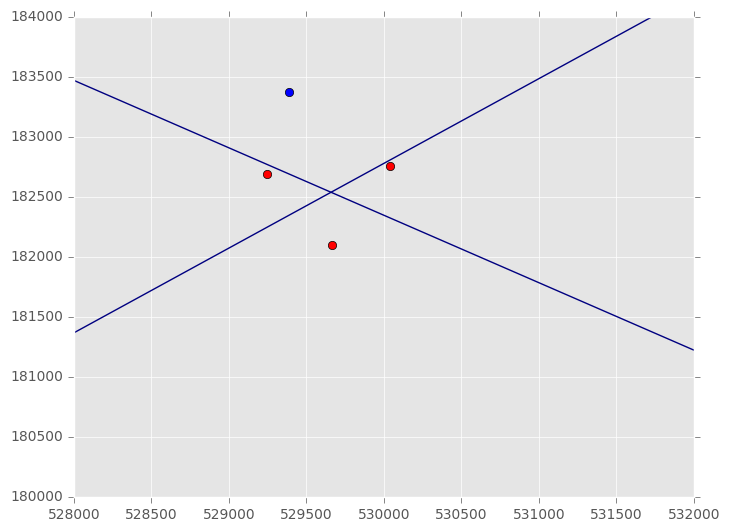

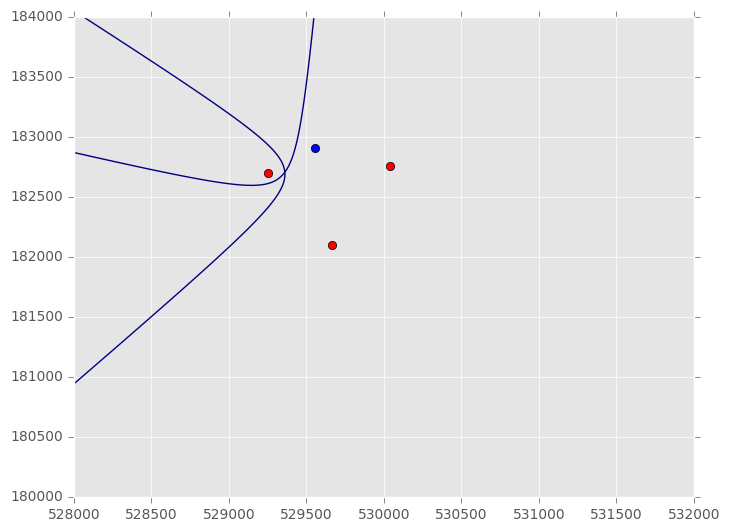

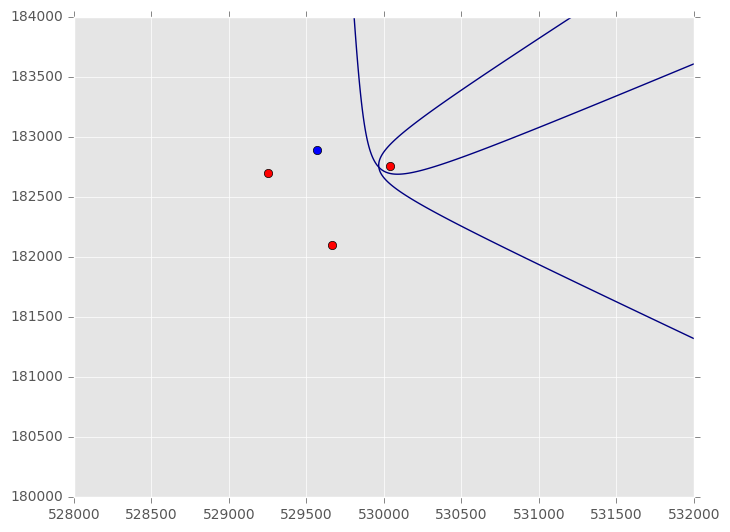

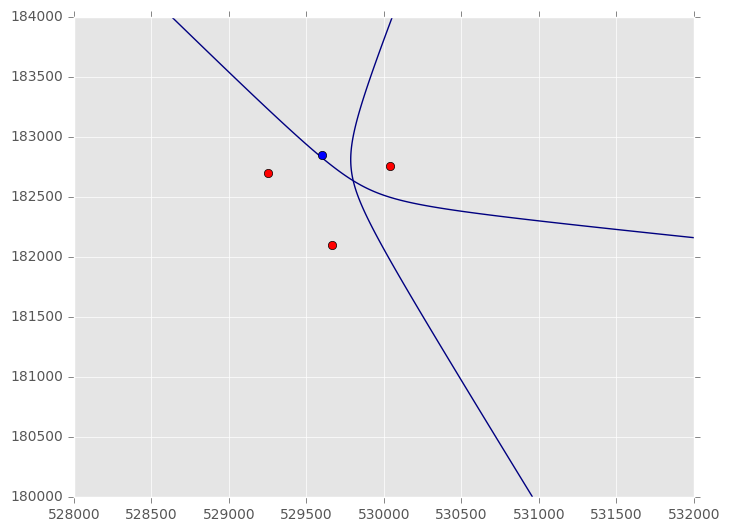

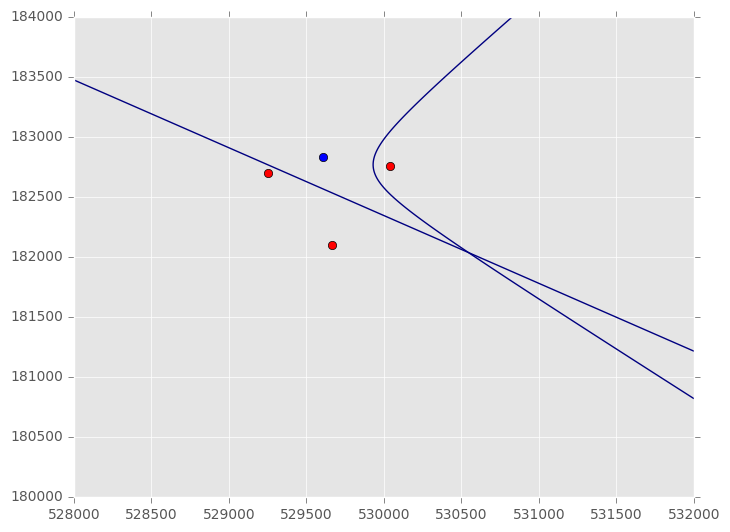

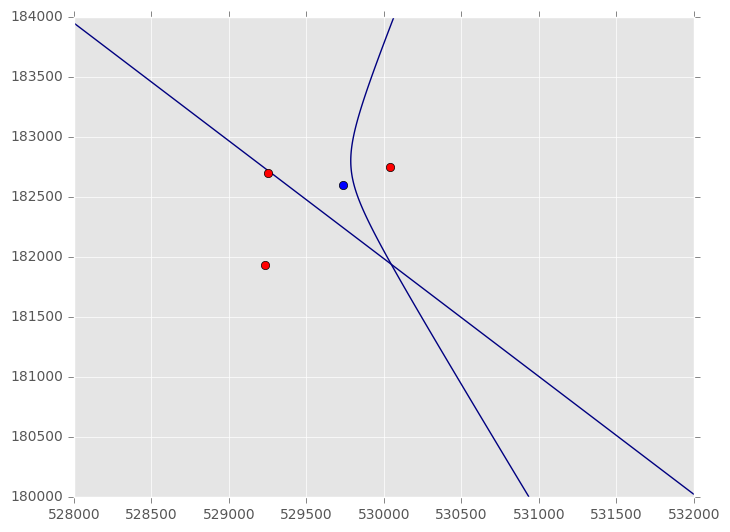

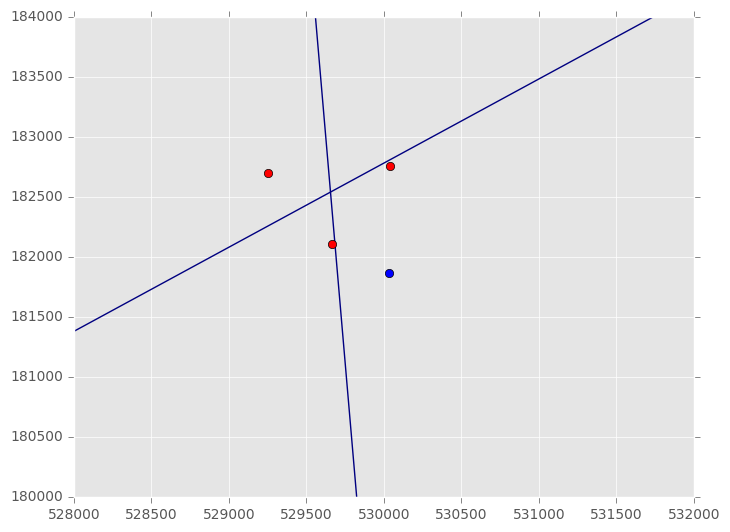

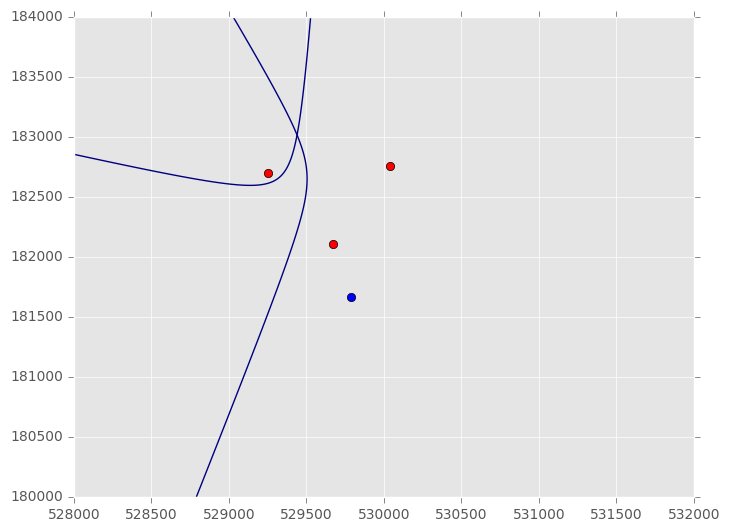

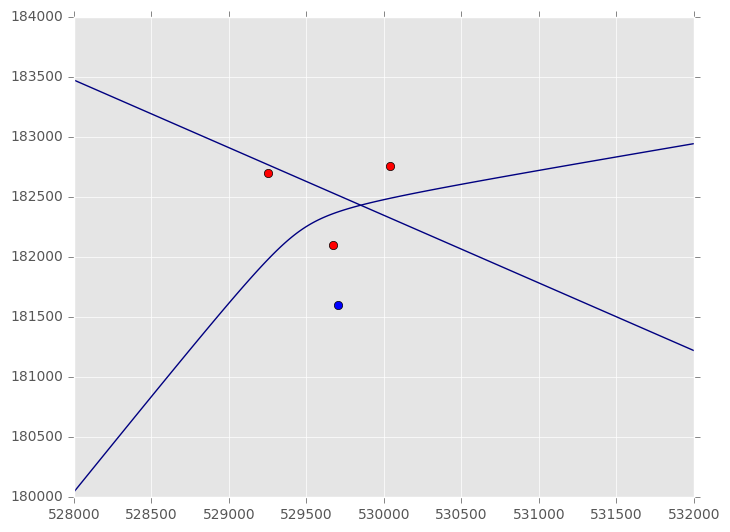

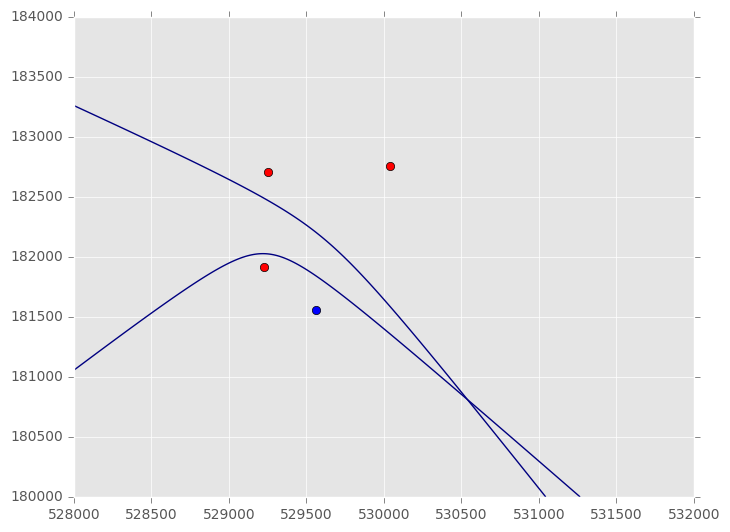

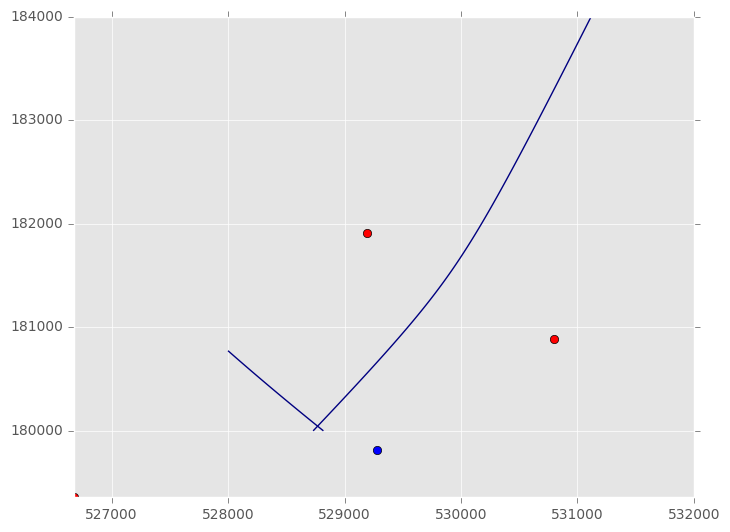

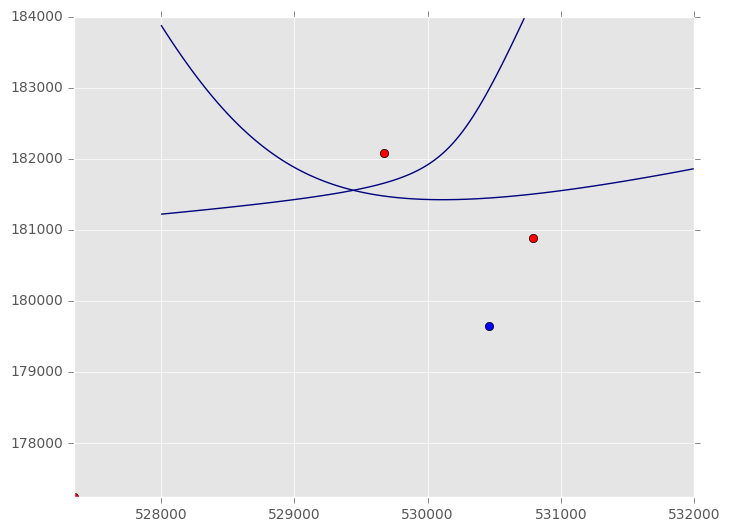

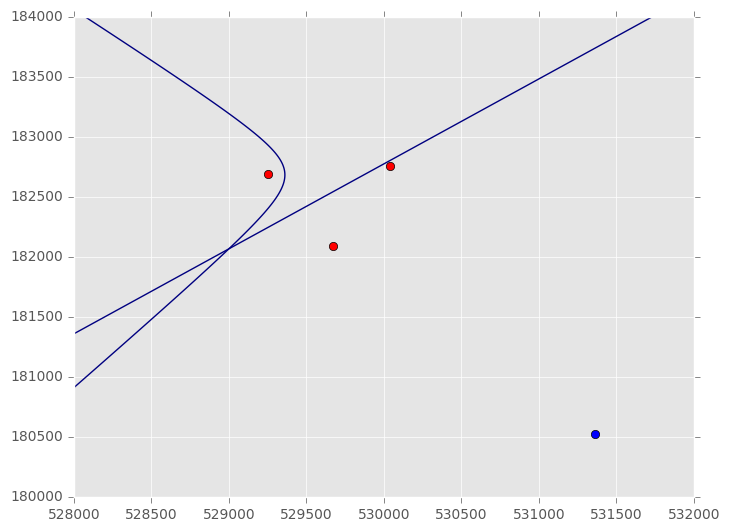

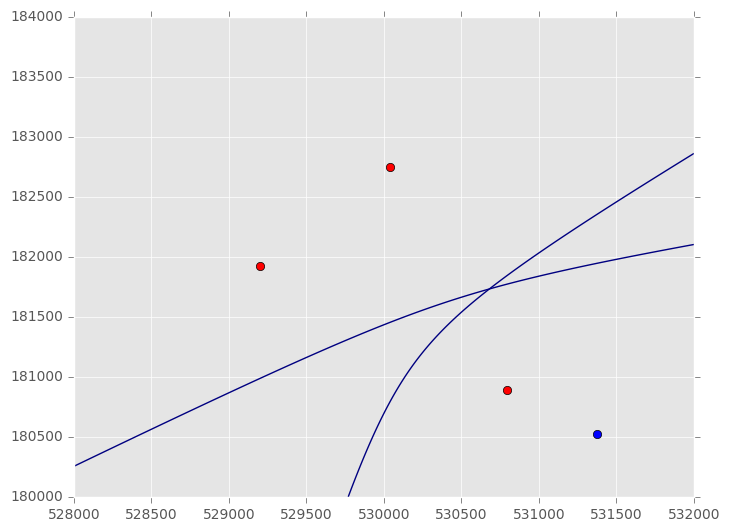

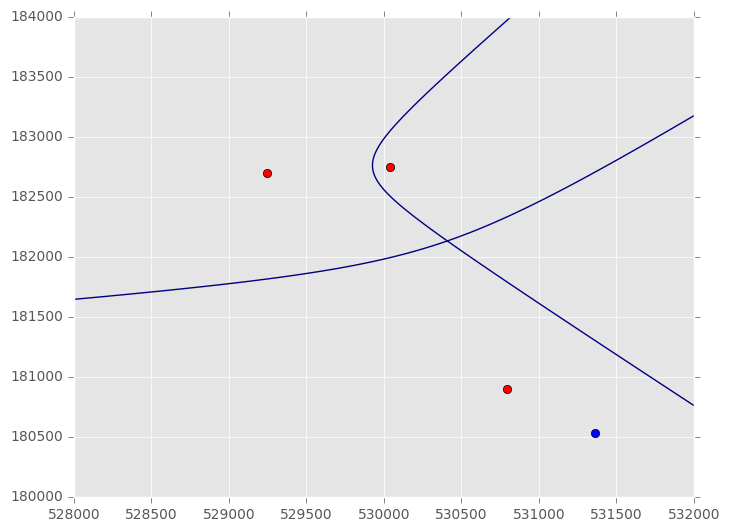

In [939]:
errors_no_offsets = []
for i,packet in enumerate(data):
    if len(packet['gateways']) < 3:
        continue
    D = TDOAs_2D(packet['gateways'])
    if D is not False:
        res = Chan_for3(D)
        if res:
            A = convert_bng(packet['payload']['lon'], packet['payload']['lat'])
            #d=[]
            #for row in D:
            #    d.append(distance2D(A[0][0],A[1][0],row[0,0],row[0,1]))
            #for item in d:
            #    print item - d[0]
            x = res[0][0][0]
            y = res[0][0][1]
            error = distance2D(x,y,A[0][0],A[1][0])
            errors_no_offsets.append(error)
            plotTDOA(D,A)
            print ""

In [1011]:
print np.mean(errors_no_offsets)
print np.median(errors_no_offsets)
print np.std(errors_no_offsets)
print len(errors_no_offsets)/170.0
len(errors_no_offsets)

1112.43896209
882.238834696
670.906051284
0.105882352941


18

0b3d54b12600000 is about 5000 seconds out of sync.


Frequencies better for indoor? Indoor positioning


# Offsets

Gateway Pair Offsets, Packets with 2+ gateways

In [1333]:
pairs = {}
pairslist = []
bigoffsets = {}
bigoffsetpairs = set()

for packet in data:
    if len(packet['gateways']) < 2:
        continue
    
    x,y = convert_bng(packet['payload']['lon'], packet['payload']['lat'])
    
    gateways = {}
    for gw in packet['gateways']:
        gx,gy = convert_bng(gw['lon'], gw['lat'])
        real_distance = distance2D(x[0],y[0],gx[0],gy[0])
        real_timetaken = real_distance/C
        
        if gw['addr'] in gateways:
            if gateways[gw['addr']]['time_rcvd'] < gw['time']:
                continue
                
        gateways[gw['addr']] = {
                'addr': gw['addr'],
                'real_timetaken': real_timetaken,
                'time_rcvd': gw['time']
            }
        
    
    
    for gw1 in gateways.values():
        for gw2 in gateways.values():
            if gw1 is gw2:
                continue
            real_timediff = gw1['real_timetaken'] - gw2['real_timetaken']
            esti_timediff = gw1['time_rcvd'] - gw2['time_rcvd']
            if not gw1['addr'] in pairs:
                pairs[gw1['addr']] = {}
            if not gw2['addr'] in pairs[gw1['addr']]:
                pairs[gw1['addr']][gw2['addr']] = []
            pairs[gw1['addr']][gw2['addr']].append({
                    'addr1': gw1['addr'],
                    'addr2': gw2['addr'],
                    'real_timediff': real_timediff,
                    'esti_timediff': esti_timediff,
                    'offset': real_timediff - esti_timediff
                })
            
            if abs(real_timediff - esti_timediff) > 0.05:
                bigoffsetpairs.add((gw1['addr'], gw2['addr']))
                if gw1['addr'] not in bigoffsets:
                    bigoffsets[gw1['addr']] = 0
                if gw2['addr'] not in bigoffsets:
                    bigoffsets[gw2['addr']] = 0
                bigoffsets[gw1['addr']] += 1
                bigoffsets[gw2['addr']] += 1
            
            pairslist.append({
                    'addr': "%s / %s" % (gw1['addr'], gw2['addr']),
                    'addr1': gw1['addr'],
                    'addr2': gw2['addr'],
                    'real_timediff': real_timediff,
                    'esti_timediff': esti_timediff,
                    'offset': real_timediff - esti_timediff
                })

In [561]:
print bigoffsets

{u'70b3d54b13830000': 96, u'70b3d54b12600000': 146, u'70b3d54b13410000': 306, u'70b3d54b11440000': 122, u'70b3d54b12330000': 2, u'70b3d54b109e0000': 12, u'70b3d54b110f0000': 152}


In [568]:
counts = {}
for item in pairslist:
    if item['addr'] not in counts:
        counts[item['addr']] = {'big': 0, 'total': 0}
    counts[item['addr']]['total'] += 1
    if abs(item['offset']) > 1:
        counts[item['addr']]['big'] += 1
cnts = pd.DataFrame(counts).transpose()
cnts[ cnts['big'] != 0 ]#[ cnts['big'] != cnts['total'] ]


big  total
70b3d54b109e0000 / 70b3d54b12600000    2     17
70b3d54b110f0000 / 70b3d54b12600000   27    141
70b3d54b110f0000 / 70b3d54b13830000    8    112
70b3d54b12600000 / 70b3d54b109e0000    2     17
70b3d54b12600000 / 70b3d54b110f0000   27    141
70b3d54b12600000 / 70b3d54b13830000   19    124
70b3d54b13830000 / 70b3d54b110f0000    8    112
70b3d54b13830000 / 70b3d54b12600000   19    124

In [ ]:
uniquepairslist = []
for pair in pairslist:
    if pair['addr1']

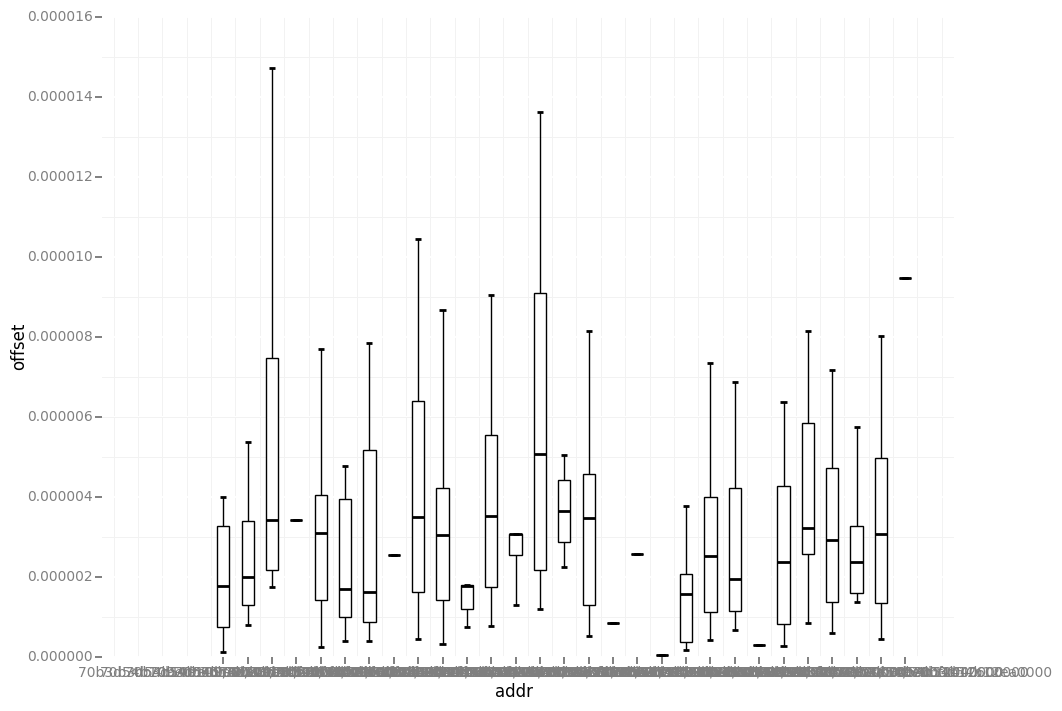

<ggplot: (392323237)>


In [949]:


d = pd.DataFrame(pairslist)
d2 = d[(d['offset'] < 0.05) & (d['offset'] > -0.05)]
p = ggplot(aes(x='addr', y='offset'), data=d2) #color='Gateway'
g = p + geom_boxplot(outliers=False, notch=True) + theme_bw()
print g

In [950]:
print d2['offset'].abs().mean()

3.58480271859e-06


3.58480271859e-06
2.82451824597e-06


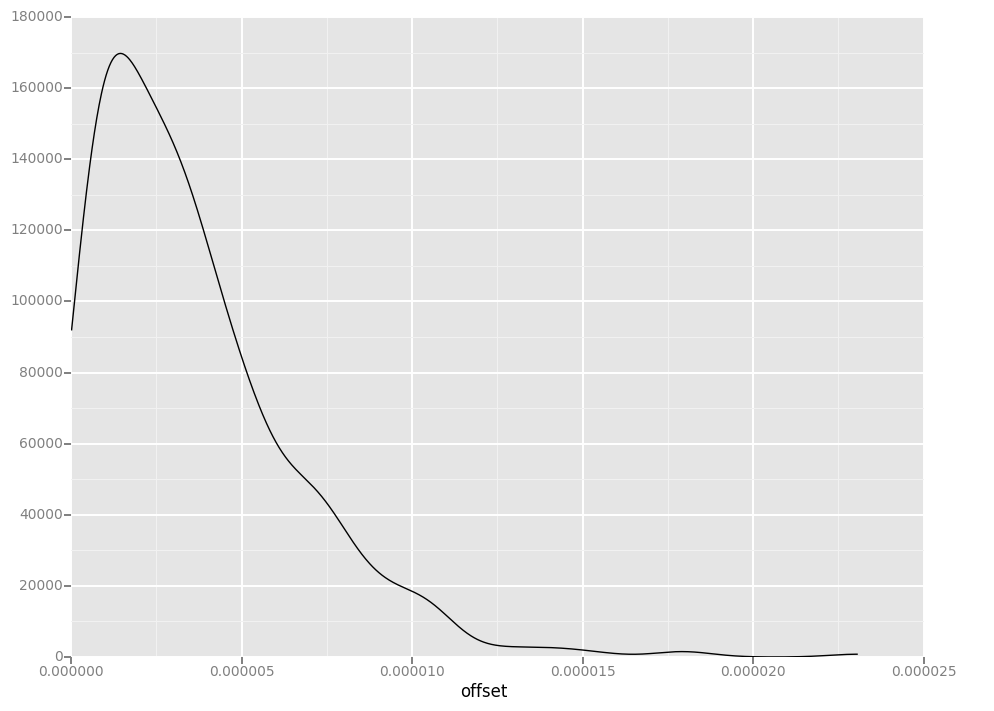

<ggplot: (305103393)>

In [951]:
d = pd.DataFrame(pairslist)
d2 = d[(d['offset'] < 0.05) & (d['offset'] > 0.0)]
print d2['offset'].mean()
print d2['offset'].median()
ggplot(aes(x='offset'), data=d2) + stat_density()

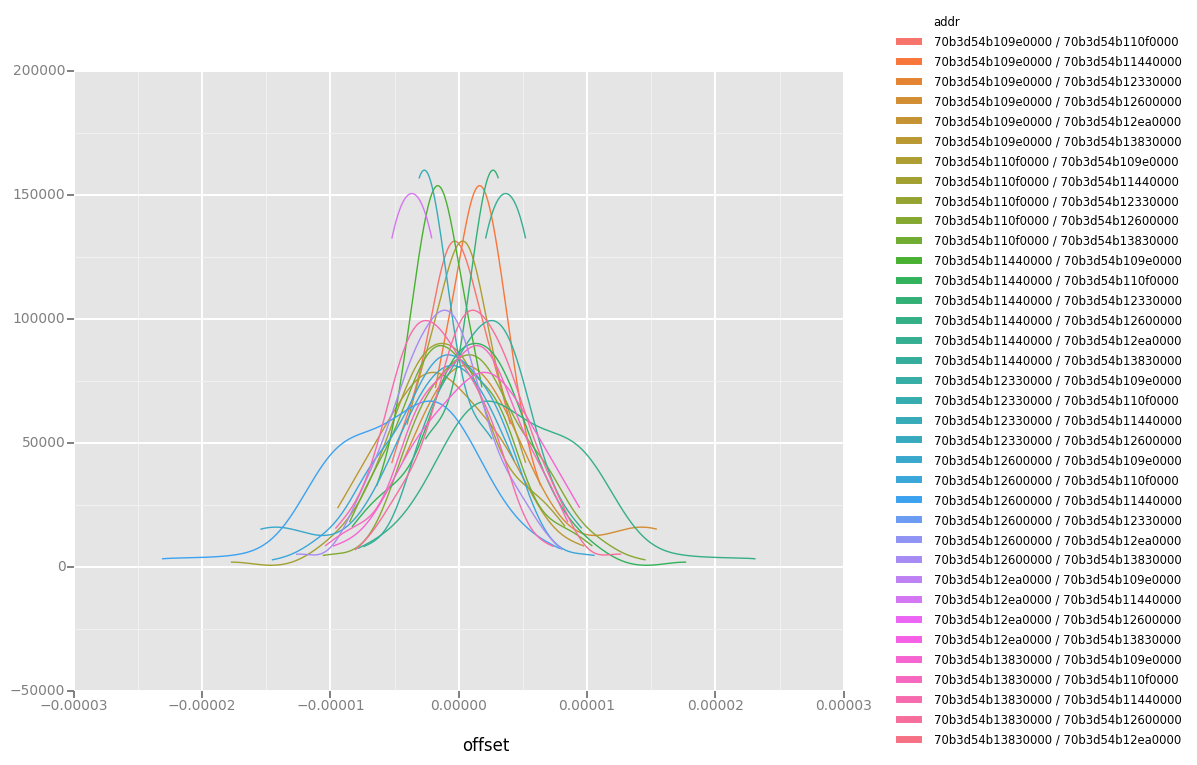

<ggplot: (296889273)>


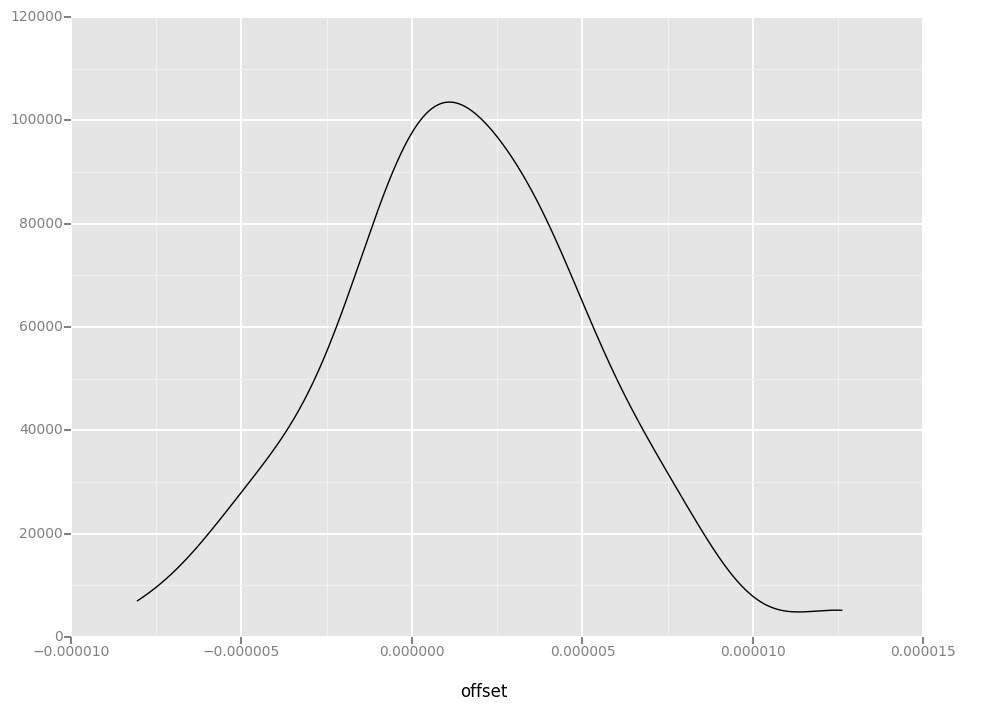

<ggplot: (307361985)>


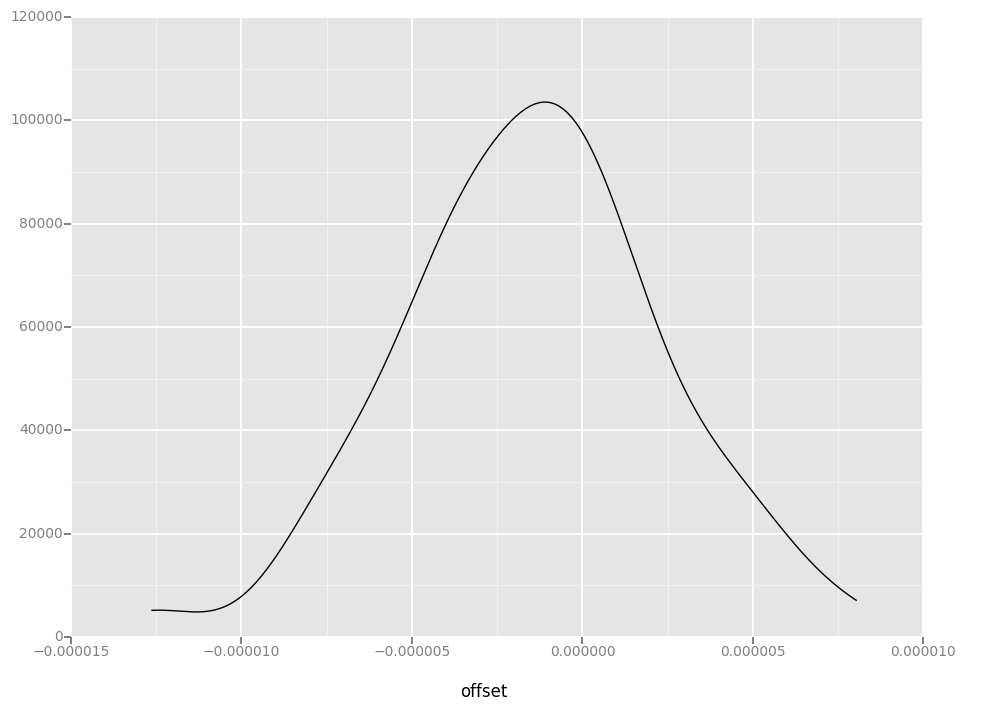

<ggplot: (313538001)>


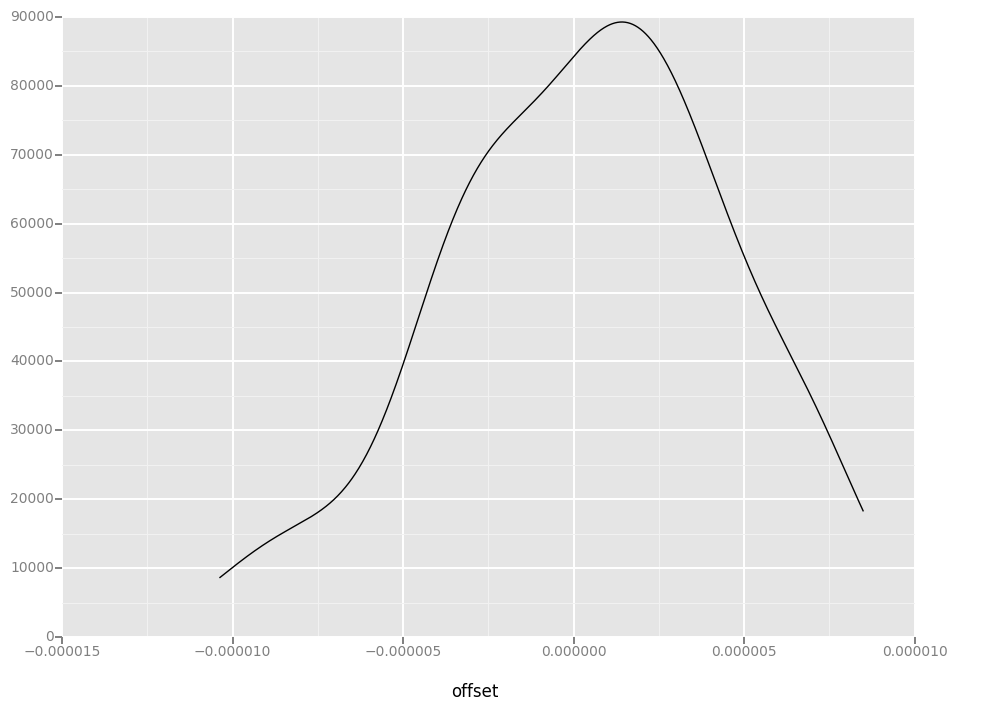

<ggplot: (307301865)>


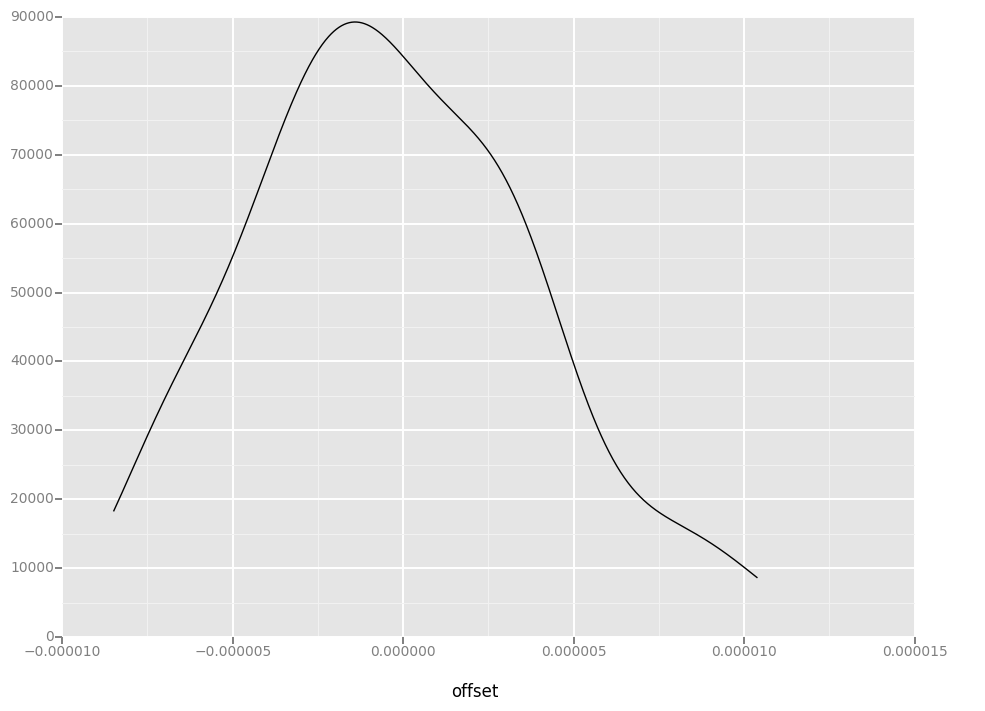

<ggplot: (307307409)>


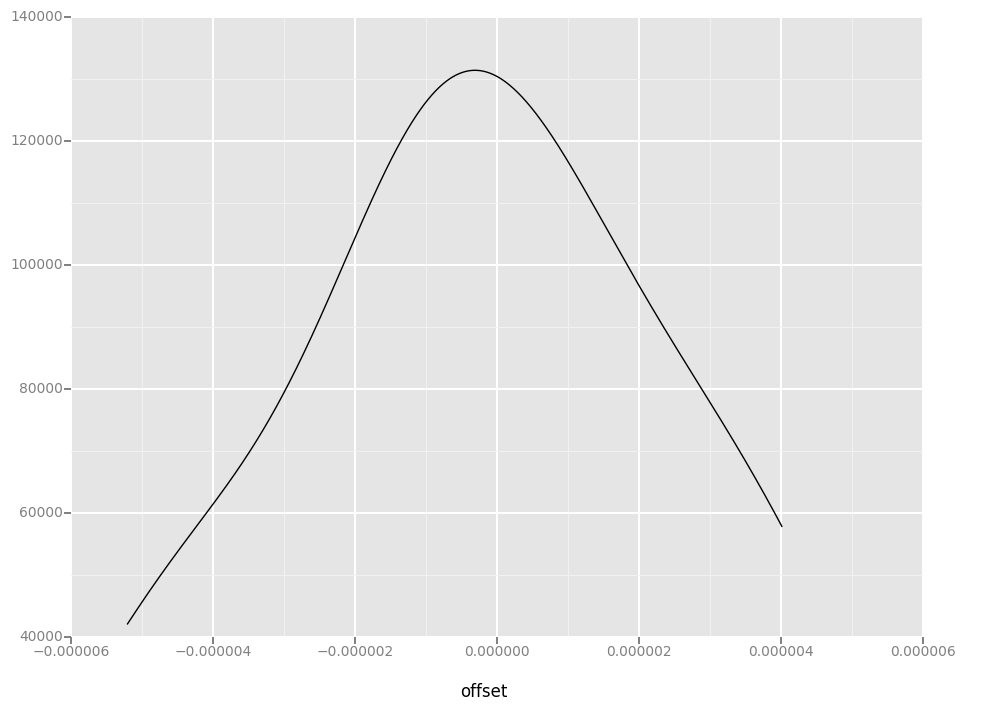

<ggplot: (309334105)>


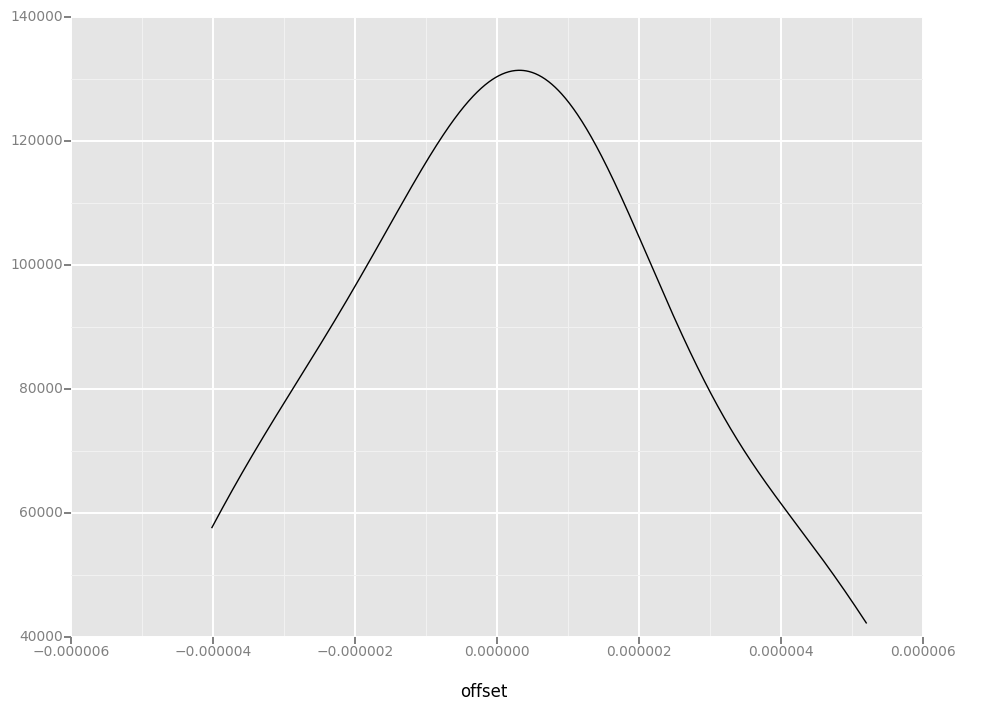

<ggplot: (313000405)>


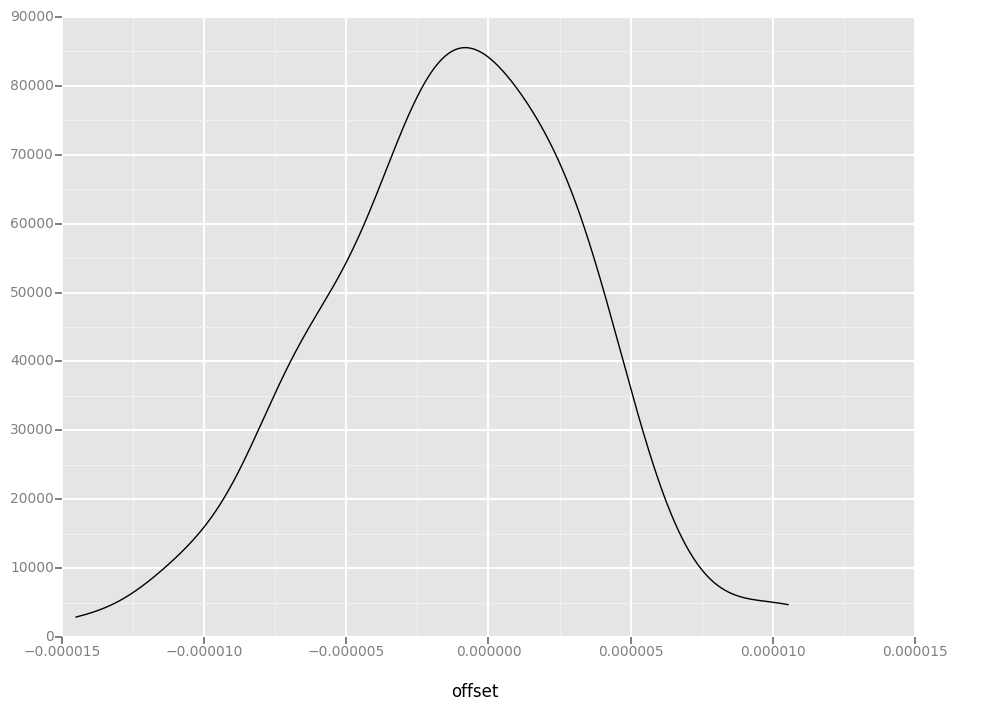

<ggplot: (308657009)>


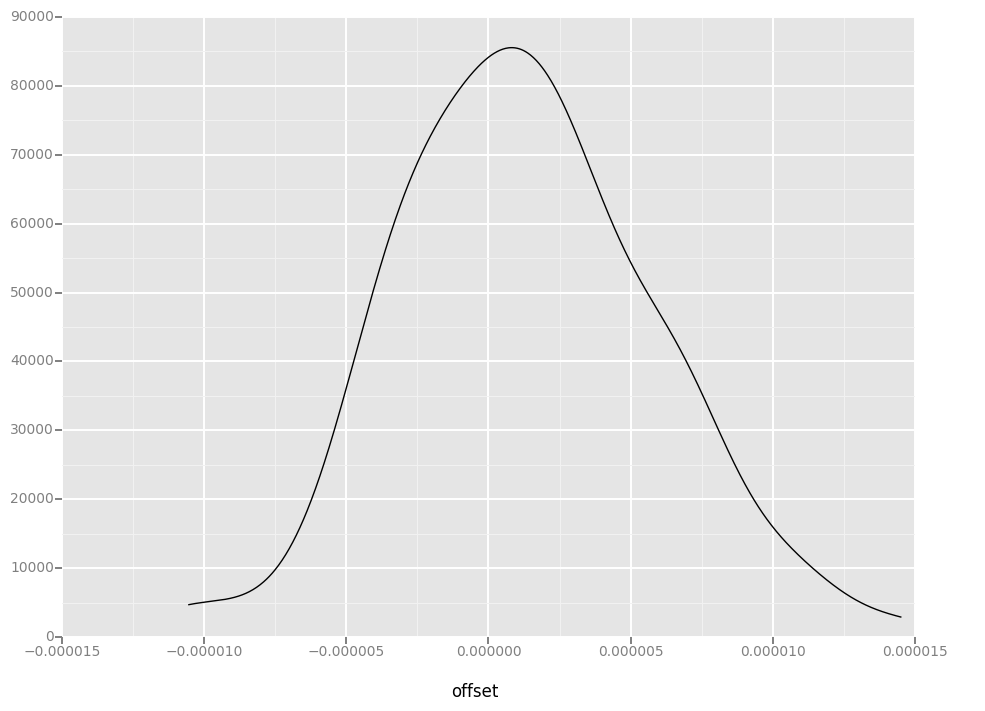

<ggplot: (310540121)>


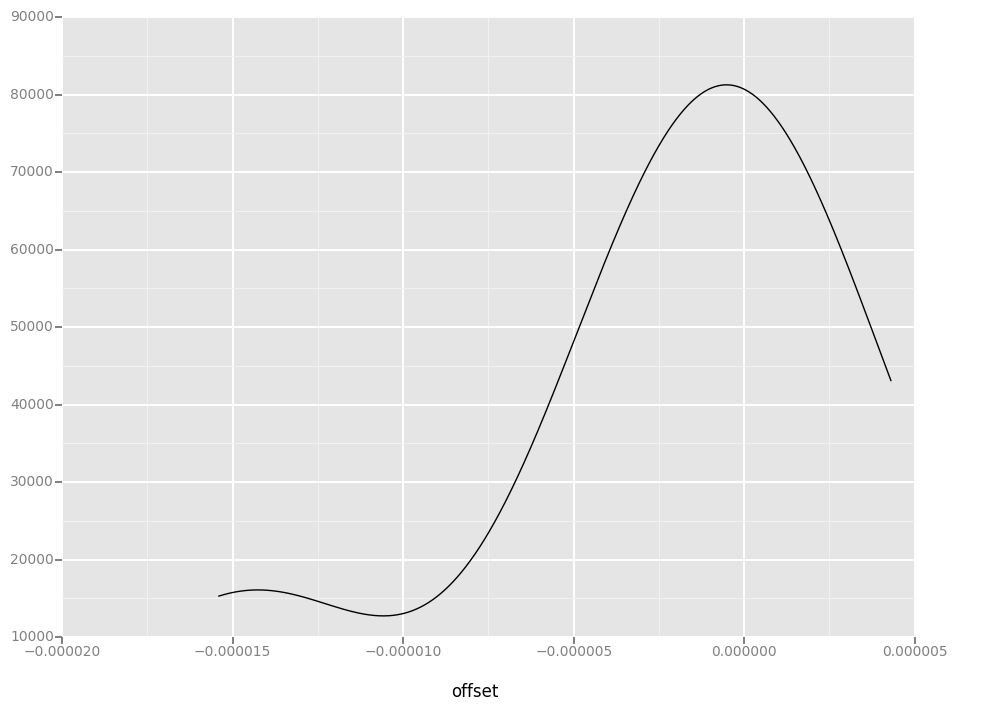

<ggplot: (307176029)>


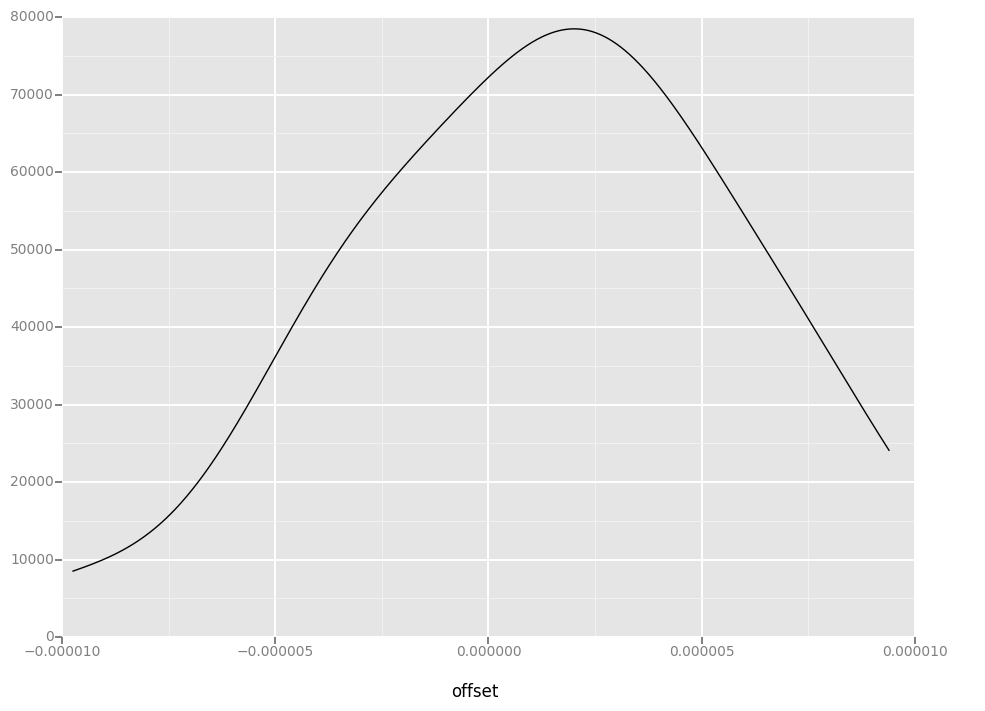

<ggplot: (307337961)>


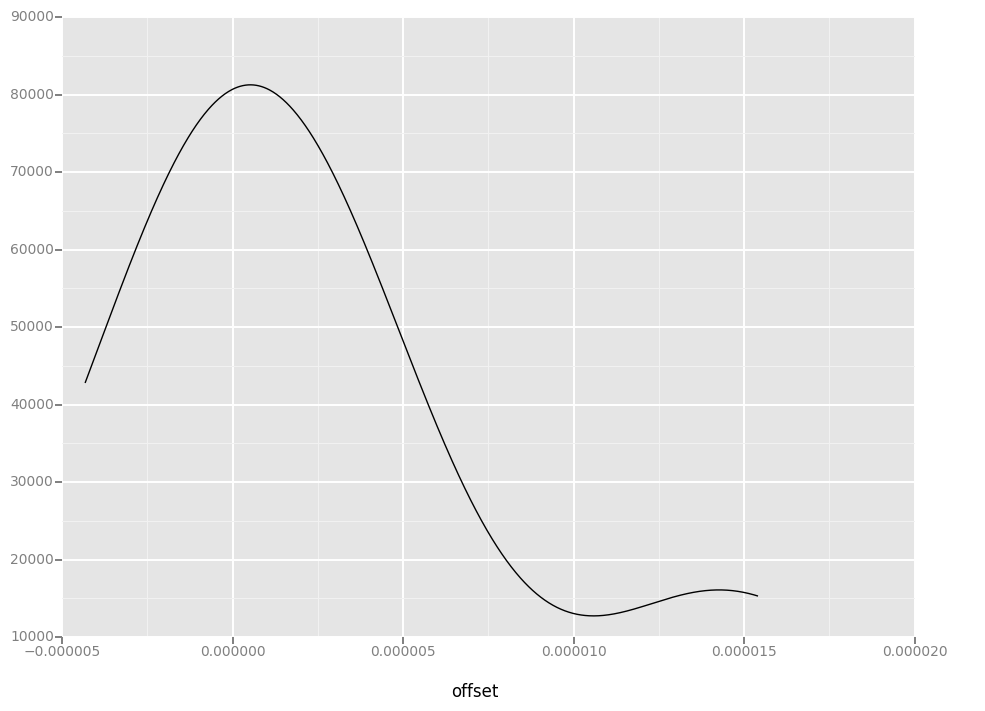

<ggplot: (307337977)>


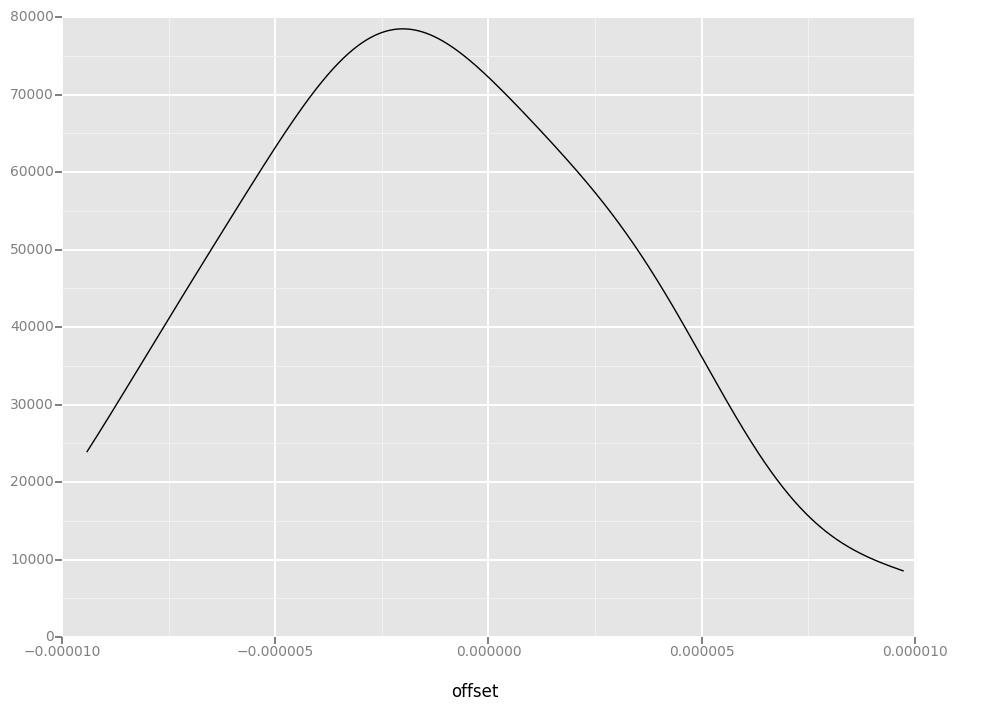

<ggplot: (315444213)>


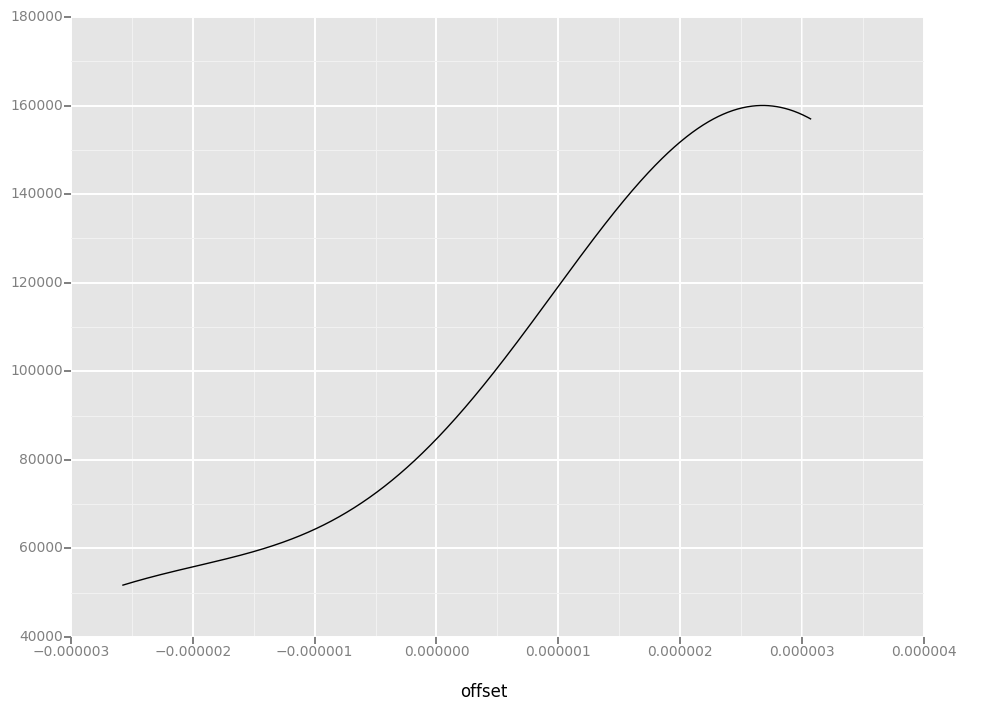

<ggplot: (307120921)>


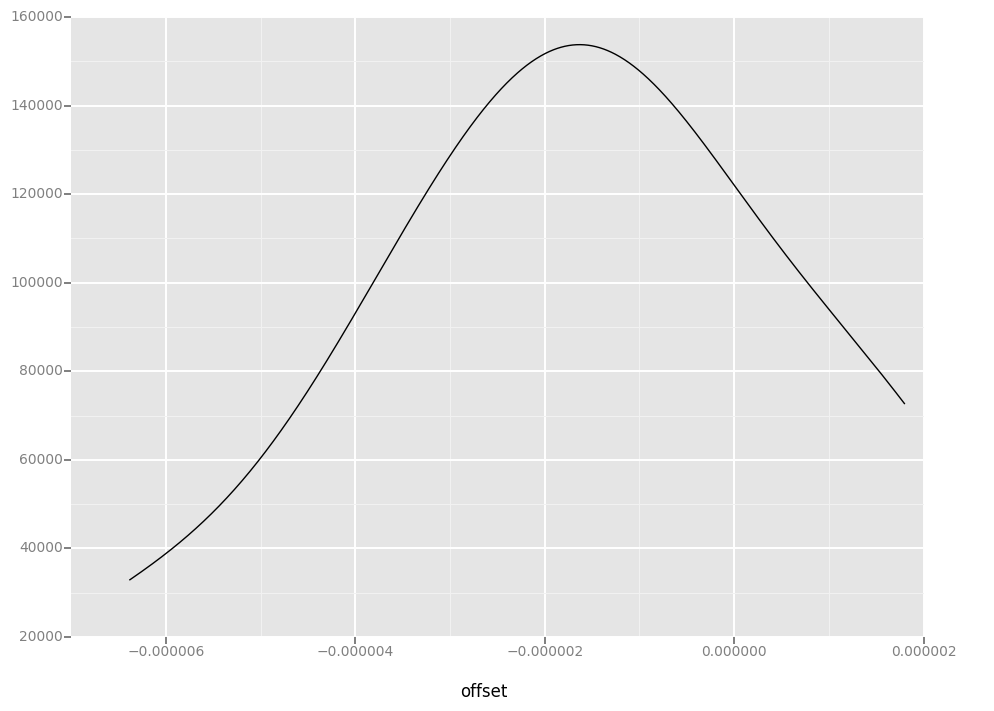

<ggplot: (307080749)>


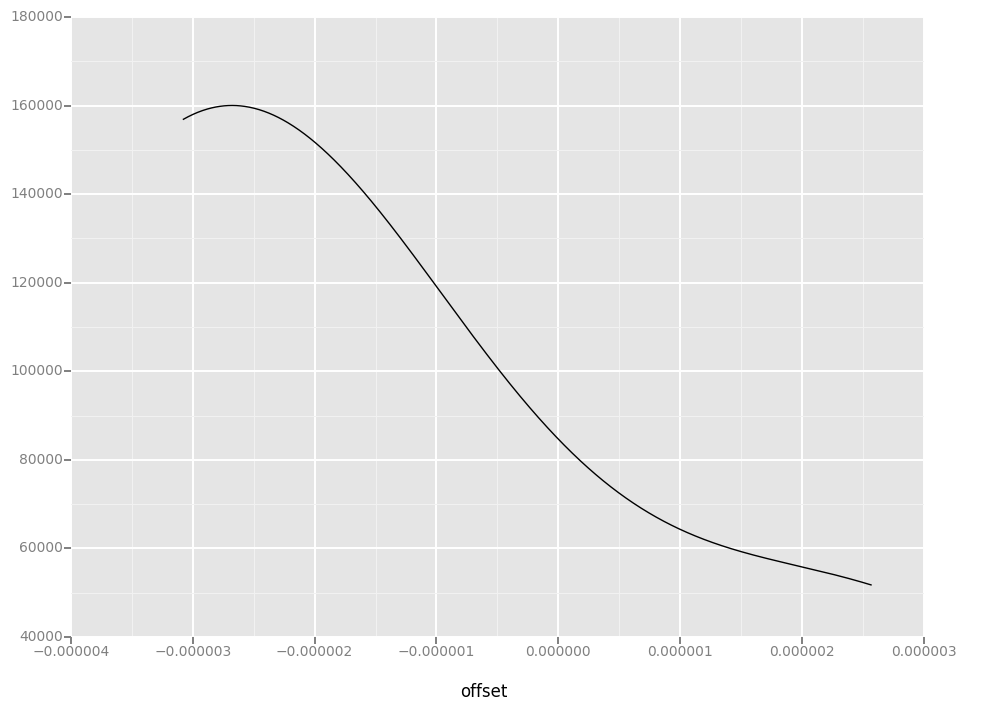

<ggplot: (307022245)>


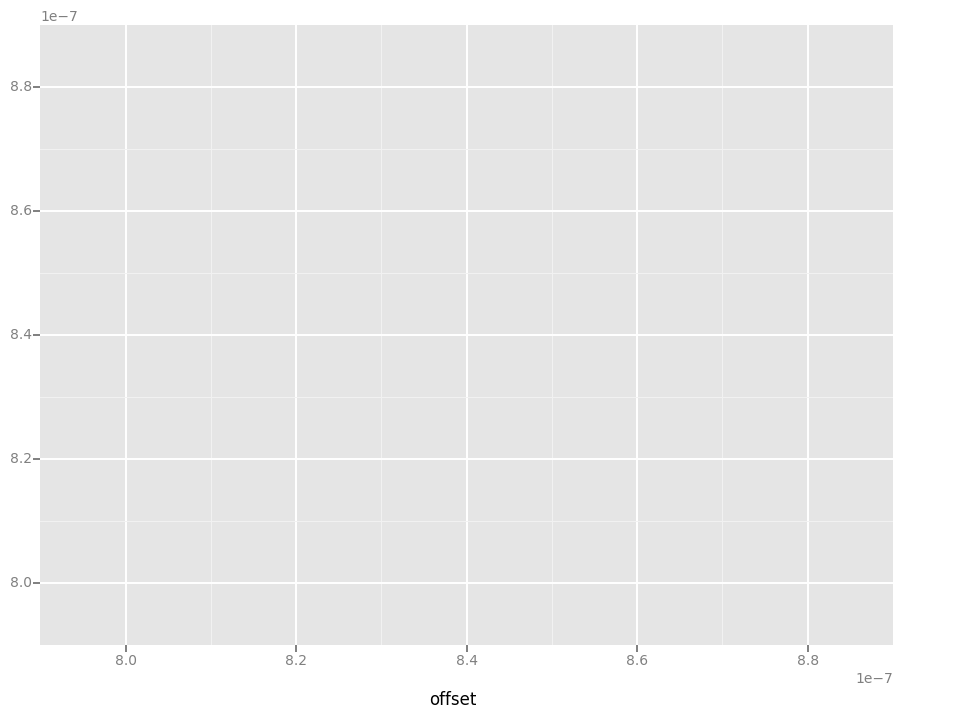

<ggplot: (309227753)>


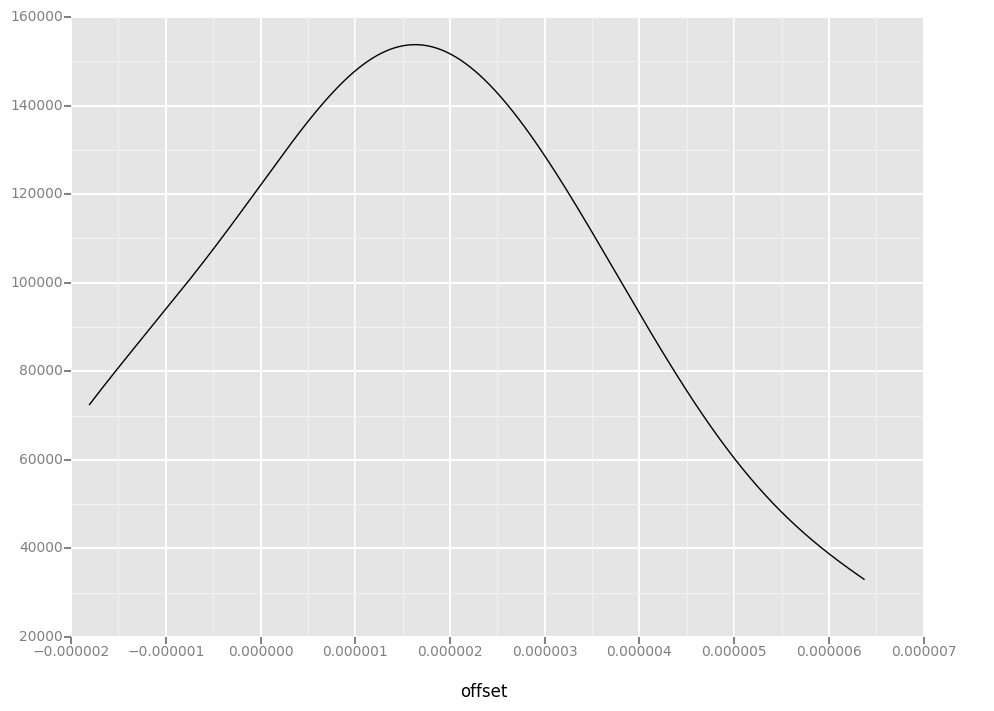

<ggplot: (306877693)>


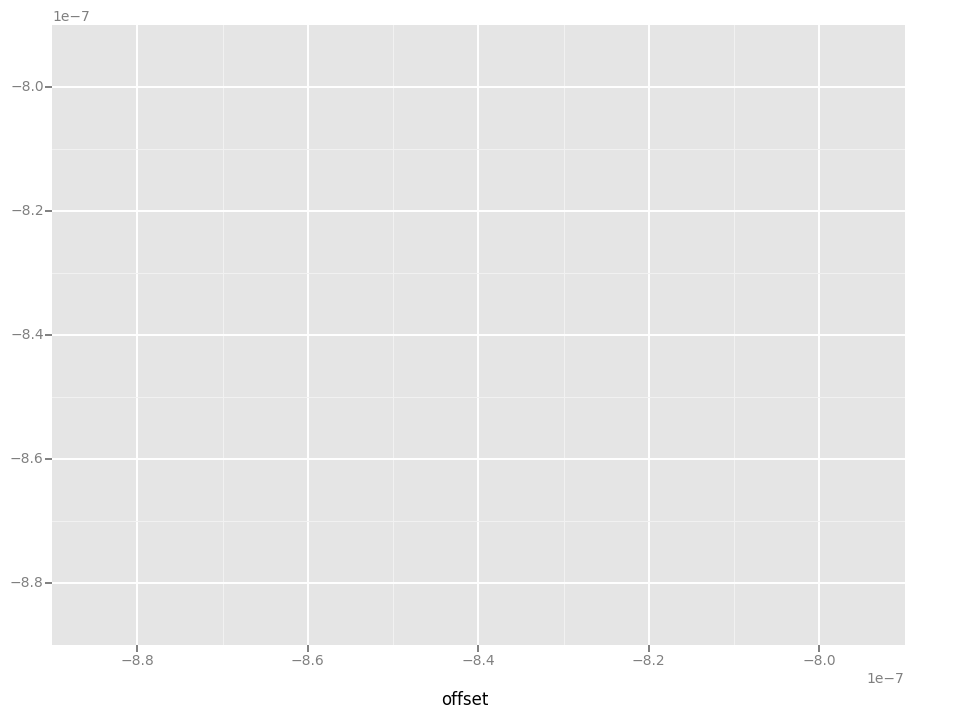

<ggplot: (306231745)>


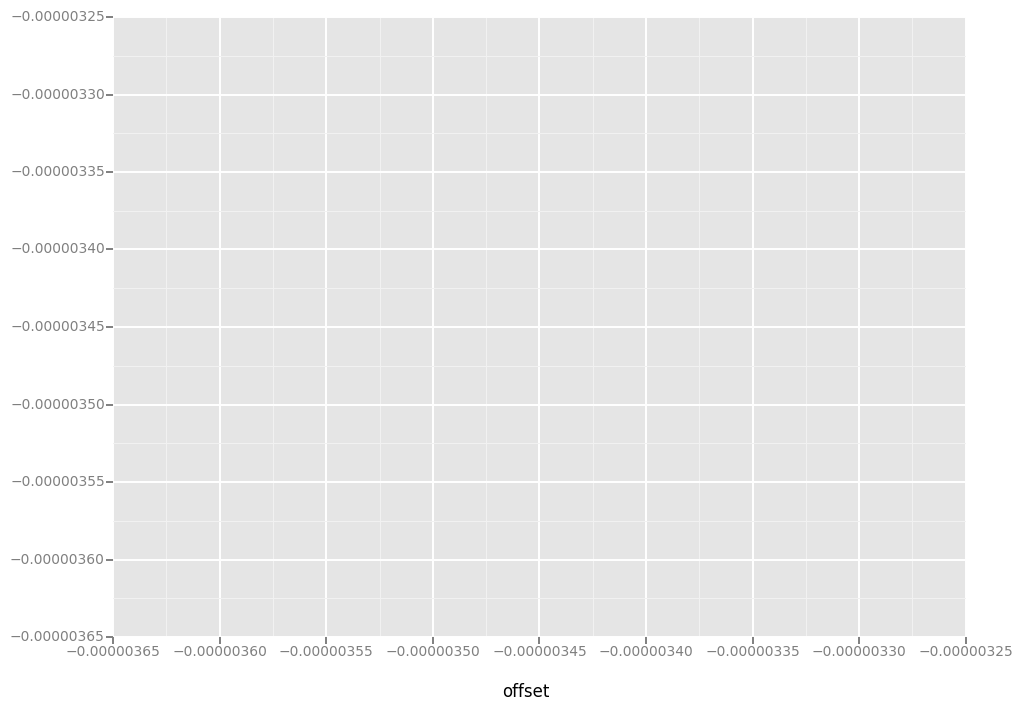

<ggplot: (296980293)>


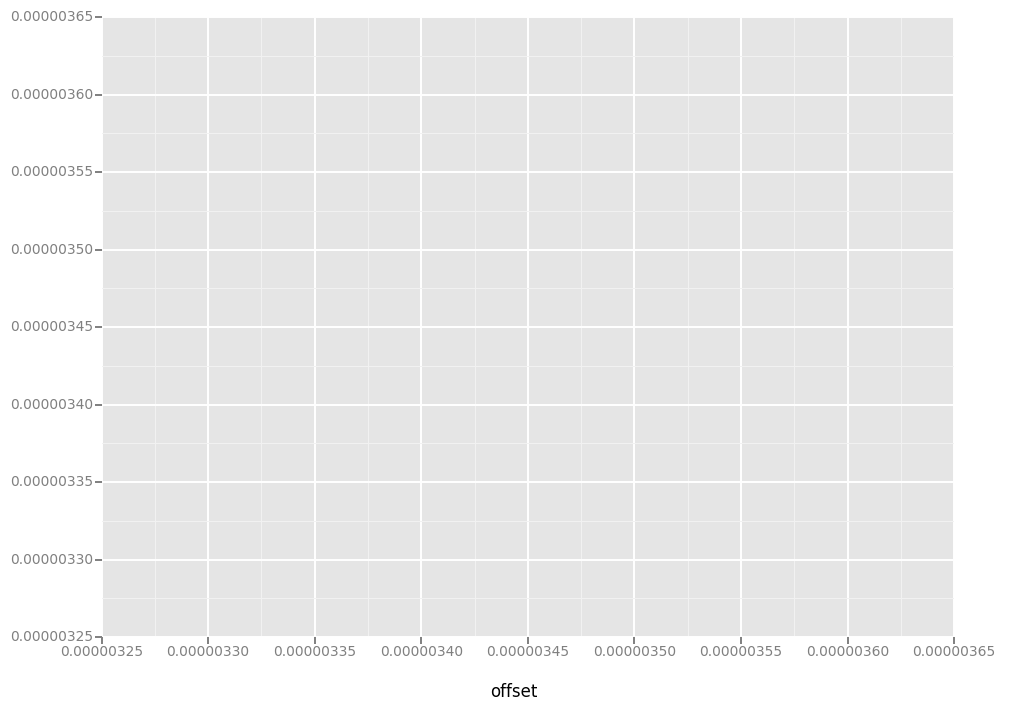

<ggplot: (308701273)>


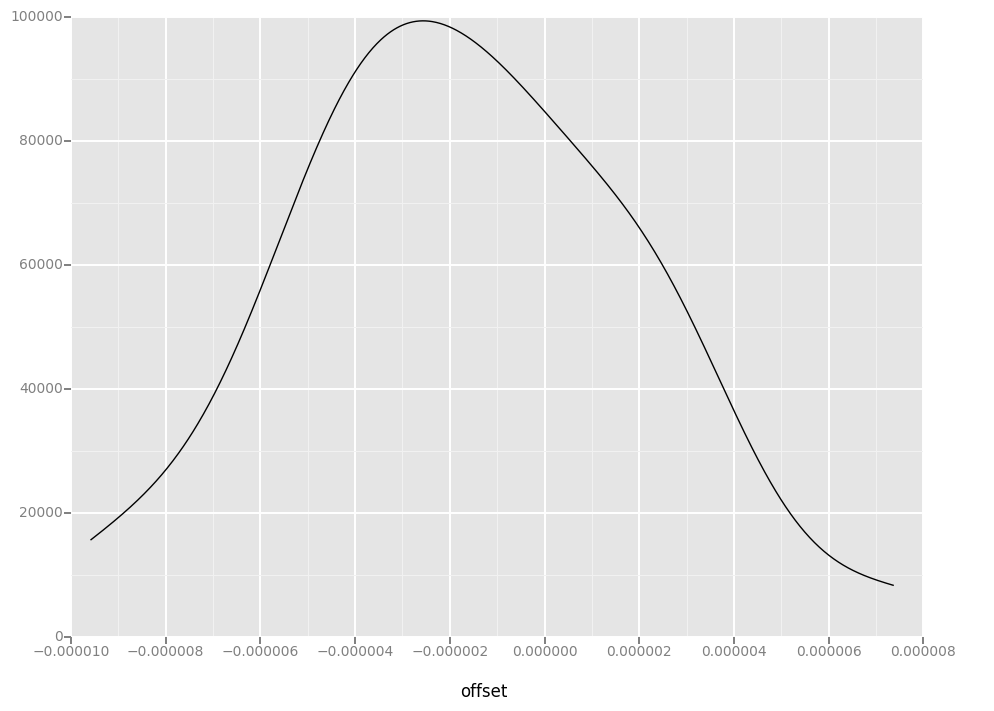

<ggplot: (306882221)>


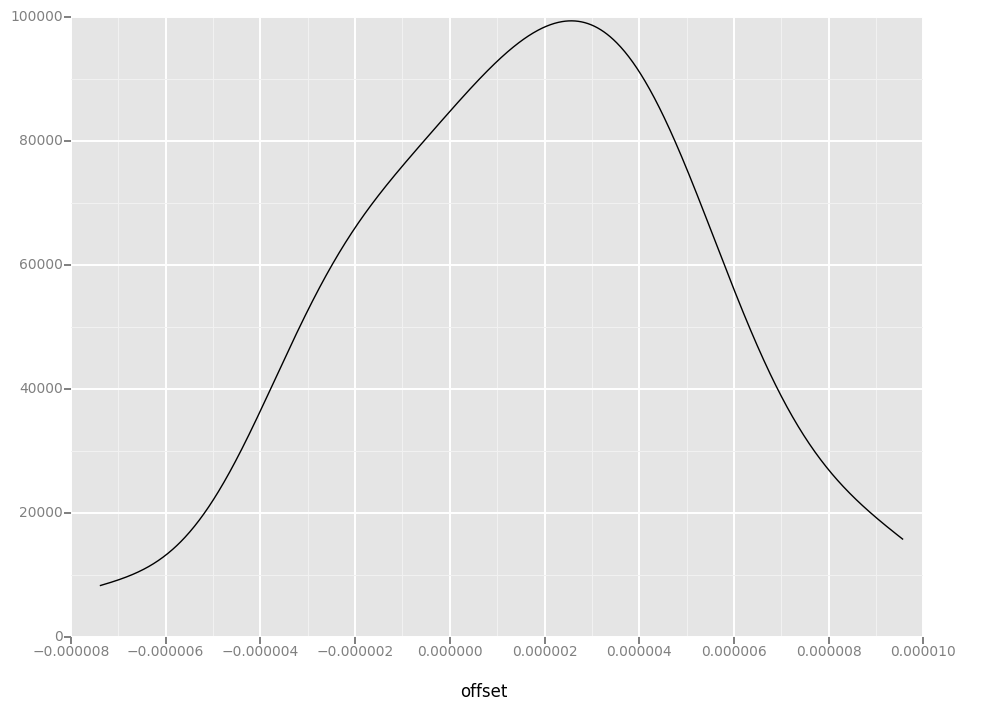

<ggplot: (306400713)>


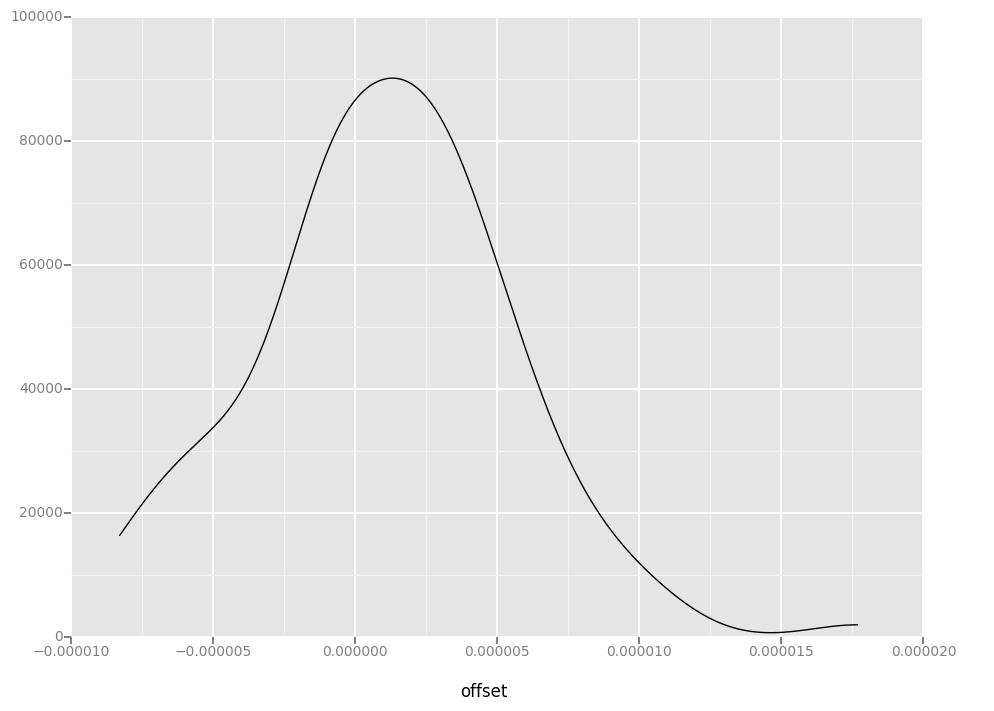

<ggplot: (306400757)>


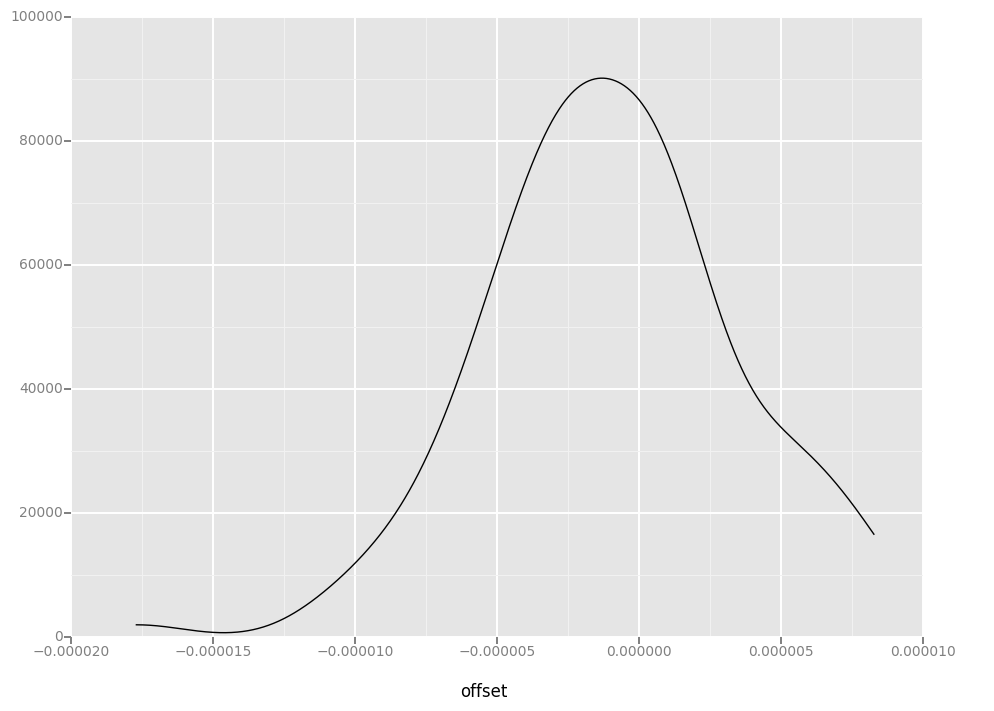

<ggplot: (306209805)>


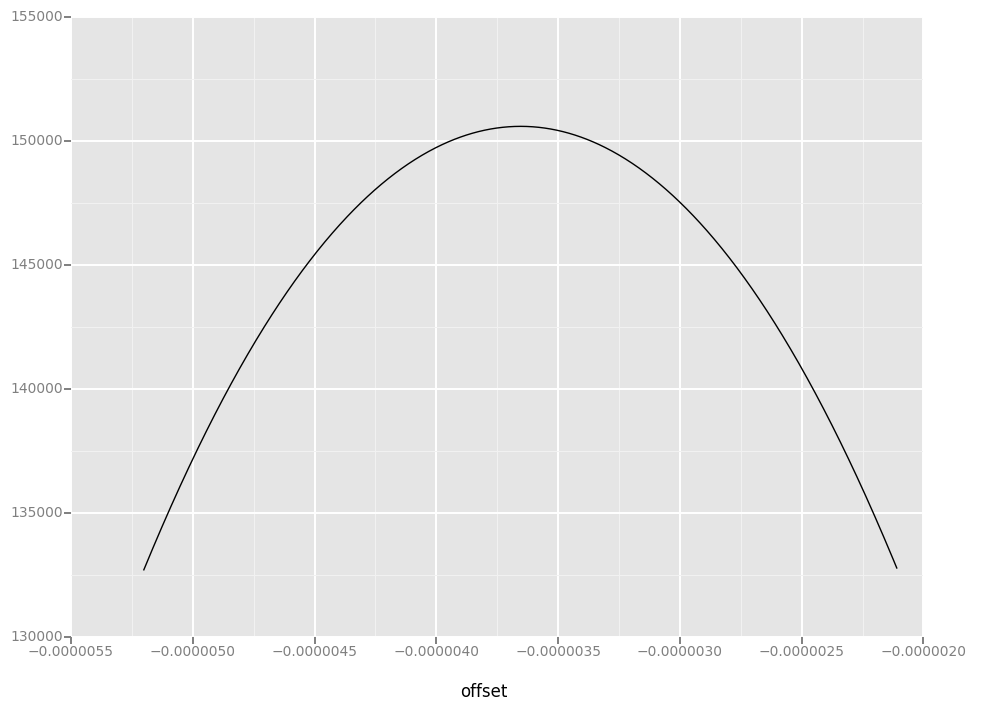

<ggplot: (307790965)>


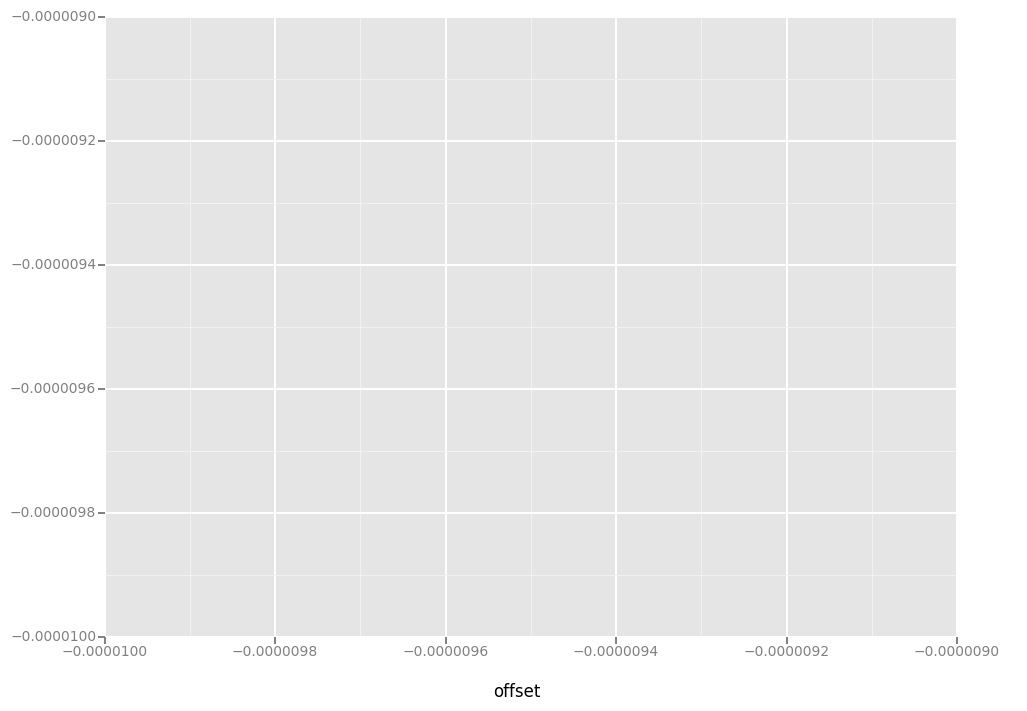

<ggplot: (307790857)>


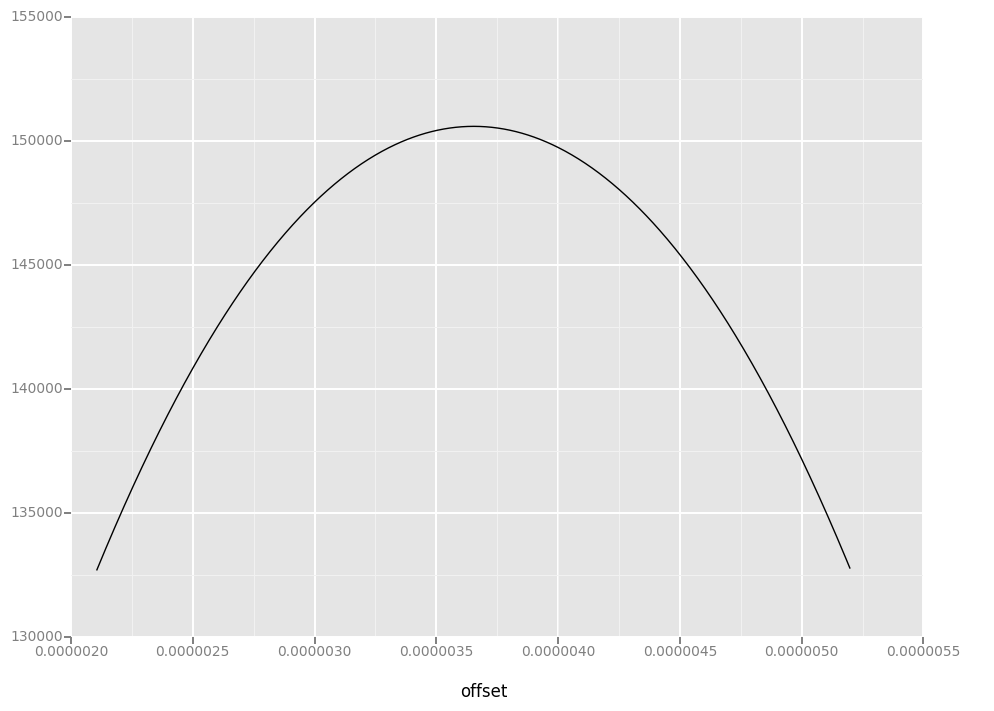

<ggplot: (296991397)>


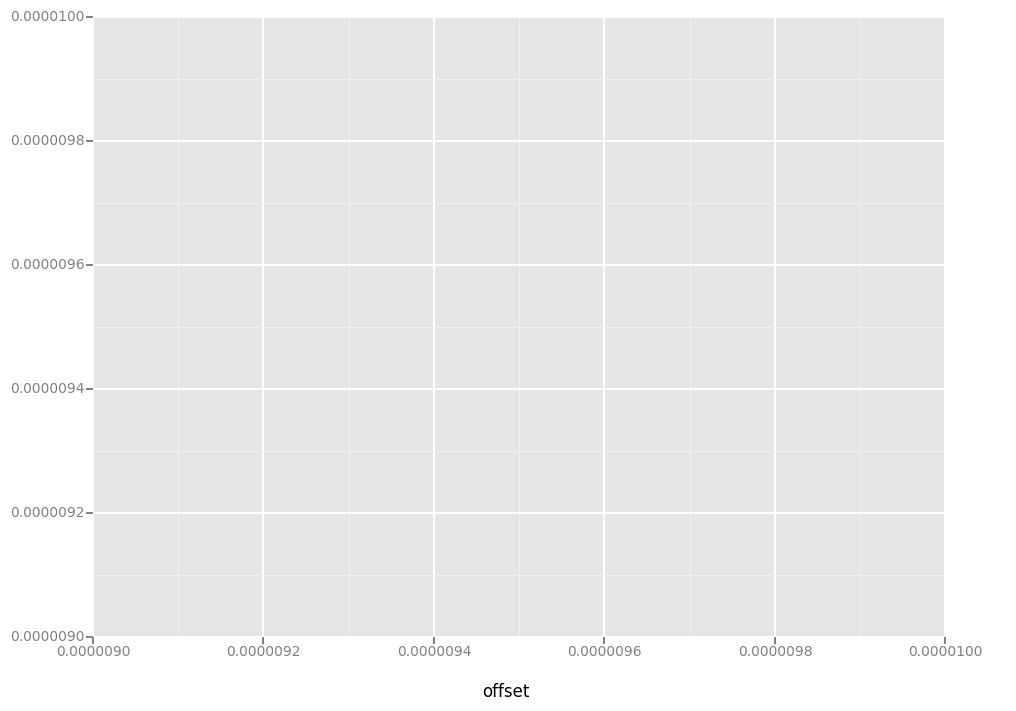

<ggplot: (309585441)>


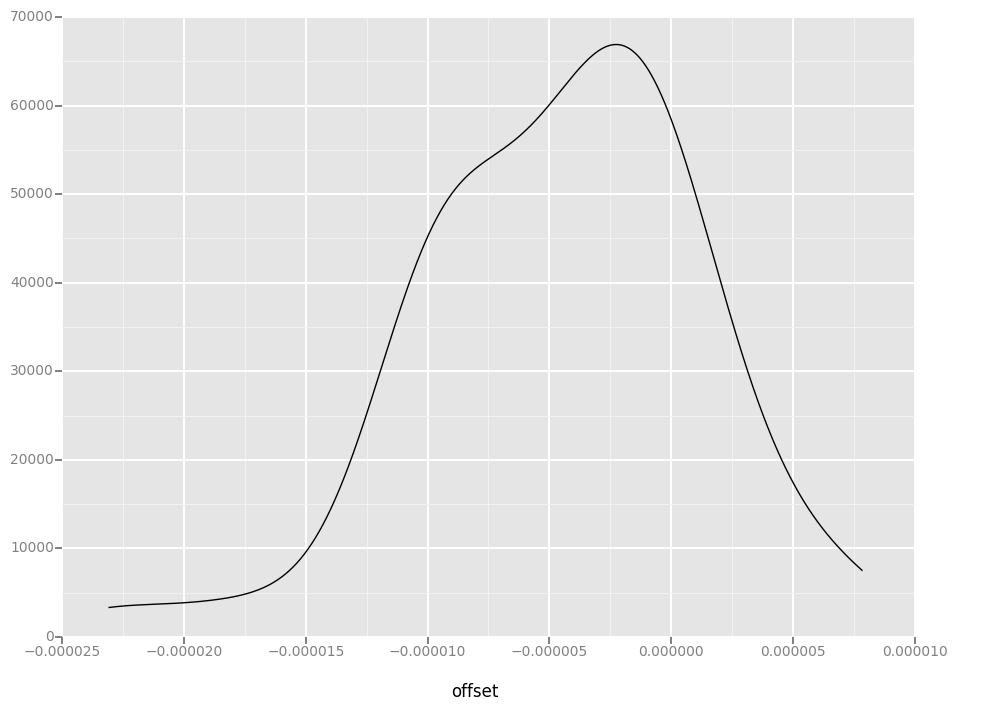

<ggplot: (309585541)>


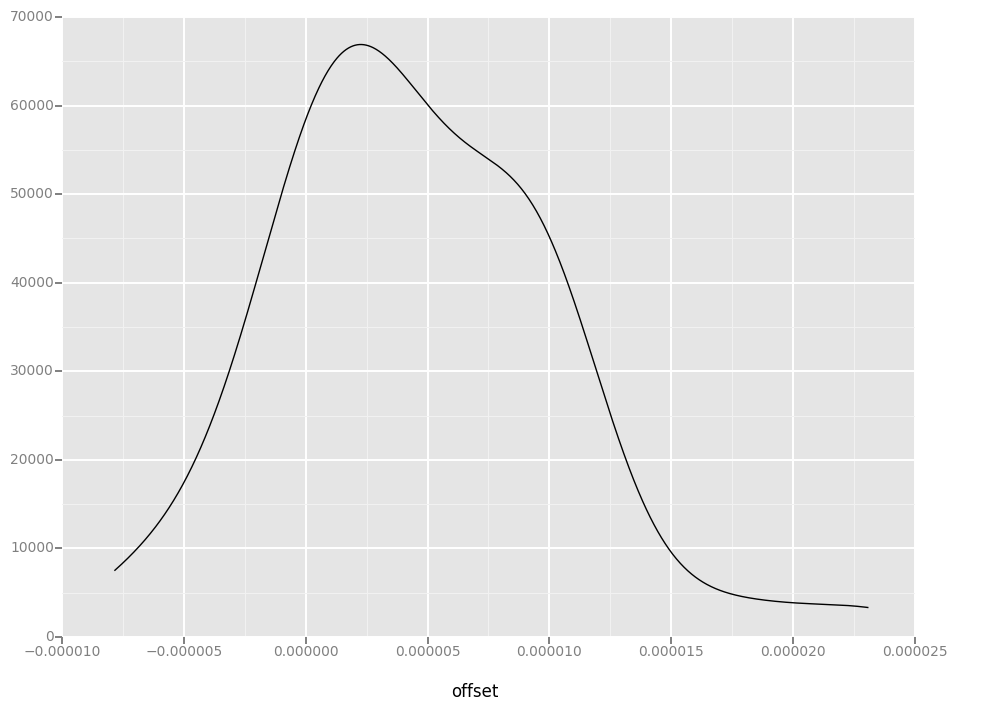

<ggplot: (305880041)>


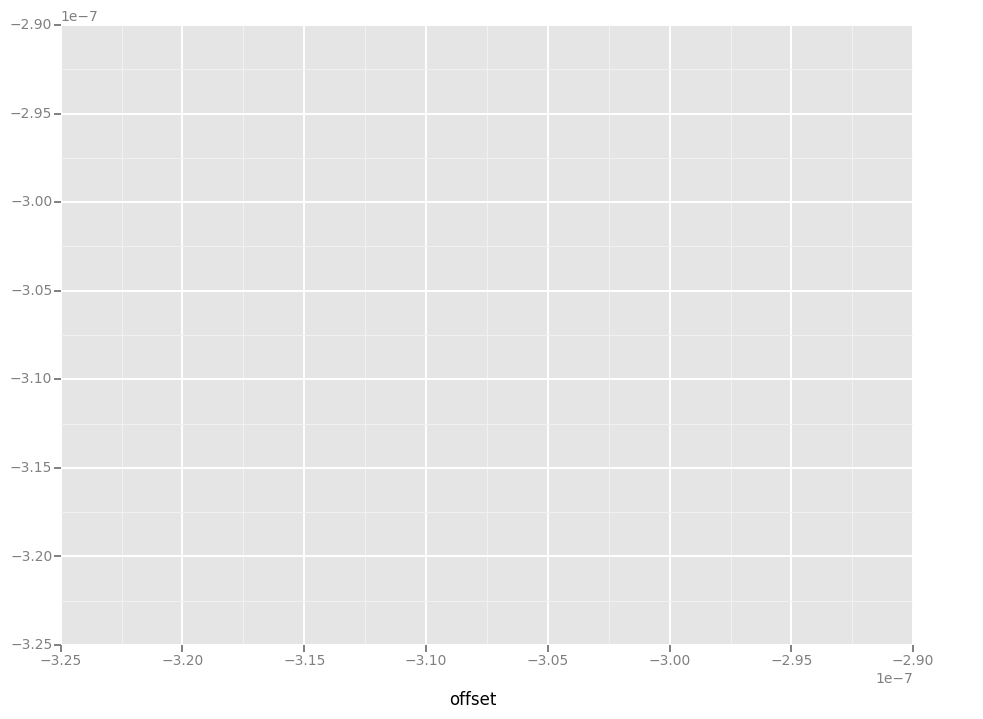

<ggplot: (307646001)>


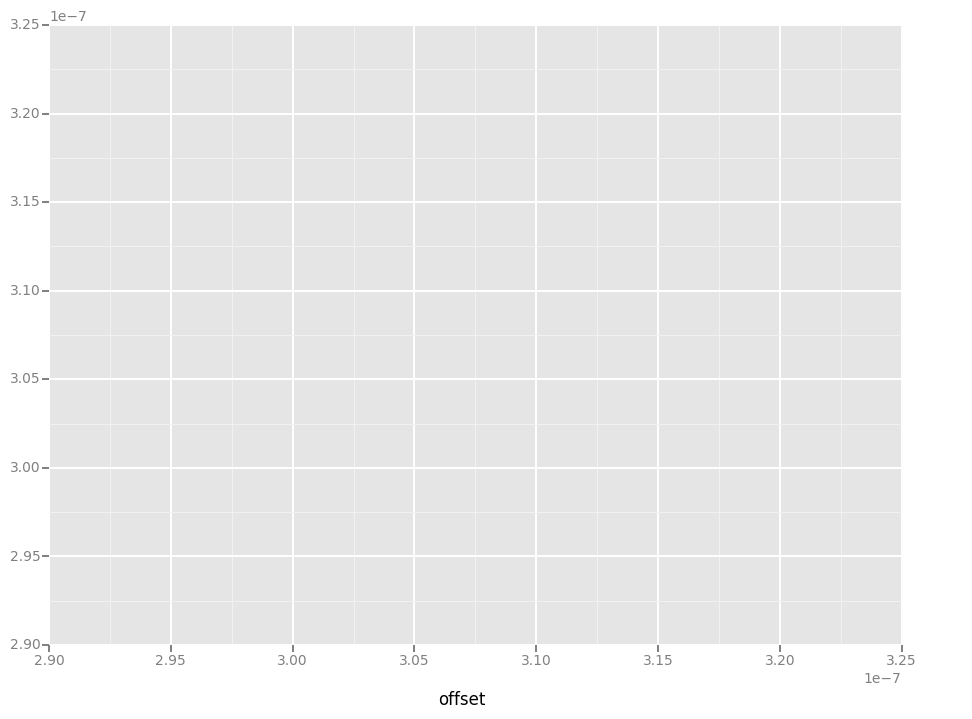

<ggplot: (301166221)>


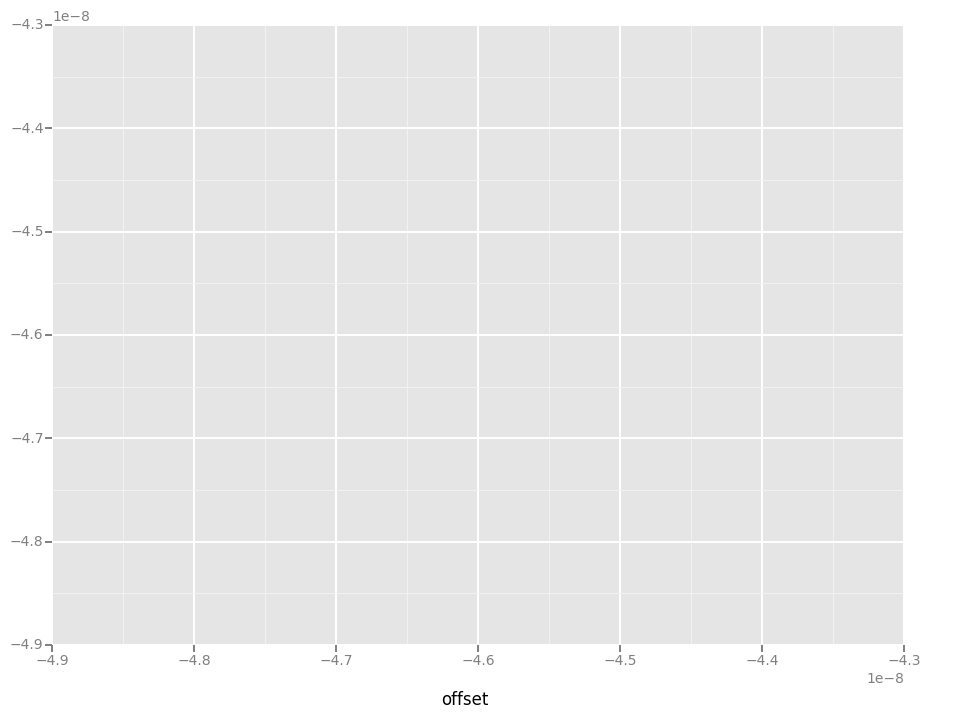

<ggplot: (306356017)>


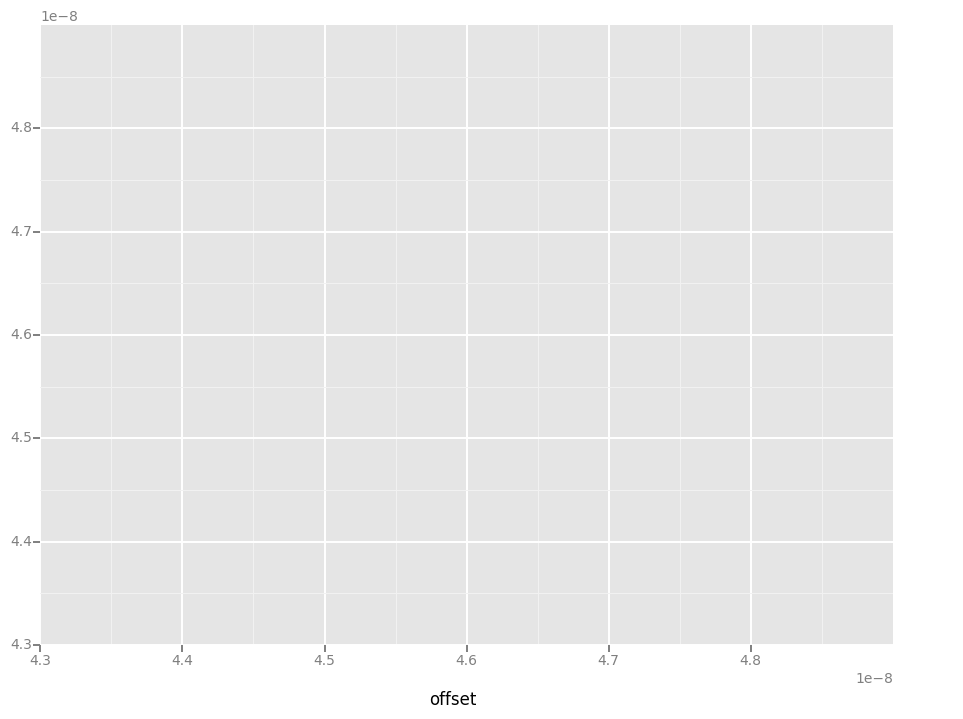

<ggplot: (306133689)>


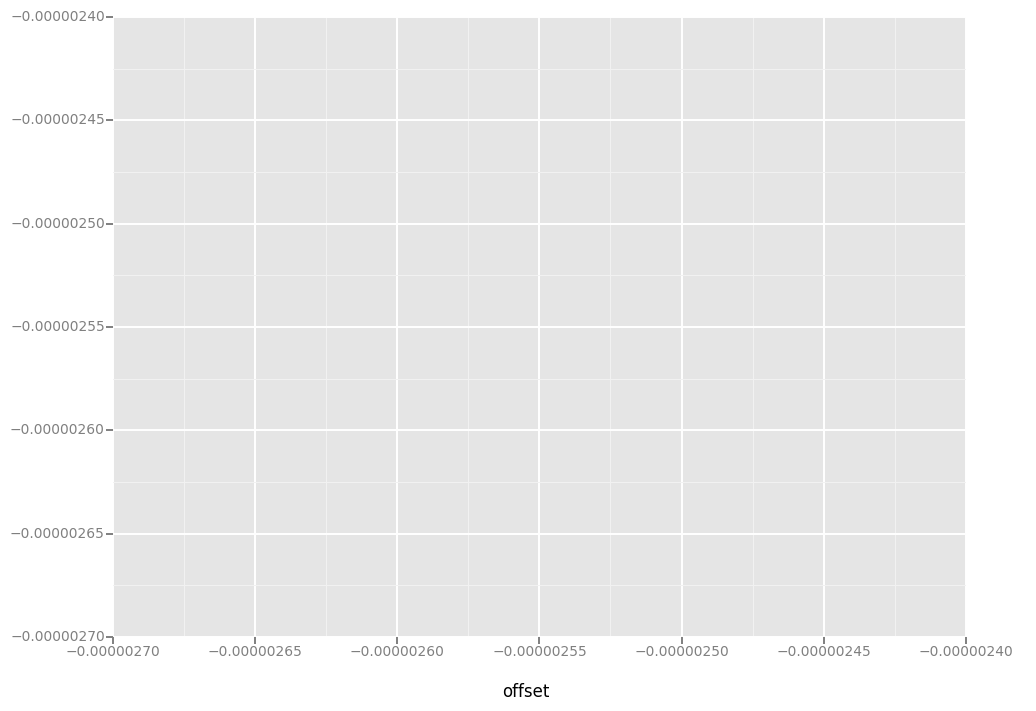

<ggplot: (311503541)>


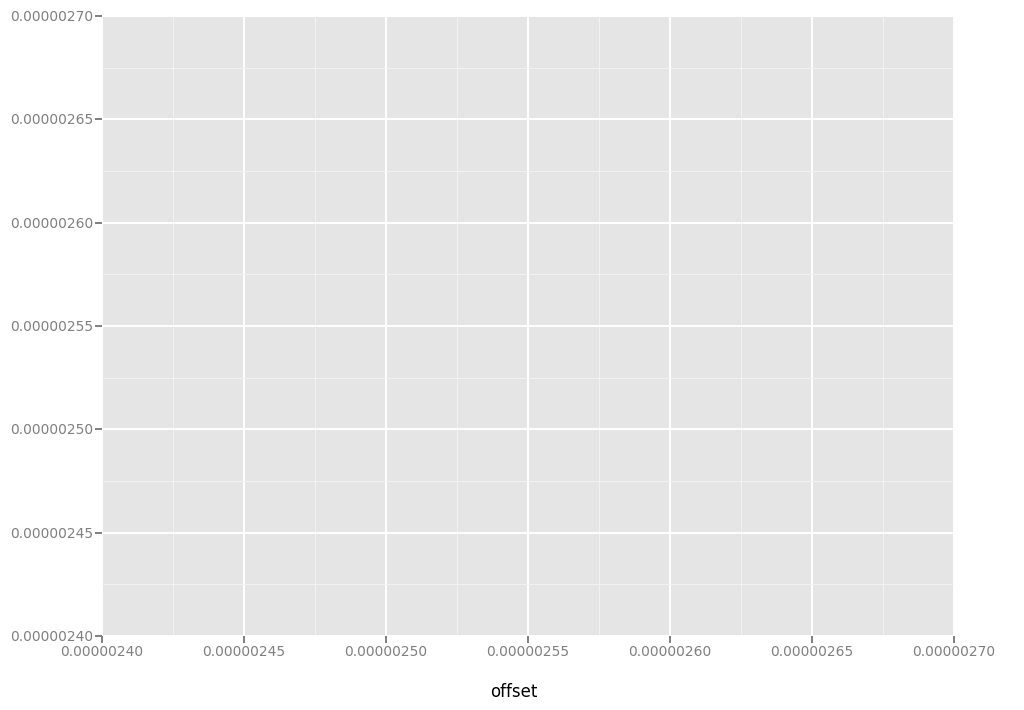

<ggplot: (311503545)>


In [590]:
d = pd.DataFrame(pairslist)
d = d[(d['offset'] < 0.05) & (d['offset'] > -0.05)]

g = ggplot(aes(x='offset', color='addr'), data=d) + stat_density()
print g

for addr in d['addr'].unique():
    d2 = d[ d['addr'] == addr ]
    g = ggplot(aes(x='offset'), data=d2) + stat_density()
    print g


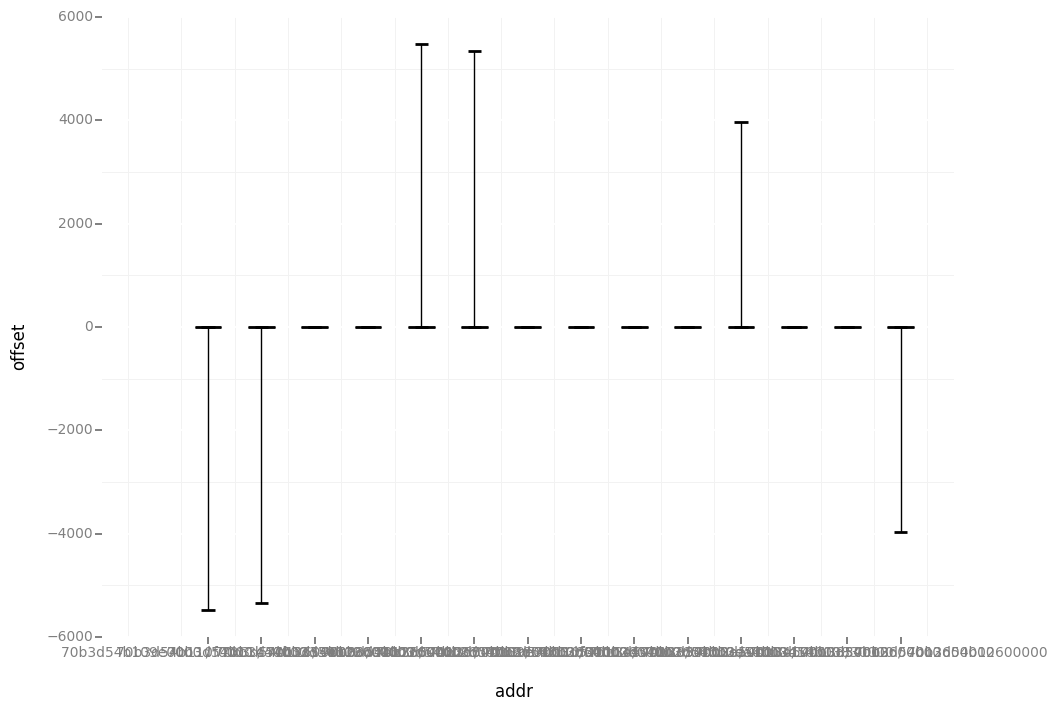

<ggplot: (302286193)>


In [533]:
d = pd.DataFrame(pairslist)
d2 = d[ (d['addr1'] == '70b3d54b12600000') | (d['addr2'] == '70b3d54b12600000') ]
#d2 = d2[d2['addr2'] != '70b3d54b12600000']
#d2 = d2[d2['addr1'] != '70b3d54b110f0000']
#d2 = d2[d2['addr2'] != '70b3d54b110f0000']
#d2 = d2[d2['addr1'] != '70b3d54b13830000']
#d2 = d2[d2['addr2'] != '70b3d54b13830000']
p = ggplot(aes(x='addr', y='offset'), data=d2) #color='Gateway'
g = p + geom_boxplot(outliers=False, notch=True) + theme_bw()
print g

In [1323]:
def reject_outliers(data, m = 2.):
    if len(data) < 2:
        return data
    data2 = np.array(data)
    d = np.abs(data2 - np.median(data2))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data2[s<m]

In [1554]:
def calculate_offsets(m=1.):
    offsets = {}
    for a,aval in pairs.iteritems():
        offsets[a] = {}
        for b,bval in aval.iteritems():
            offsets[a][b] = {}

            if len(bval) < 3:
                offsets[a][b]['mean'] = 0
                offsets[a][b]['std'] = 0               
            
            o = []
            for item in bval:
                o.append(item['offset'])
            o = reject_outliers(o, m=m)

            offsets[a][b]['mean'] = np.mean(o)
            offsets[a][b]['std'] = np.std(o)
    return offsets
            
            #total = 0
            #num = 0
            #for item in bval:
            #    if abs(item['offset']) < 1:
            #        total += item['offset']
            #        num += 1
            #mean = total/num
            #offsets[a][b]['mean'] = mean
            #
            #total = 0
            #num = 0
            #for item in bval:
            #    if abs(item['offset']) < 1:
            #        total += (item['offset'] - mean)**2
            #        num +=1
            #std = math.sqrt(total/num)
            #offsets[a][b]['std'] = std

In [1569]:
offsets = calculate_offsets(m=1.)

<Container object of 3 artists>

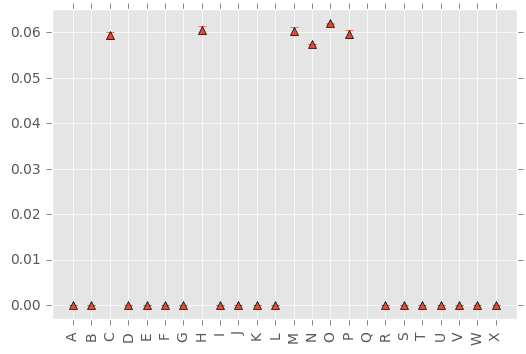

In [1570]:
i=0
x=[]
xlab=[]
y=[]
err=[]
pairs2=[]
for a,aval in offsets.iteritems():
    for b, bval in aval.iteritems():
        if (a,b) not in pairs2 and (b,a) not in pairs2: #and abs(bval['mean'])<0.05:
            xlab.append(chr(i+ord('A')))
            x.append(i)
            y.append(abs(bval['mean']))
            err.append(bval['std'])
            pairs2.append((a,b))
            i+=1
            
plt.xticks(x, xlab, rotation='vertical')
plt.margins(0.05)
plt.errorbar(x, y, yerr=err, linestyle='None', marker='^')

<Container object of 3 artists>

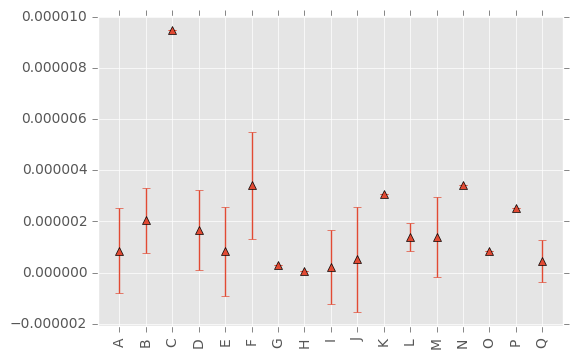

In [1571]:
i=0
x=[]
xlab=[]
y=[]
err=[]
pairs2=[]
for a,aval in offsets.iteritems():
    for b, bval in aval.iteritems():
        if (a,b) not in pairs2 and (b,a) not in pairs2 and abs(bval['mean'])<0.05:
            xlab.append(chr(i+ord('A')))
            x.append(i)
            y.append(abs(bval['mean']))
            err.append(bval['std'])
            pairs2.append((a,b))
            i+=1
            
plt.xticks(x, xlab, rotation='vertical')
plt.margins(0.05)
plt.errorbar(x, y, yerr=err, linestyle='None', marker='^')

In [912]:
def TDOAs_2D_Offsets(gateways, offsets):
    tmp = []
    for gw in gateways:
        x,y = convert_bng(gw['lon'], gw['lat'])
        tmp.append({
                'x': x[0],
                'y': y[0],
                'time': gw['time'],
                'addr': gw['addr']
            })
    
    #D = scipy.array(tmp)
    #D = D[D[:,2].argsort()]
    #D = D[-3:,:]
    
    ready = False
    i=0
    while(not ready):
        
        D = pd.DataFrame(tmp)
        D = D.sort_values('time')
        D = D.iloc[i:]
        
        if len(D) < 3:
            return False
        
        t = D.iloc[0]['time'].copy()

        D['time'] -= t
        for addr in D['addr']:
            if addr == D.iloc[0]['addr']: continue
            offset = offsets[addr][D.iloc[0]['addr']]['mean']
            D.ix[D['addr']==addr, 'time'] += offset

        ready = True
        j = 0
        for time in D['time']:
            if time > 0.001: #or time < 0:
                ready = False
                j += 1
        #print D
        #print D[ (D['time'] < 1) & (D['time'] >= 0) ]
        
        i += 1


    D['distance'] = D['time']*C
    
    #D = D.sort_values('distance')
    D = D[['x','y','distance']]
    
    return scipy.matrix(D.values)

False
False
[[ 529248.695       182694.556            0.        ]
 [ 529666.501       182097.649         1668.23600179]
 [ 530036.901       182759.178         1886.14610712]]


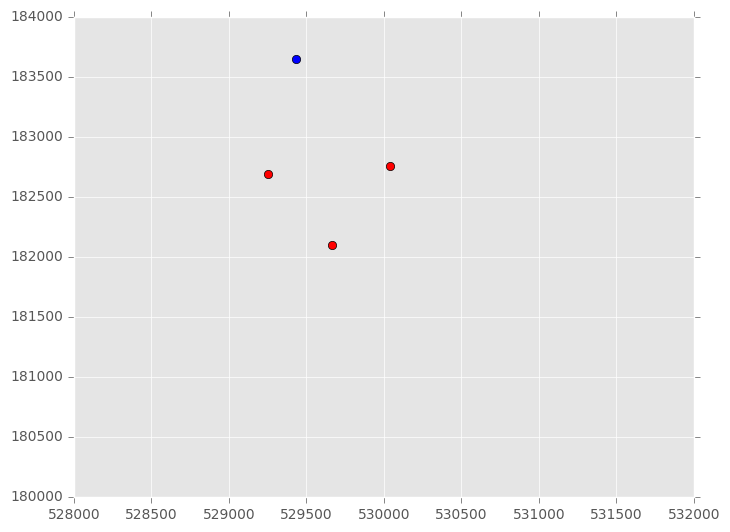

[[  5.29666472e+05   1.82098761e+05   0.00000000e+00]
 [  5.30037566e+05   1.82760308e+05   1.88154866e+02]
 [  5.29248001e+05   1.82694539e+05   1.90142387e+02]]


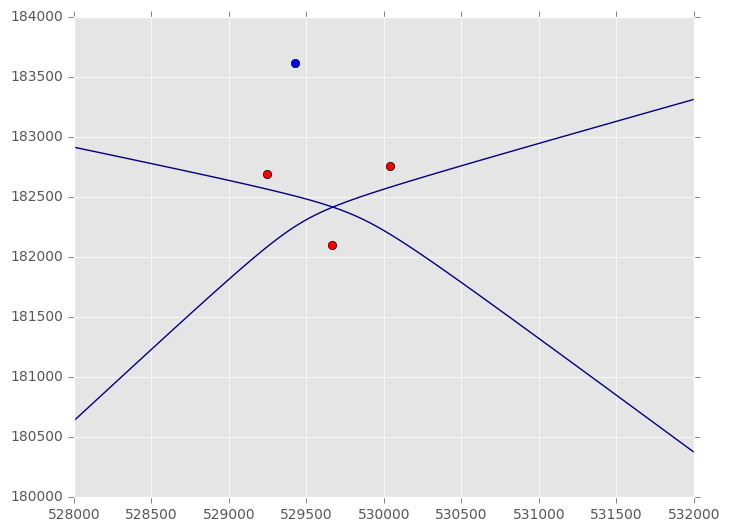

False
False
False
[[  5.29246670e+05   1.82692279e+05   0.00000000e+00]
 [  5.30037594e+05   1.82759196e+05   3.85148178e+02]
 [  5.29666501e+05   1.82097649e+05   1.02495118e+03]]


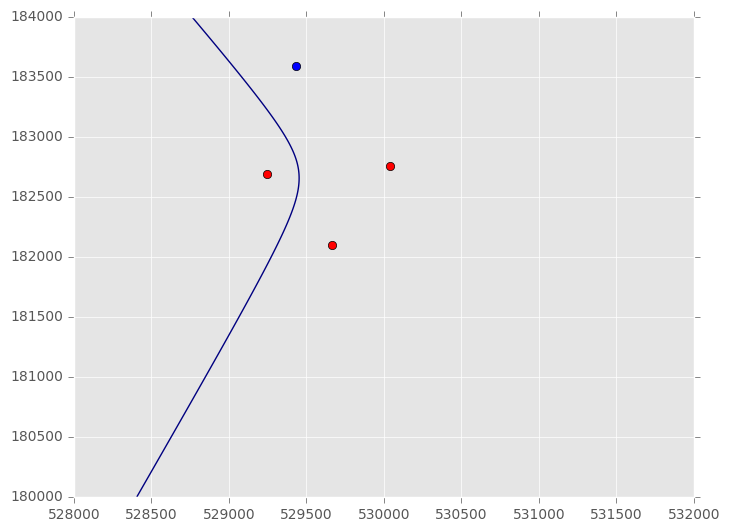

[[ 529246.67        182692.279            0.        ]
 [ 530037.594       182759.196          956.95691292]
 [ 529667.223       182096.555         1668.23600179]]


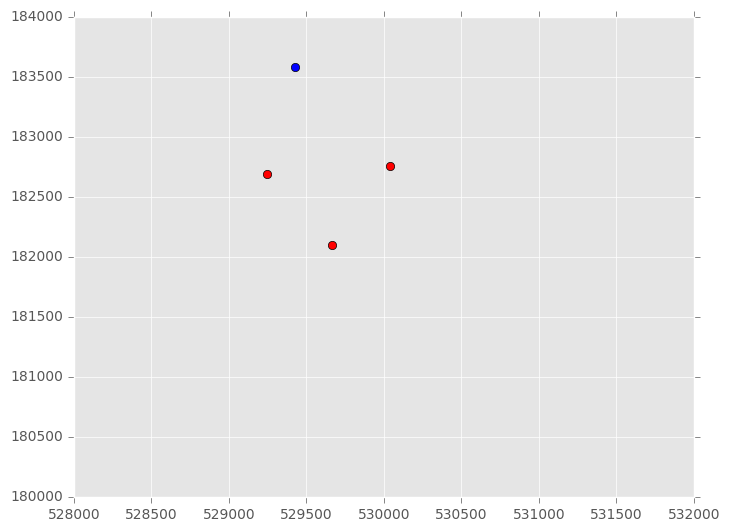

False
False
False
False
False
False
False
False
False
False
False
False
[[  5.29665057e+05   1.82099838e+05   0.00000000e+00]
 [  5.29252743e+05   1.82699110e+05   4.04570662e+02]
 [  5.30037651e+05   1.82756972e+05   1.40324843e+03]]


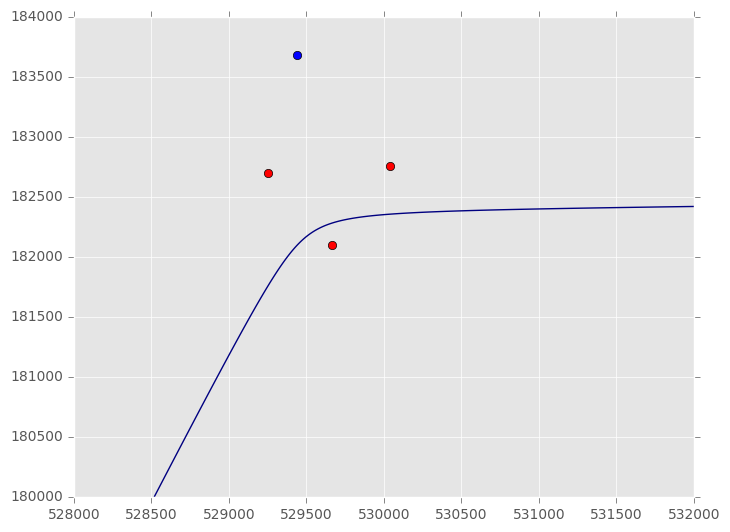

False
[[ 530037.651       182756.972            0.        ]
 [ 529252.743       182699.11          1759.13457783]
 [ 529665.057       182099.838         3099.7453596 ]]


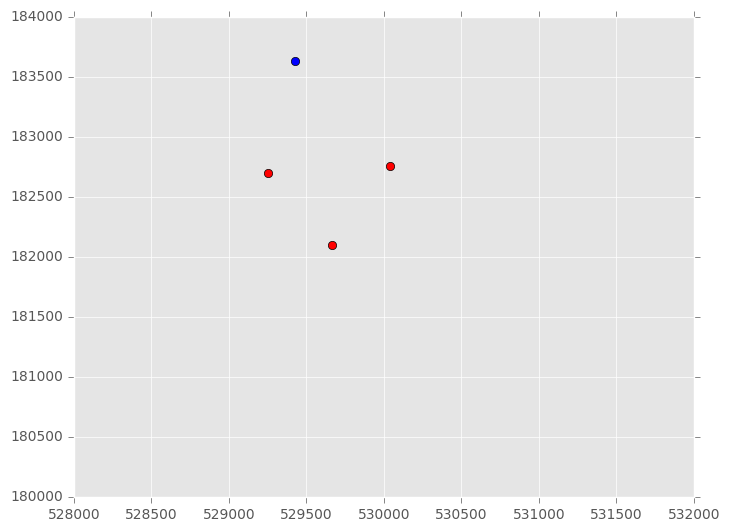

False
False
[[  5.30037651e+05   1.82756972e+05   0.00000000e+00]
 [  5.29252050e+05   1.82699093e+05   4.72564924e+02]
 [  5.29664391e+05   1.82098708e+05   1.88465180e+03]]


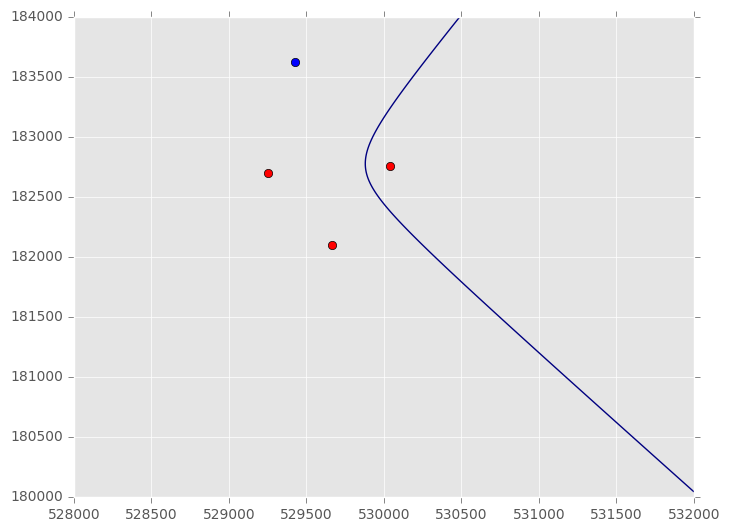

[[ 530038.345       182756.99             0.        ]
 [ 529664.391       182098.708         1884.65179795]
 [ 529252.05        182699.093         1401.75411852]]


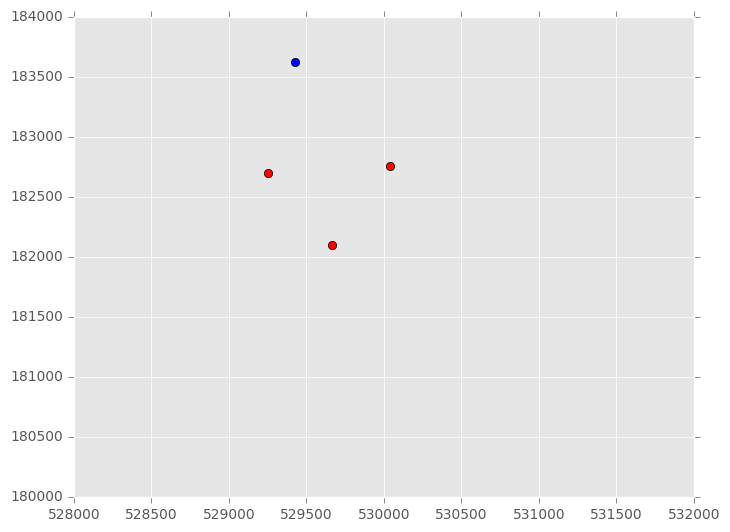

False
False
False
[[  5.29668610e+05   1.82096590e+05   0.00000000e+00]
 [  5.30037794e+05   1.82751412e+05   2.59630958e+02]
 [  5.29252050e+05   1.82699093e+05   2.26294905e+03]]


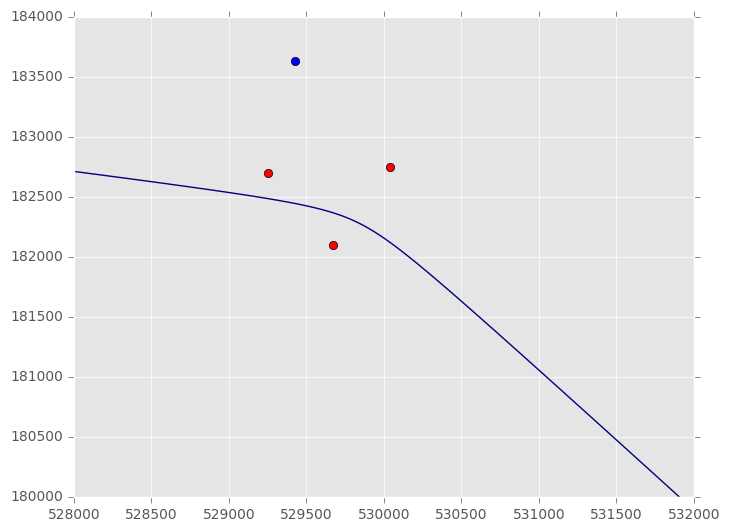

[[ 529668.639       182095.478            0.        ]
 [ 530038.459       182752.542         1117.34406024]
 [ 529251.384       182697.963          761.95112151]]


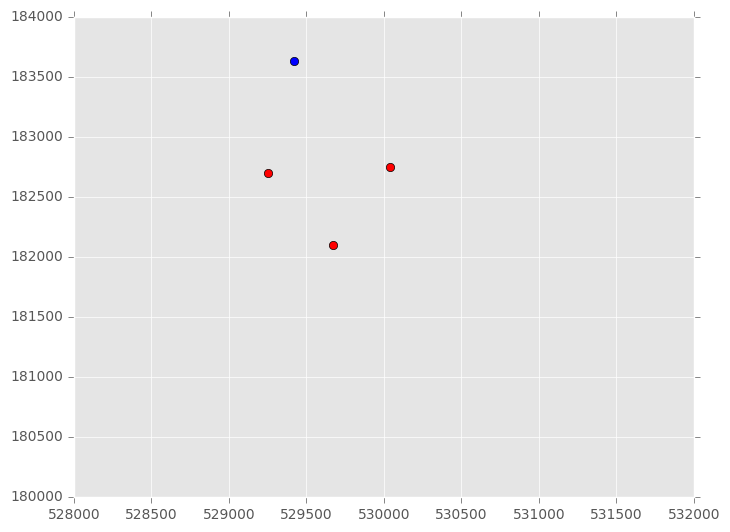

[[ 530037.794       182751.412            0.        ]
 [ 529667.194       182097.667          955.46260375]
 [ 529252.05        182699.093         1973.56285341]]


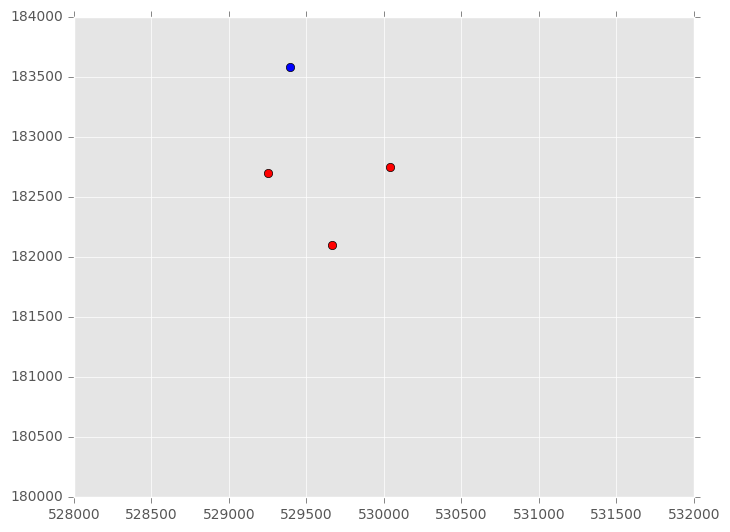

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
[[ 530037.623       182758.084            0.        ]
 [ 529245.949       182693.374         1115.84975107]
 [ 529667.223       182096.555         2527.9366247 ]]


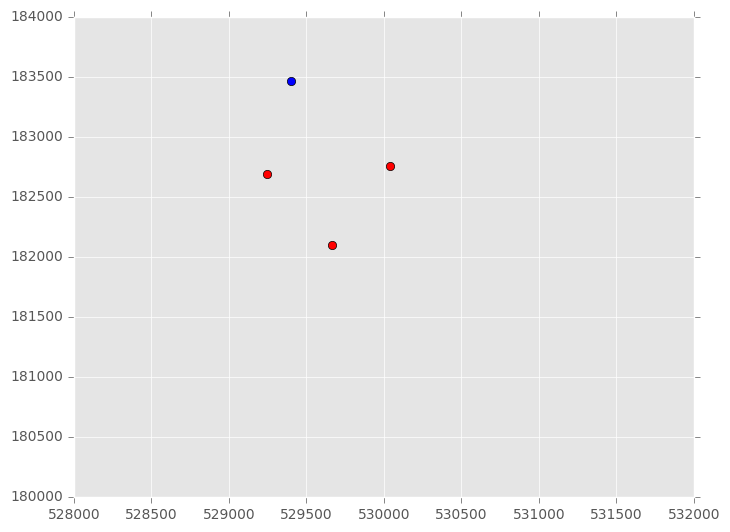

False
False
False
[[  5.29246670e+05   1.82692279e+05   0.00000000e+00]
 [  5.29666501e+05   1.82097649e+05   4.53142440e+02]
 [  5.30037594e+05   1.82759196e+05   1.31433737e+03]]


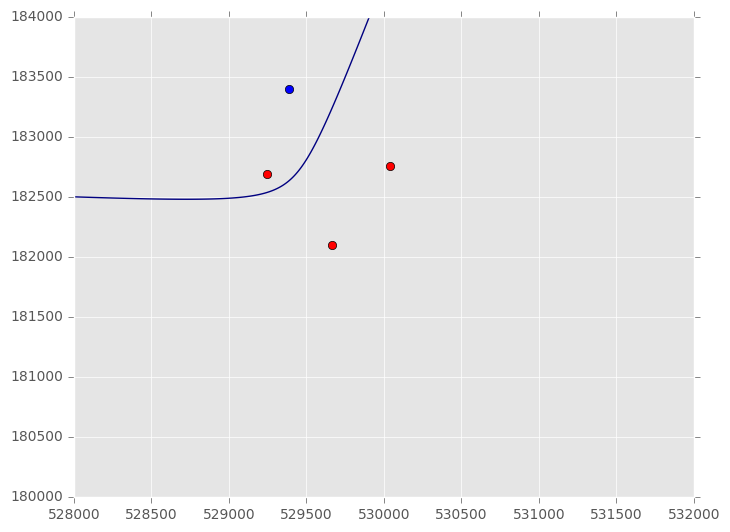

[[ 530038.259       182760.326            0.        ]
 [ 529246.67        182692.279         1473.23021038]
 [ 529666.472       182098.761         1956.12788981]]


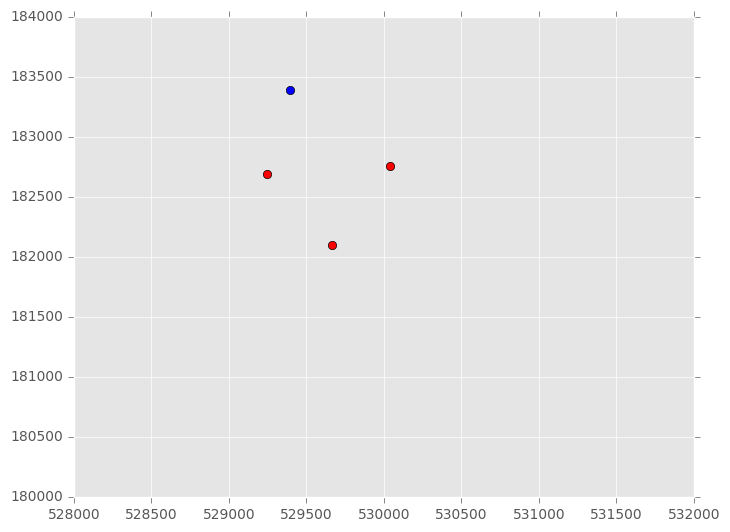

False
False
False
False
[[ 529248.695       182694.556            0.        ]
 [ 530036.901       182759.178         1028.43300478]
 [ 529666.501       182097.649         1954.14036923]]


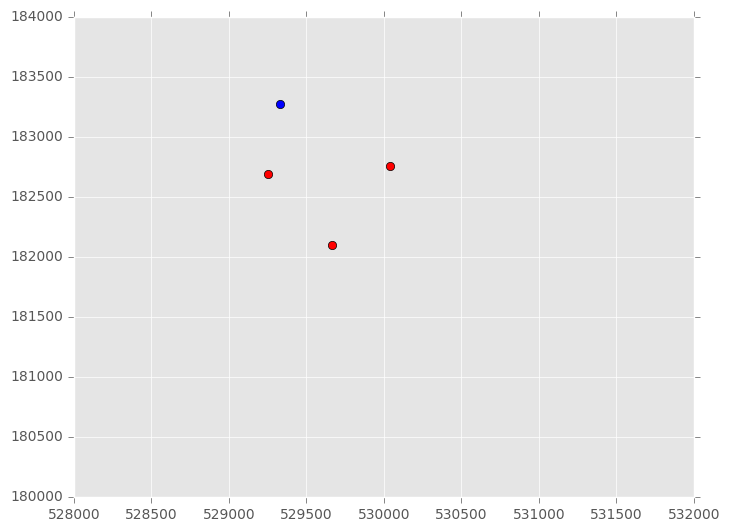

False
[[  5.29666501e+05   1.82097649e+05   0.00000000e+00]
 [  5.30037651e+05   1.82756972e+05   1.88154866e+02]
 [  5.29248695e+05   1.82694556e+05   4.76046754e+02]]


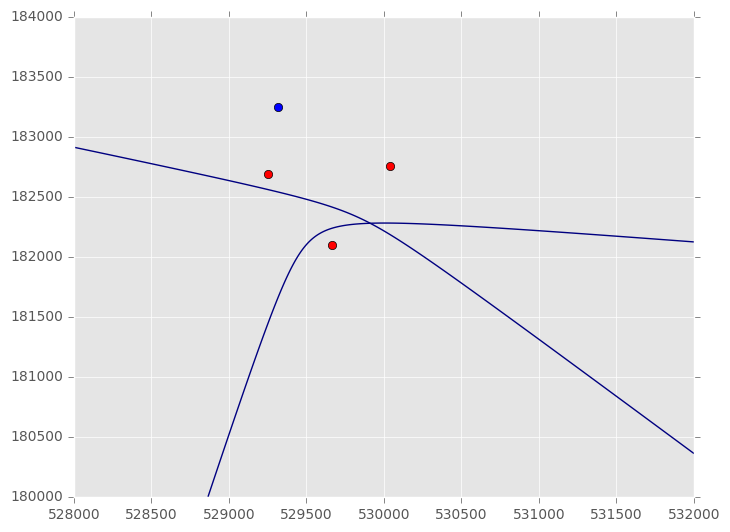

False
False
False
False
[[ 529252.05        182699.093            0.        ]
 [ 529668.639       182095.478         1382.33163434]
 [ 530037.708       182754.748         1314.33737223]]


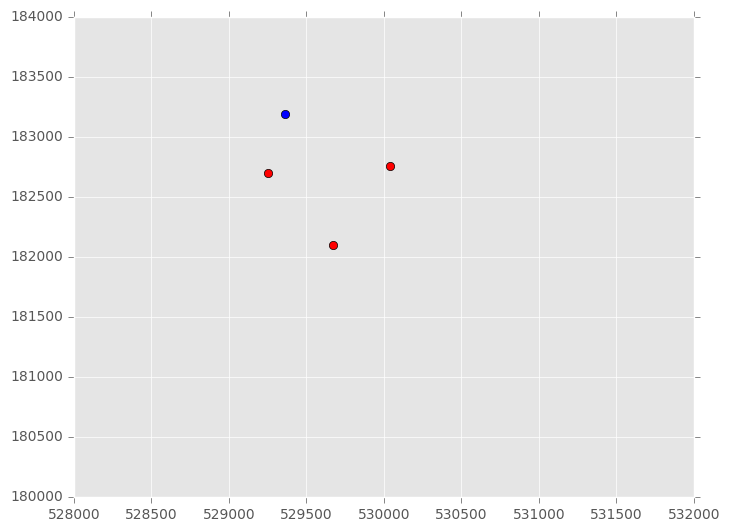

False
False
[[  5.30037651e+05   1.82756972e+05   0.00000000e+00]
 [  5.29253437e+05   1.82699128e+05   2.58136649e+02]
 [  5.29666472e+05   1.82098761e+05   2.81384099e+03]]


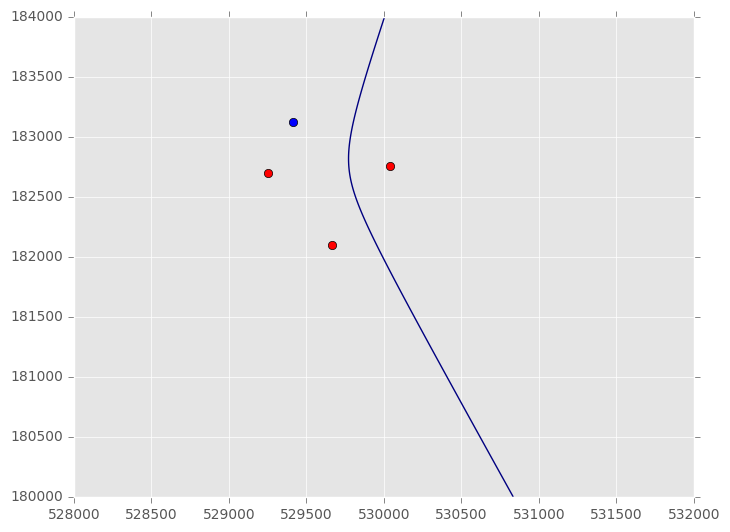

[[  5.29665057e+05   1.82099838e+05   0.00000000e+00]
 [  5.29253437e+05   1.82699128e+05   1.18666295e+02]
 [  5.30037651e+05   1.82756972e+05   1.68915280e+03]]


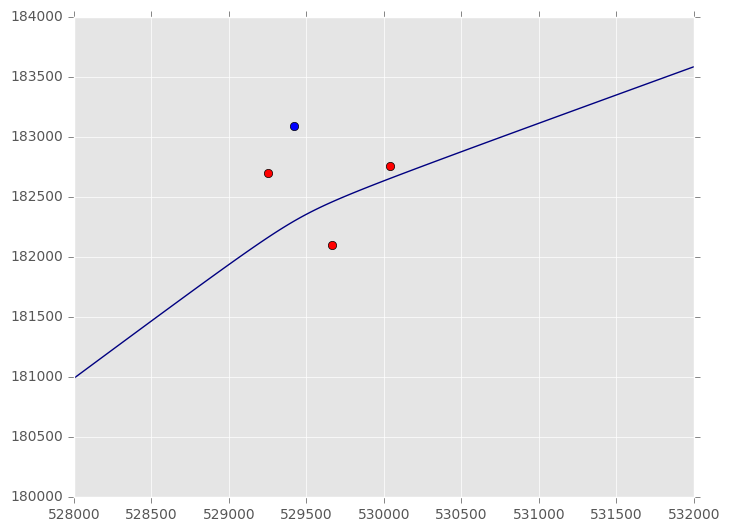

False
False
[[ 529252.743       182699.11             0.        ]
 [ 530037.651       182756.972         1600.24173967]
 [ 529665.057       182099.838         2311.52082854]]


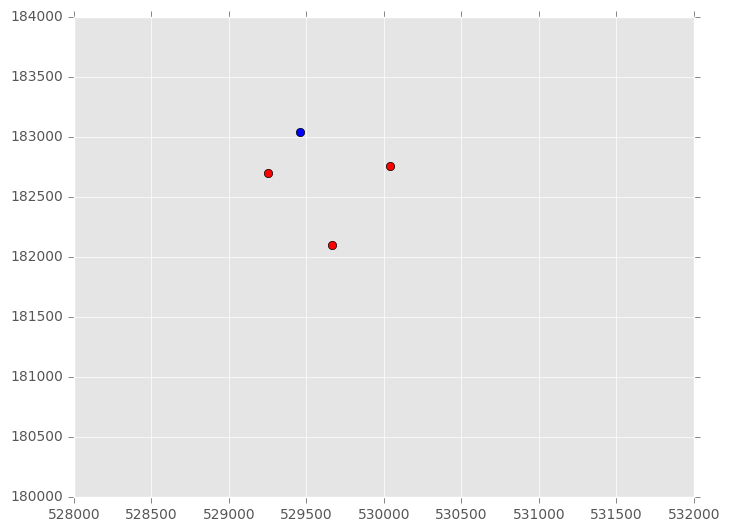

False
False
[[  5.29665057e+05   1.82099838e+05   0.00000000e+00]
 [  5.30037651e+05   1.82756972e+05   2.59630958e+02]
 [  5.29252743e+05   1.82699110e+05   7.61951122e+02]
 [  5.29212615e+05   1.81930304e+05   2.05229907e+03]]


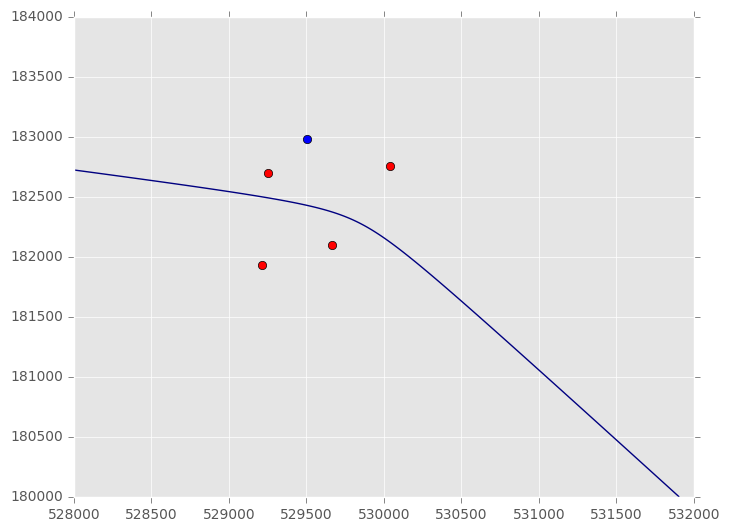

False
[[ 529252.05        182699.093            0.        ]
 [ 529664.391       182098.708         1310.85554248]
 [ 530038.345       182756.99          1886.14610712]]


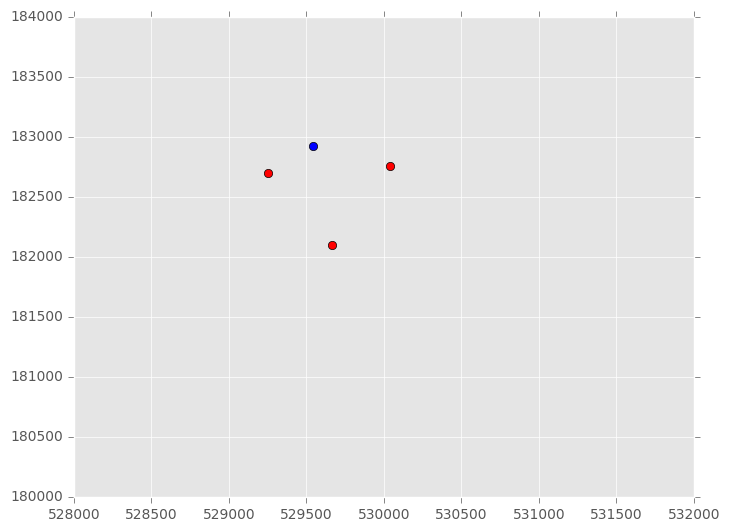

[[ 529252.05        182699.093            0.        ]
 [ 530038.345       182756.99           956.95691292]
 [ 529665.113       182097.614         1024.95117503]]


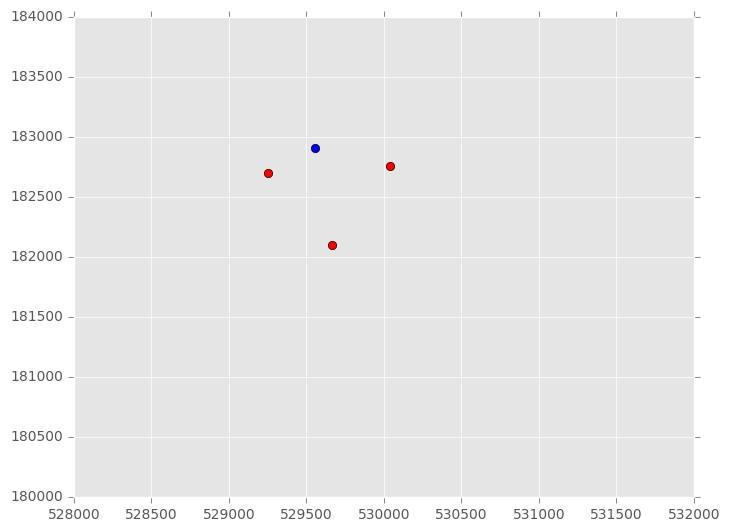

[[  5.30039038e+05   1.82757008e+05   0.00000000e+00]
 [  5.29665113e+05   1.82097614e+05   7.41034328e+02]
 [  5.29252050e+05   1.82699093e+05   2.58136649e+02]]


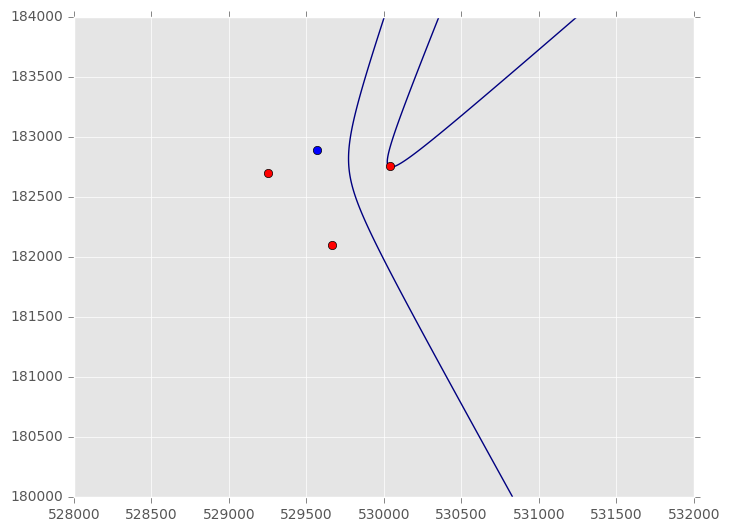

[[  5.30039038e+05   1.82757008e+05   0.00000000e+00]
 [  5.29251384e+05   1.82697963e+05   1.86660557e+02]
 [  5.29665113e+05   1.82097614e+05   1.31284306e+03]]


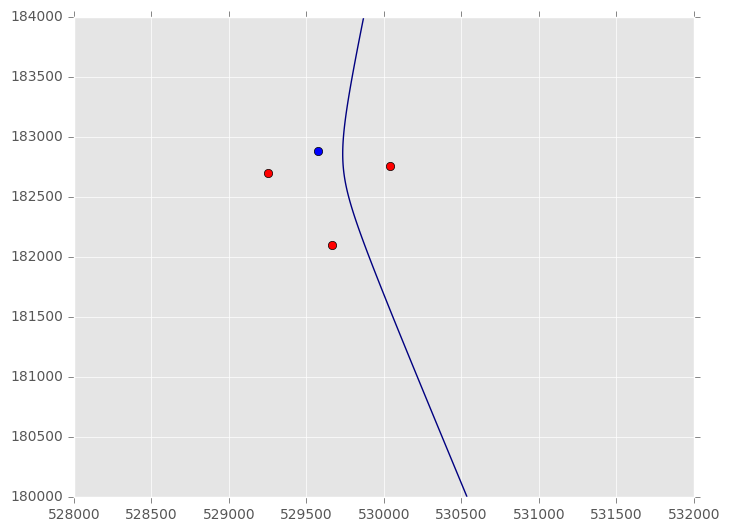

False
False
False
[[  5.30039038e+05   1.82757008e+05   0.00000000e+00]
 [  5.29666501e+05   1.82097649e+05   9.77495014e+01]
 [  5.29252078e+05   1.82697980e+05   1.86660557e+02]]


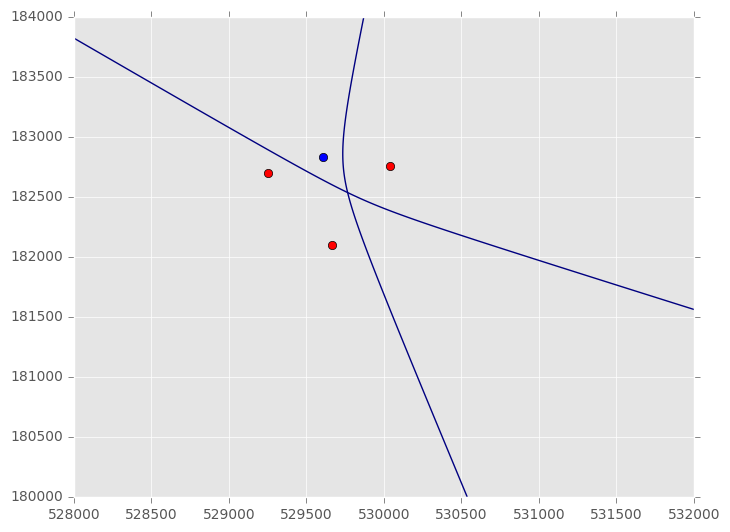

[[ 530038.373       182755.878            0.        ]
 [ 529666.501       182097.649         1026.93869561]
 [ 529252.078       182697.98          1115.84975107]]


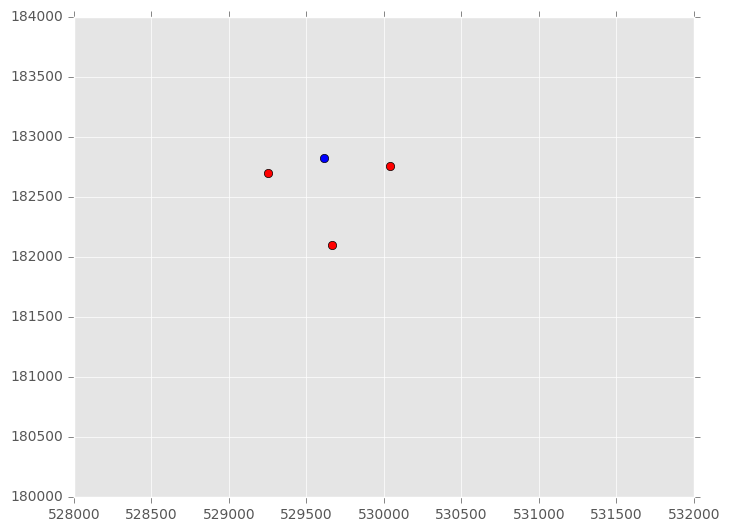

False
False
False
[[  5.29666501e+05   1.82097649e+05   0.00000000e+00]
 [  5.30039067e+05   1.82755896e+05   5.45535325e+02]
 [  5.29251384e+05   1.82697963e+05   4.76046754e+02]]


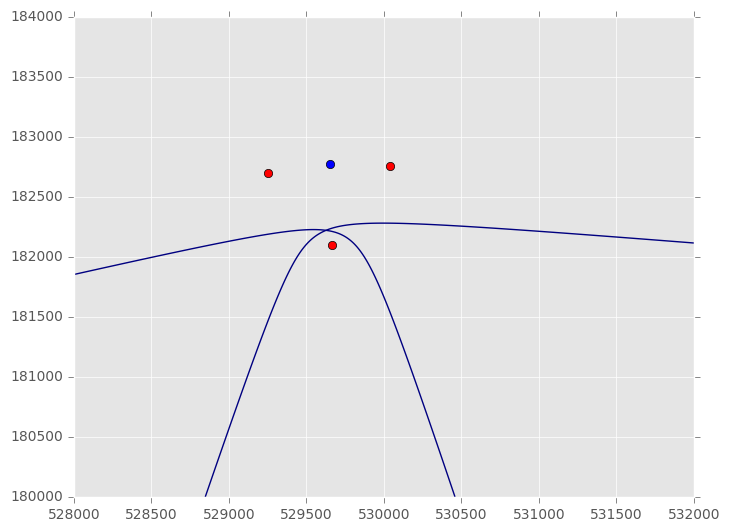

False
[[  5.29670720e+05   1.82095531e+05   0.00000000e+00]
 [  5.29252078e+05   1.82697980e+05   4.04570662e+02]
 [  5.30039067e+05   1.82755896e+05   1.68915280e+03]]


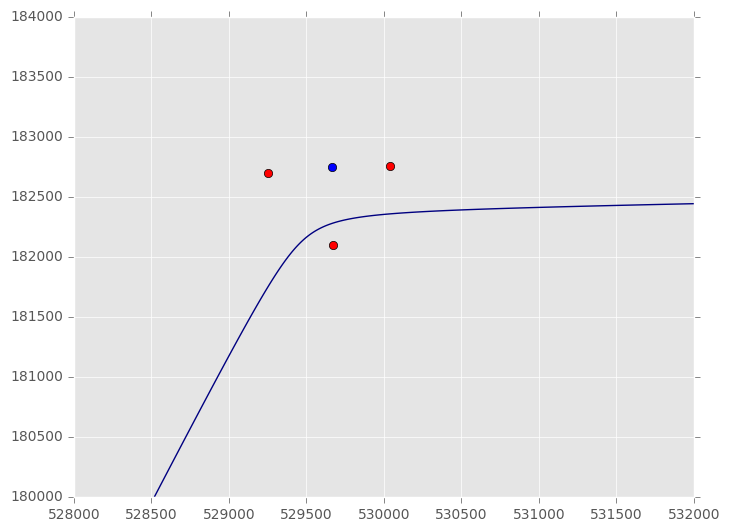

False
False
[[ 529670.026       182095.514            0.        ]
 [ 530037.708       182754.748          831.4396928 ]
 [ 529252.771       182697.998         1333.75985641]]


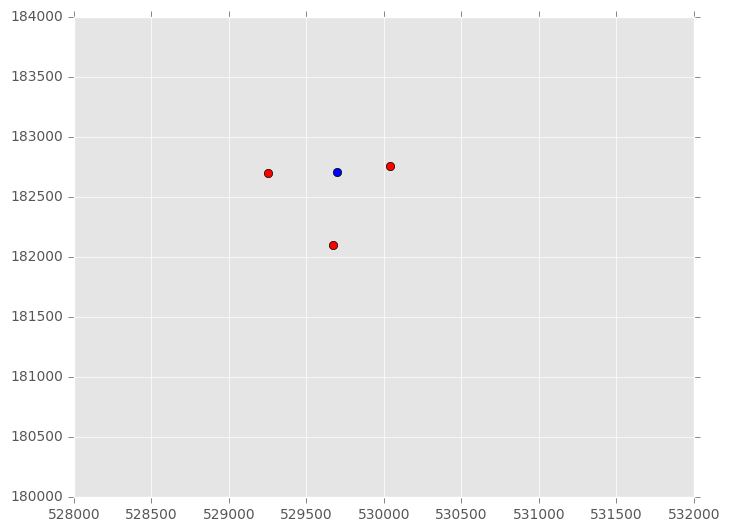

False
False
False
False
False
[[ 530037.737       182753.636            0.        ]
 [ 529252.05        182699.093          758.46929176]
 [ 529668.61        182096.59          1598.7474305 ]]


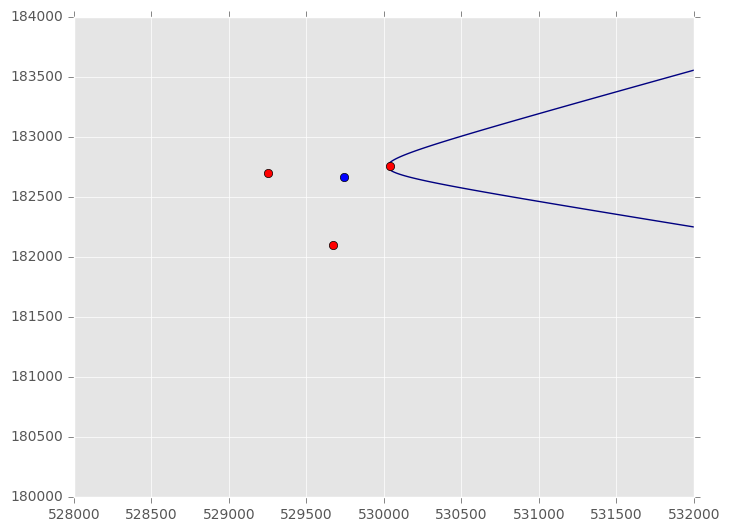

[[ 530037.737       182753.636            0.        ]
 [ 529252.05        182699.093         1115.84975107]
 [ 529668.61        182096.59          1884.65179795]]


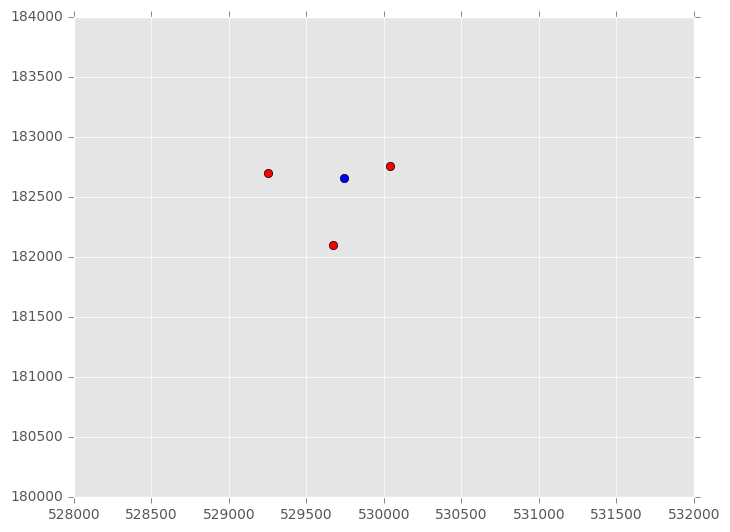

[[  5.30037765e+05   1.82752524e+05   0.00000000e+00]
 [  5.29668610e+05   1.82096590e+05   9.77495014e+01]
 [  5.29252050e+05   1.82699093e+05   2.04503895e+03]]


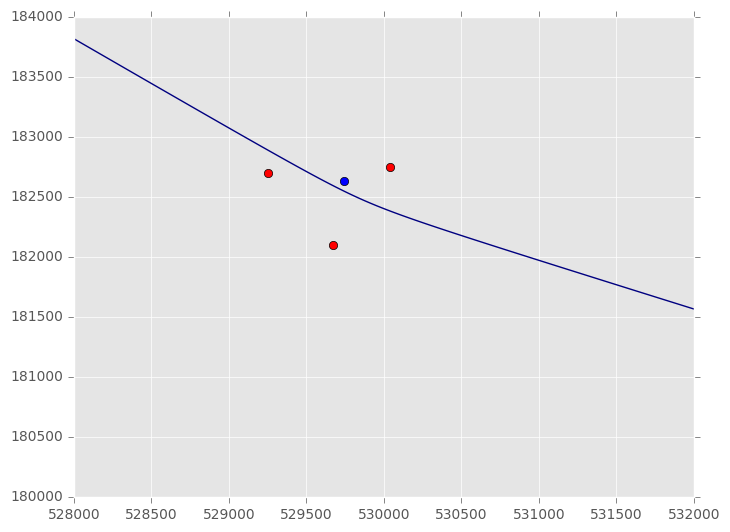

[[ 530037.794       182751.412            0.        ]
 [ 529668.61        182096.59          1312.84306305]
 [ 529252.05        182699.093          829.94538363]]


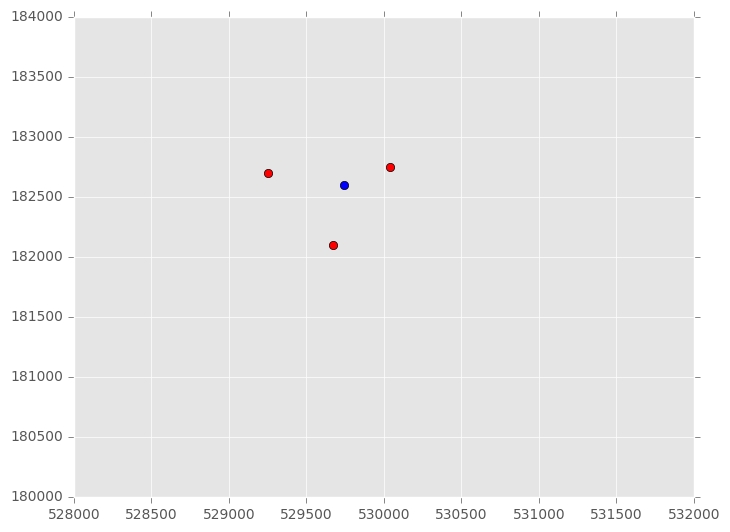

False
False
[[  5.30038459e+05   1.82752542e+05   0.00000000e+00]
 [  5.29252050e+05   1.82699093e+05   4.72564924e+02]
 [  5.29668610e+05   1.82096590e+05   3.38564973e+03]]


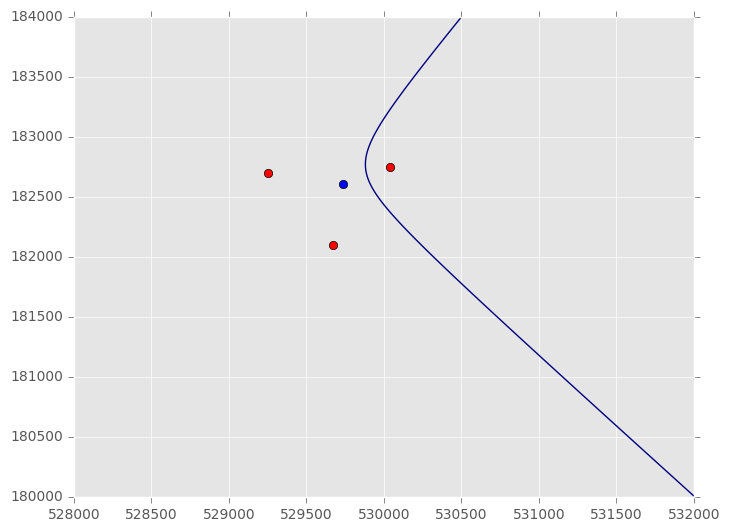

[[ 530038.459       182752.542            0.        ]
 [ 529668.639       182095.478         1312.84306305]
 [ 529252.05        182699.093          829.94538363]]


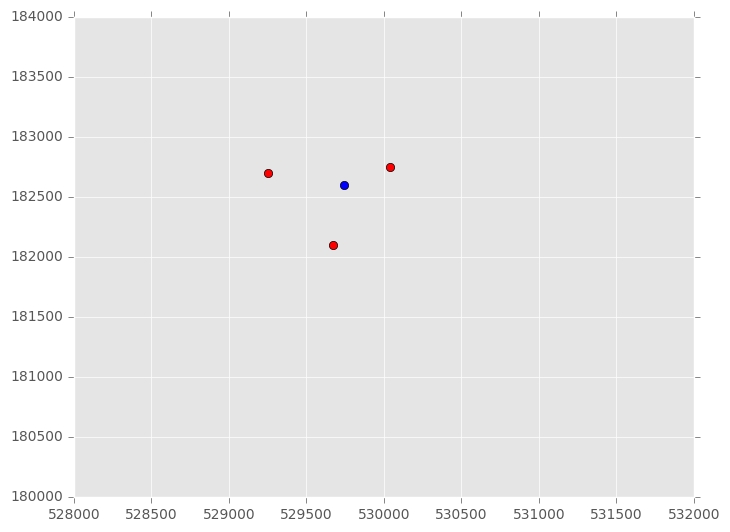

False
False
[[  5.29668639e+05   1.82095478e+05   0.00000000e+00]
 [  5.30038487e+05   1.82751430e+05   8.31439693e+02]
 [  5.29251384e+05   1.82697963e+05   4.76046754e+02]]


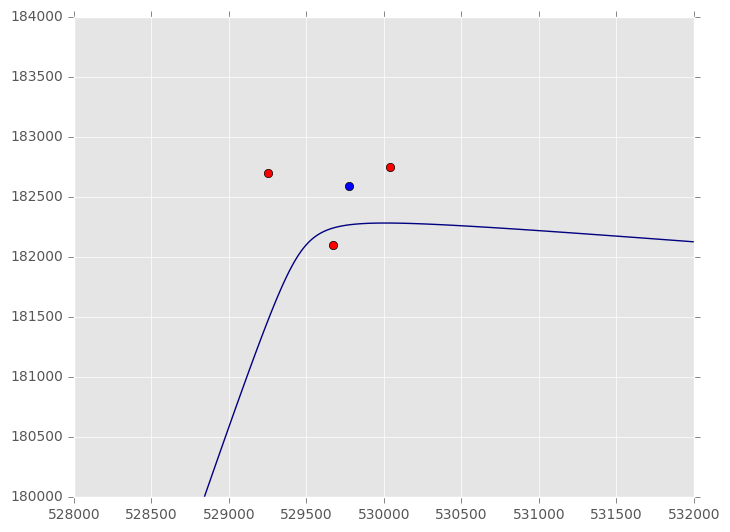

False
False
[[ 529252.078       182697.98             0.        ]
 [ 530038.487       182751.43          1886.14610712]
 [ 529668.639       182095.478         2240.04473668]]


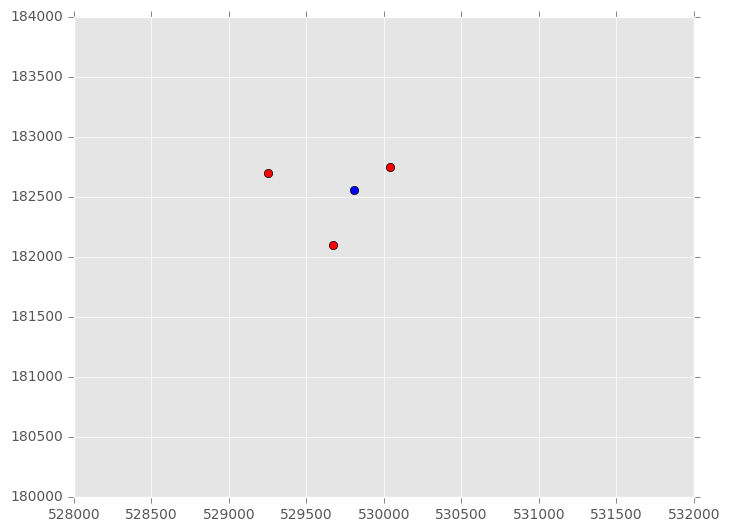

[[ 529667.917       182096.572            0.        ]
 [ 530038.487       182751.43          1117.34406024]
 [ 529252.05        182699.093          761.95112151]]


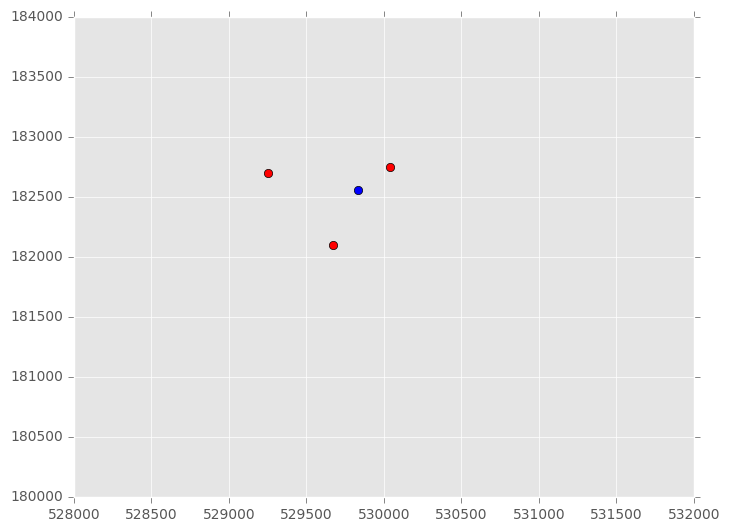

False
False
False
False
False
False
False
[[ 530034.962       182753.565            0.        ]
 [ 529666.529       182096.537          669.5582363 ]
 [ 529252.715       182700.222         1973.56285341]]


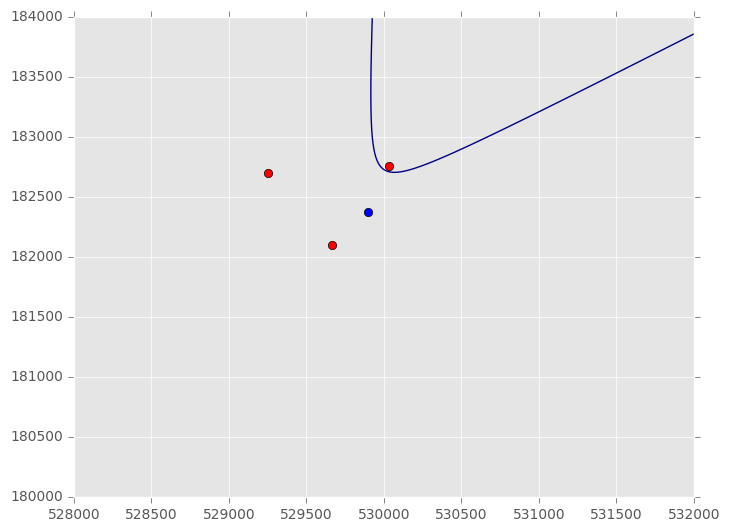

[[  5.29666529e+05   1.82096537e+05   0.00000000e+00]
 [  5.30035656e+05   1.82753583e+05   4.74059233e+02]
 [  5.29251993e+05   1.82701317e+05   2.19147296e+03]]


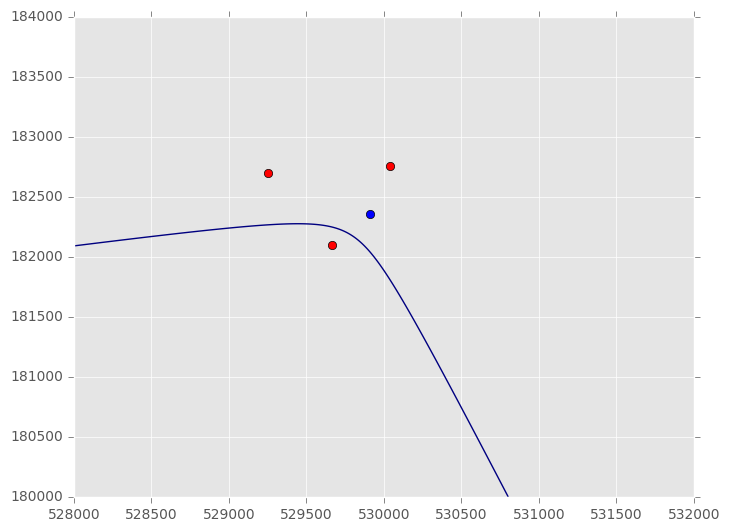

False
False
[[  5.30034934e+05   1.82754677e+05   0.00000000e+00]
 [  5.29666529e+05   1.82096537e+05   6.69558236e+02]
 [  5.29251993e+05   1.82701317e+05   4.72564924e+02]]


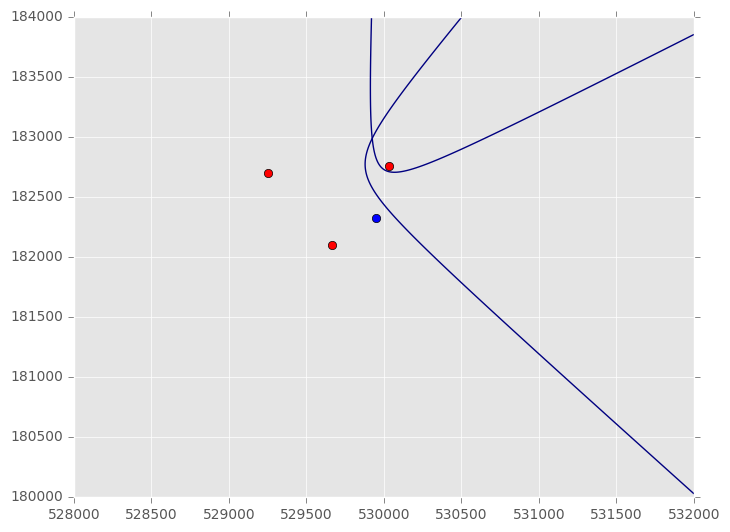

[[ 529666.529       182096.537            0.        ]
 [ 530034.934       182754.677         1403.24842769]
 [ 529251.993       182701.317         2548.85341806]]


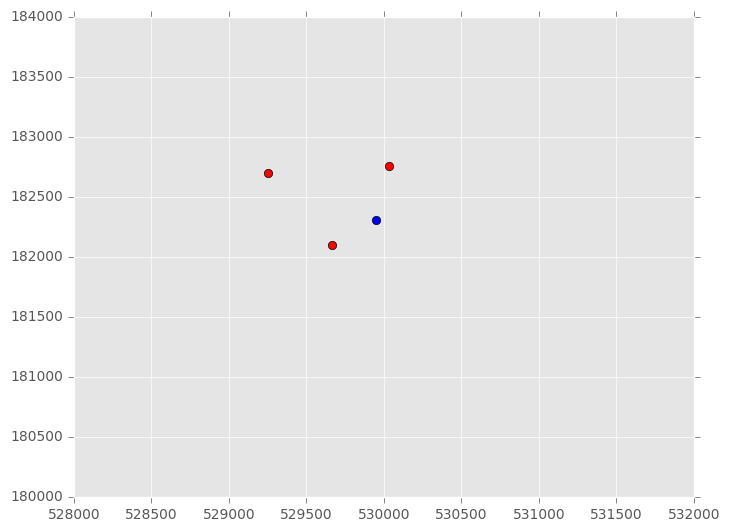

[[  5.29666529e+05   1.82096537e+05   0.00000000e+00]
 [  5.29251965e+05   1.82702429e+05   4.76046754e+02]
 [  5.30034934e+05   1.82754677e+05   8.31439693e+02]]


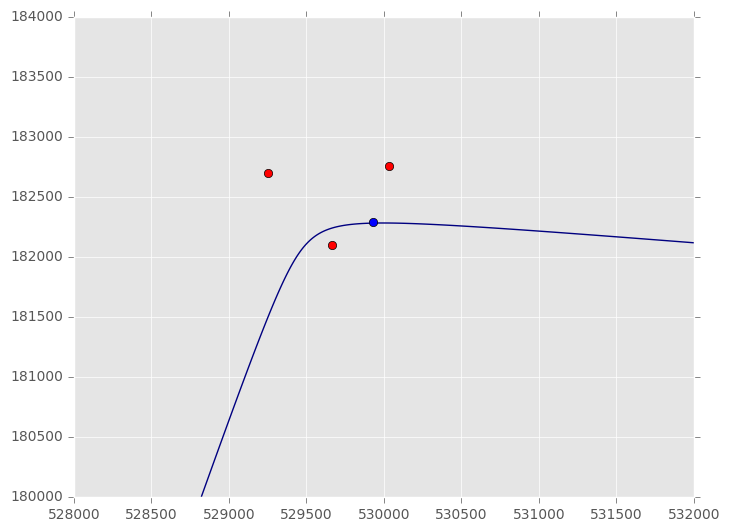

False
[[  5.30035656e+05   1.82753583e+05   0.00000000e+00]
 [  5.29666501e+05   1.82097649e+05   9.77495014e+01]
 [  5.29251965e+05   1.82702429e+05   5.44041016e+02]]


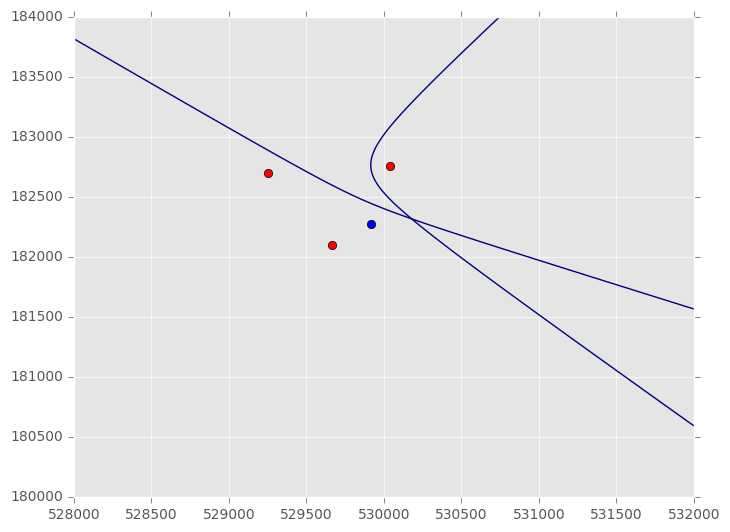

[[ 529251.271       182702.411            0.        ]
 [ 530035.656       182753.583         1886.14610712]
 [ 529666.501       182097.649         1954.14036923]]


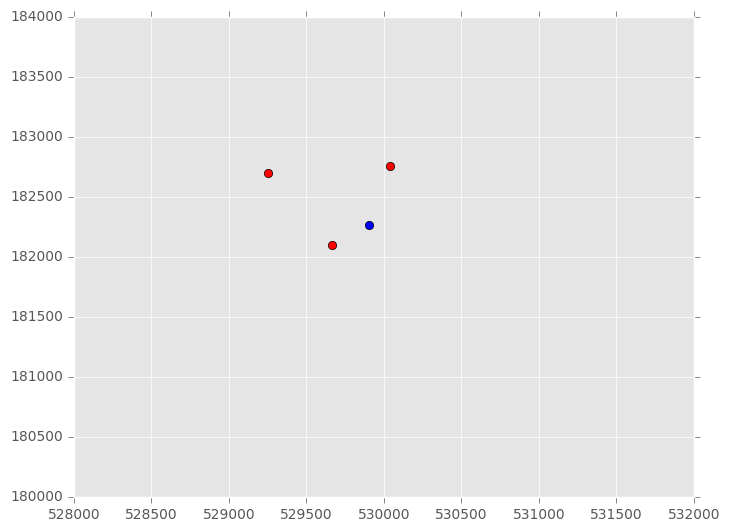

False
False
False
False
False
[[ 529667.223       182096.555            0.        ]
 [ 529251.299       182701.299         1047.85548896]
 [ 530036.349       182753.601         2332.43762189]]


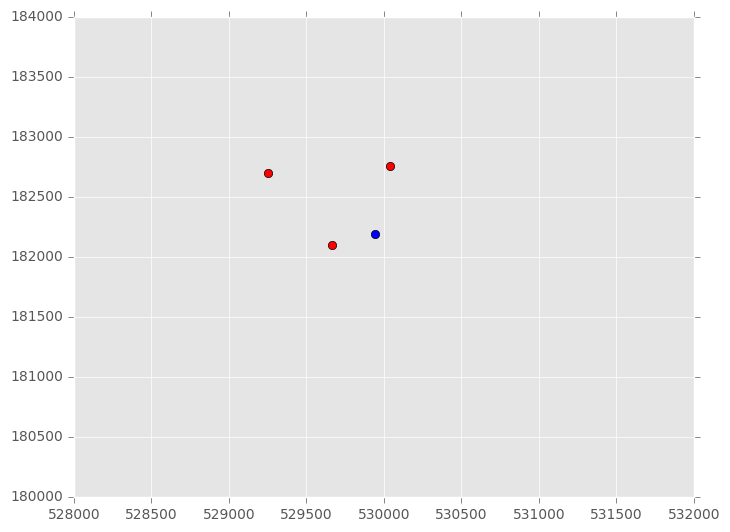

[[ 530036.349       182753.601            0.        ]
 [ 529667.194       182097.667          669.5582363 ]
 [ 529251.299       182701.299         1973.56285341]]


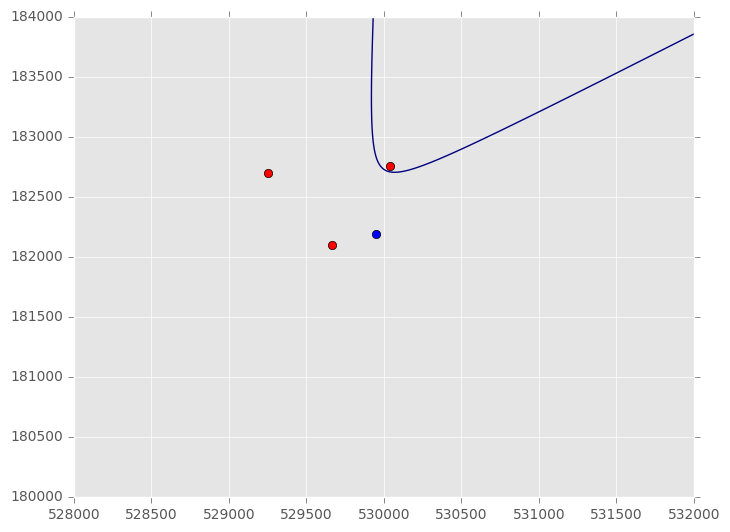

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
[[  5.30038373e+05   1.82755878e+05   0.00000000e+00]
 [  5.29666444e+05   1.82099873e+05   9.77495014e+01]
 [  5.29250493e+05   1.82705729e+05   5.44041016e+02]]


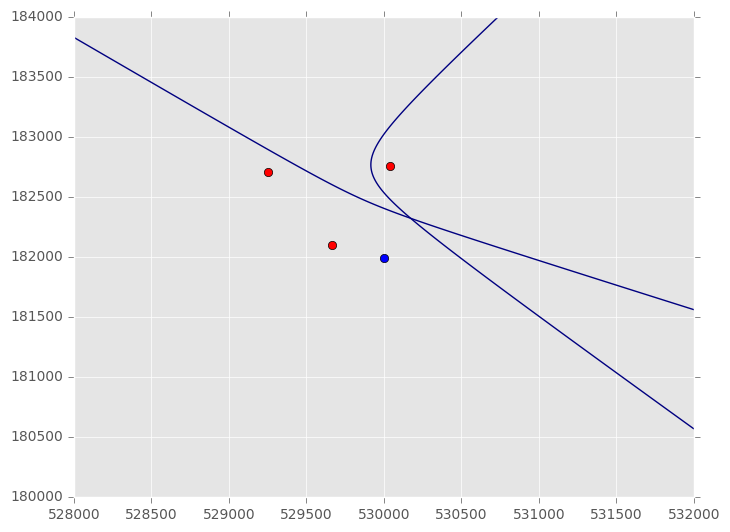

False
False
False
False
False
False
False
False
False
False
False
[[  5.29248525e+05   1.82701228e+05   0.00000000e+00]
 [  5.29667746e+05   1.82103244e+05   4.53142440e+02]
 [  5.30036349e+05   1.82753601e+05   3.85148178e+02]]


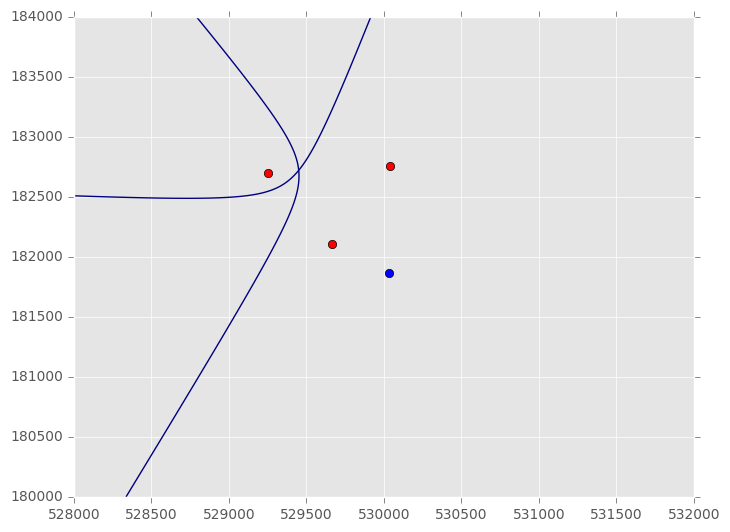

False
False
[[ 529668.412       182104.374            0.        ]
 [ 529248.553       182700.116         1905.5685913 ]
 [ 530036.349       182753.601         2618.34198934]]


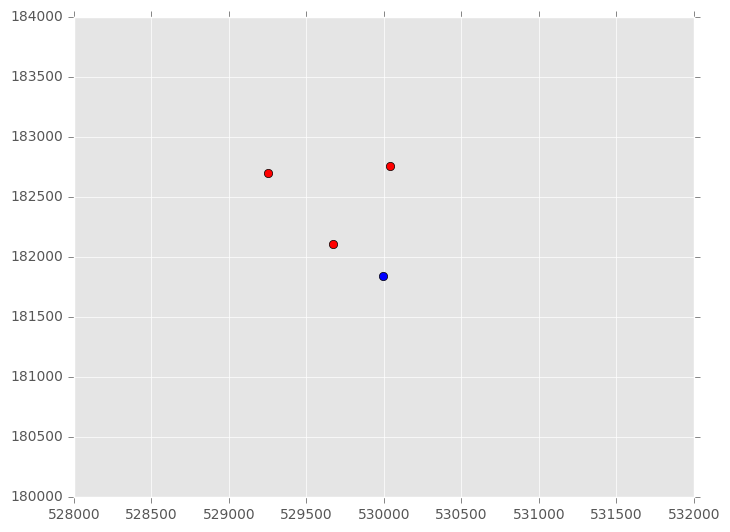

False
False
[[  5.29669105e+05   1.82104392e+05   0.00000000e+00]
 [  5.29248553e+05   1.82700116e+05   4.04570662e+02]
 [  5.30039124e+05   1.82753672e+05   1.33177234e+03]]


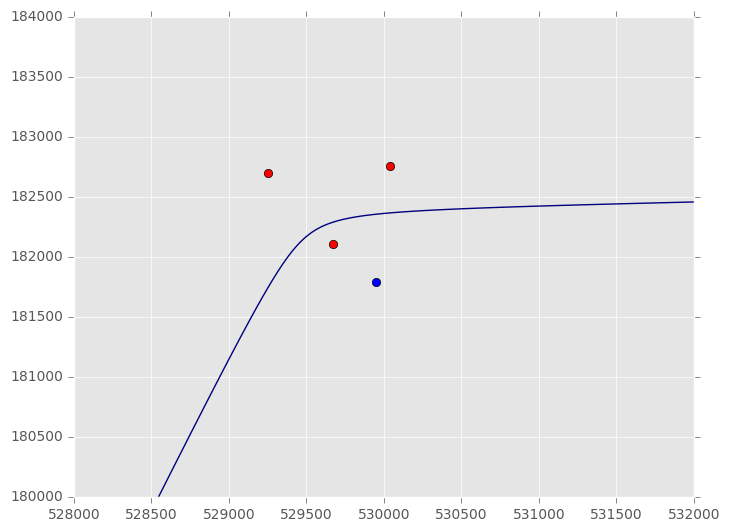

False
False
False
False
[[  5.29669827e+05   1.82103298e+05   0.00000000e+00]
 [  5.29227963e+05   1.81927356e+05   1.93920685e+02]
 [  5.29248553e+05   1.82700116e+05   4.76046754e+02]]


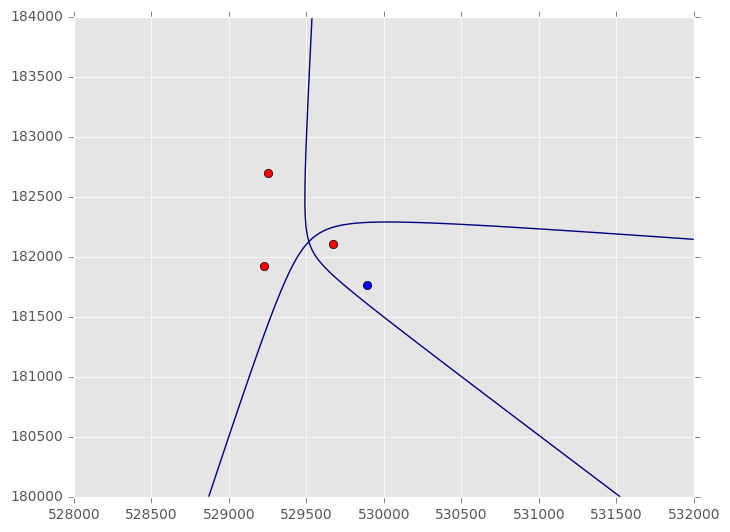

[[  5.29669827e+05   1.82103298e+05   0.00000000e+00]
 [  5.30039095e+05   1.82754784e+05   8.31439693e+02]
 [  5.29248553e+05   1.82700116e+05   4.76046754e+02]]


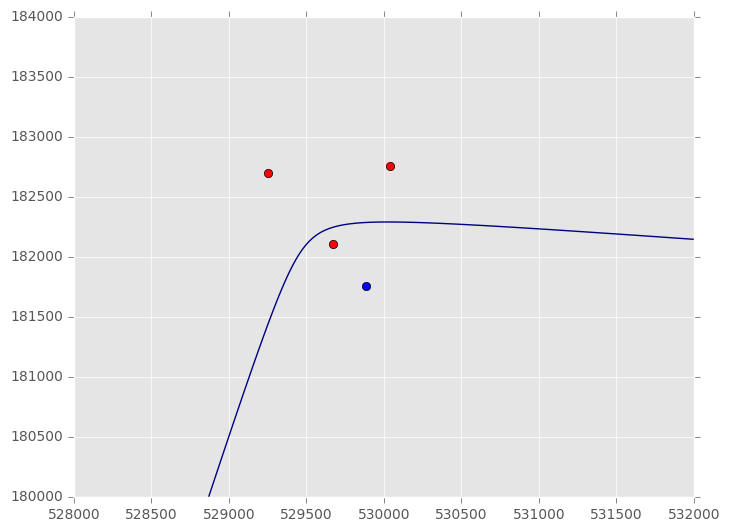

False
False
False
False
False
False
False
False
[[ 529249.247       182700.134            0.        ]
 [ 530039.095       182754.784          671.05254547]
 [ 529669.799       182104.41          1024.95117503]]


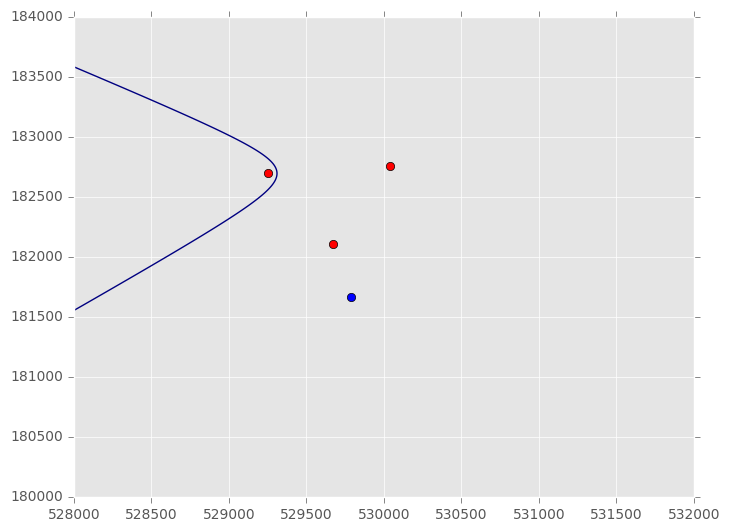

False
[[ 529669.799       182104.41             0.        ]
 [ 530039.095       182754.784         2618.34198934]
 [ 529248.553       182700.116         2262.94905061]]


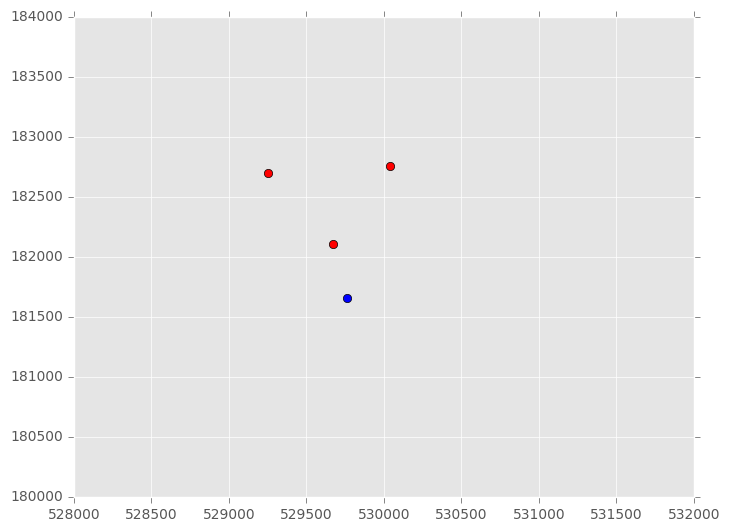

False
False
False
False
False
[[  5.29670549e+05   1.82102203e+05   0.00000000e+00]
 [  5.30038459e+05   1.82752542e+05   1.88154866e+02]
 [  5.29249162e+05   1.82703470e+05   2.54885342e+03]]


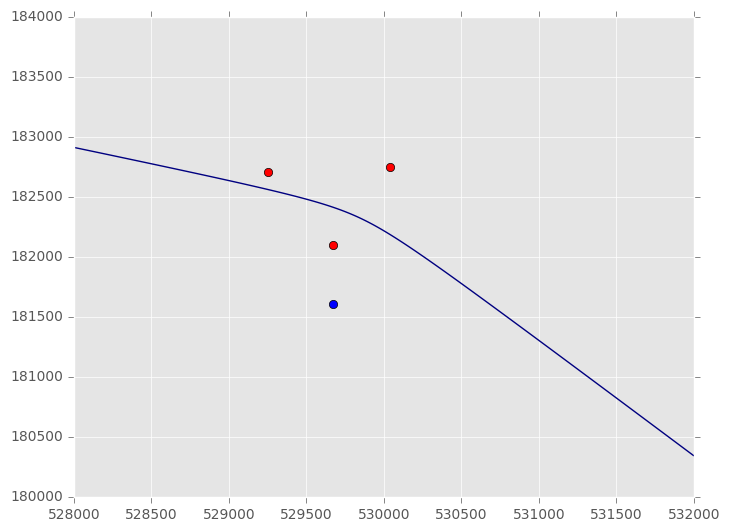

False
False
False
False
False
False
[[ 529669.799       182104.41             0.        ]
 [ 529223.305       181919.449         1480.49033838]
 [ 530039.124       182753.672         2046.53325445]
 [ 529249.105       182705.694         1977.04468316]]


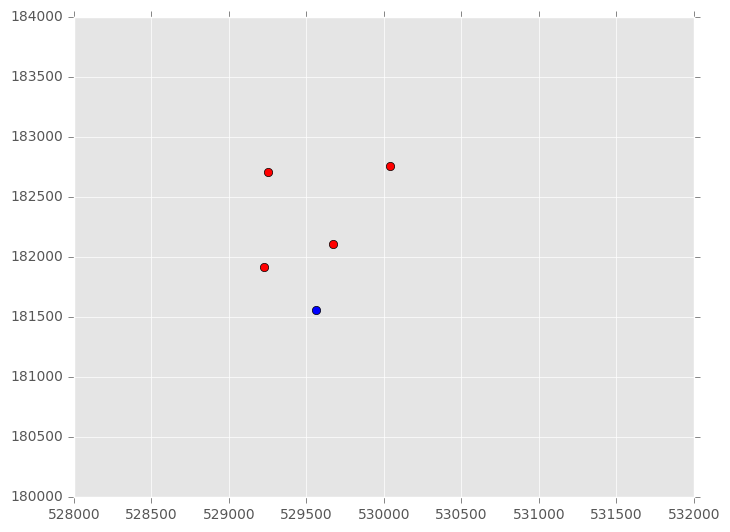

[[ 529669.799       182104.41             0.        ]
 [ 530039.124       182753.672         1045.86796838]
 [ 529248.412       182705.676         1333.75985641]]


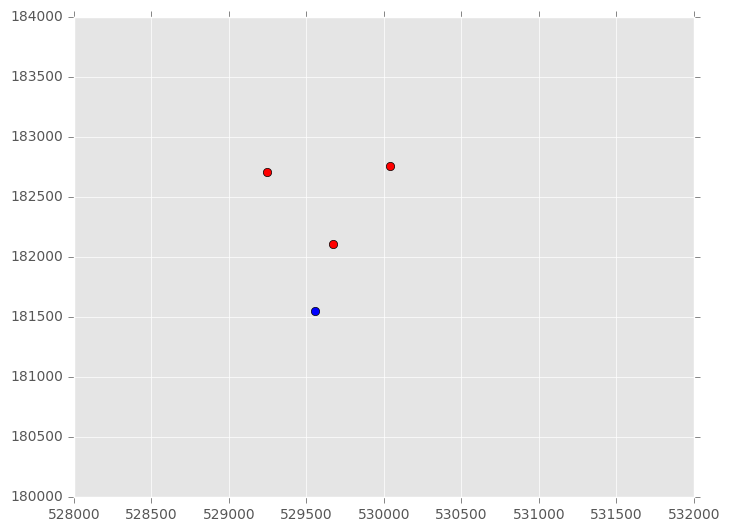

False
False
False
False
False
False
False
[[  5.29671908e+05   1.82103351e+05   0.00000000e+00]
 [  5.29250379e+05   1.82710177e+05   4.76046754e+02]
 [  5.29232734e+05   1.81930816e+05   5.51301144e+02]]


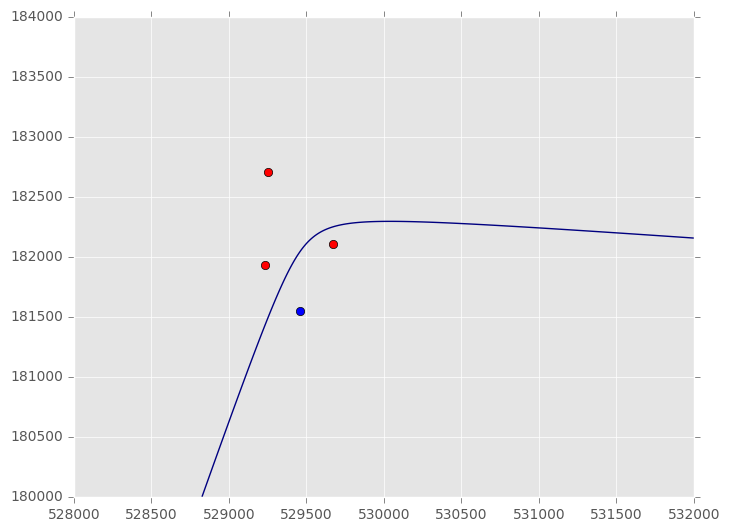

False
False
False
False
False
False
False
[[  5.29670521e+05   1.82103315e+05   0.00000000e+00]
 [  5.30038459e+05   1.82752542e+05   8.31439693e+02]
 [  5.29251767e+05   1.82710213e+05   4.76046754e+02]]


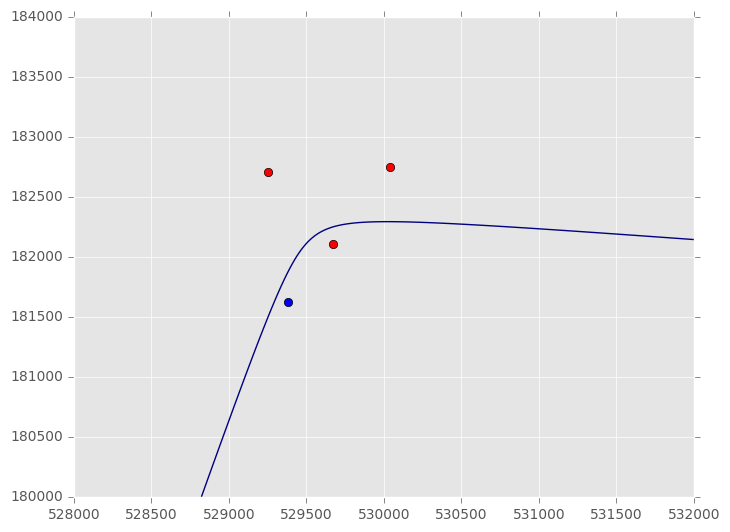

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
[[ 529672.886       182092.248            0.        ]
 [ 5

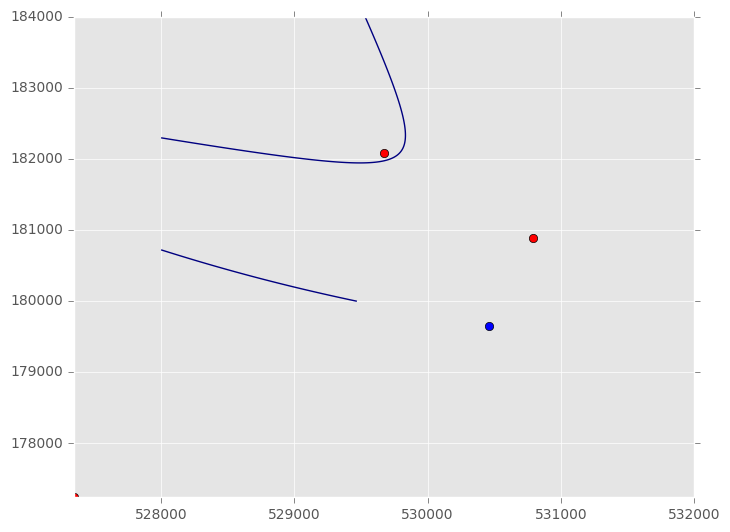

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
[[ 530802.058       180888.271            0.        ]
 [ 529252.134       182695.756         2210.30628093]
 [ 527345.257       177247.593         3693.55797763]]


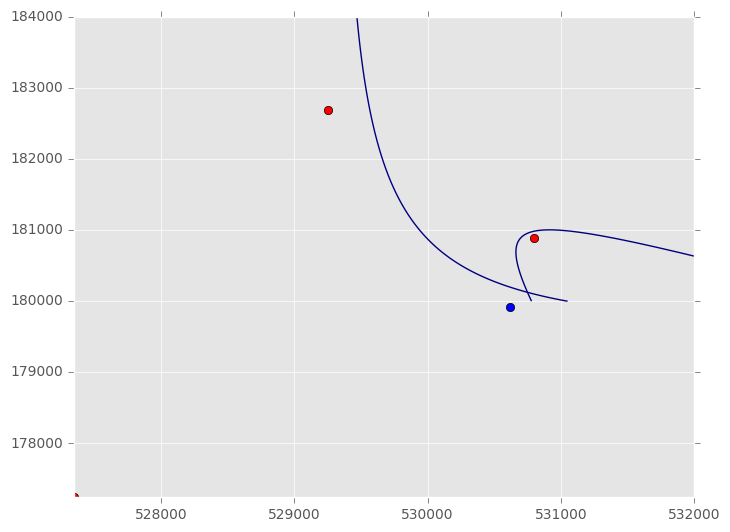

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
[[ 530797.086       180892.594            0.        ]
 [ 529217.5         181929.316         2920.91932099]
 [ 530041.319       182749.277         3332.48258472]]


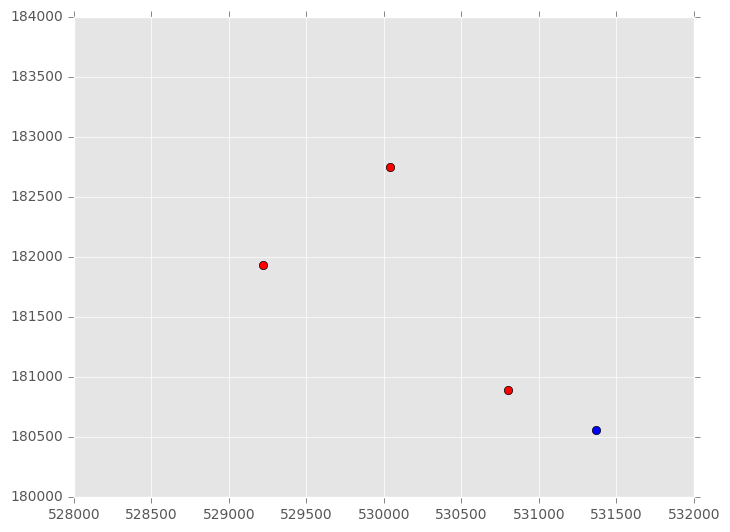

[[ 532014.377       181395.869            0.        ]
 [ 530797.086       180892.594       233613.07246879]
 [ 529252.276       182690.196       287634.04606143]]


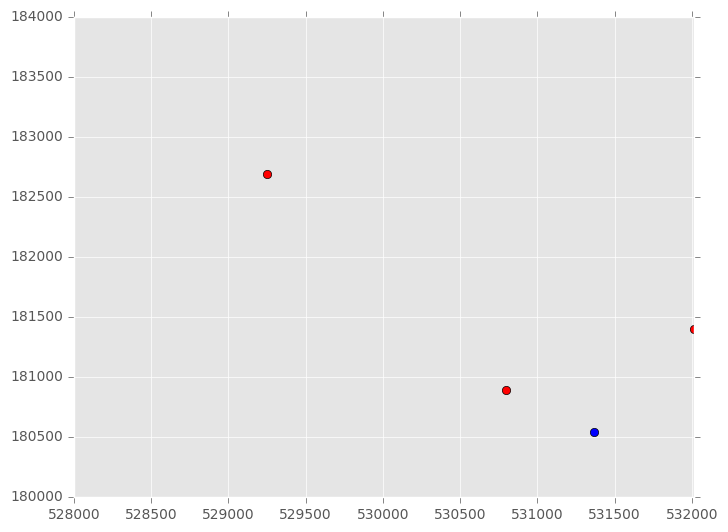

[[ 532014.377       181395.869            0.        ]
 [ 530797.086       180892.594        78081.09657768]
 [ 529672.192       182092.231       194918.88602311]]


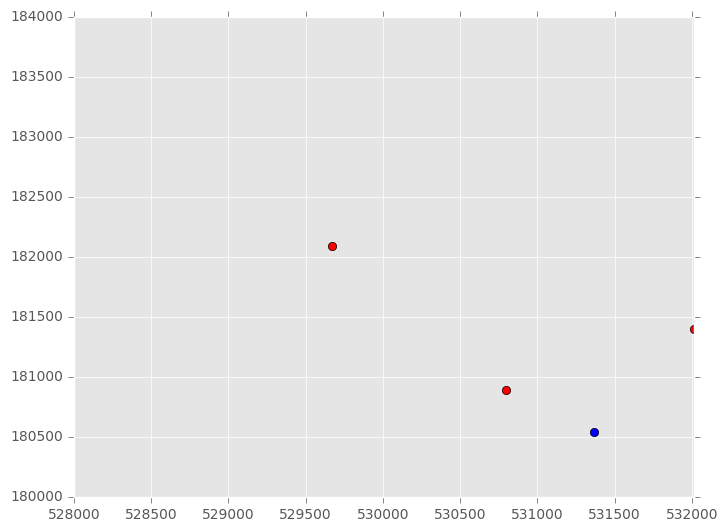

[[ 530797.78        180892.612            0.        ]
 [ 530041.984       182750.407         2117.38902307]
 [ 529672.192       182092.231         2488.1186057 ]]


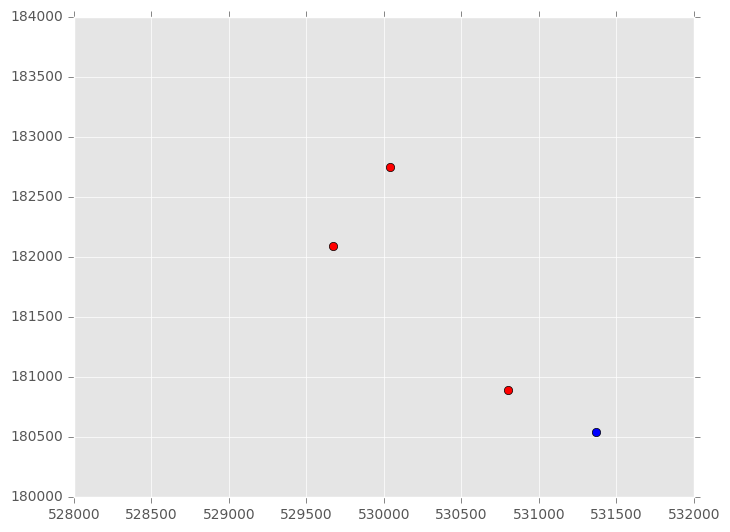

False
False
[[ 532014.377       181395.869            0.        ]
 [ 530797.058       180893.706       643456.98320392]
 [ 530041.29        182750.389       646958.64457454]]


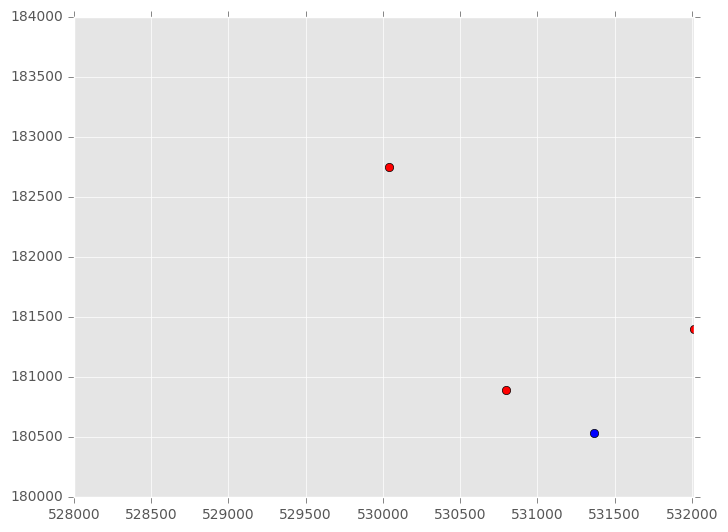

[[  532014.377        181395.869             0.        ]
 [  530797.058        180893.706       1170807.58895973]
 [  529672.192        182092.231       1288002.75886447]
 [  530041.29         182750.389       1174023.3459629 ]
 [  529252.276        182690.196       1227187.2735838 ]]


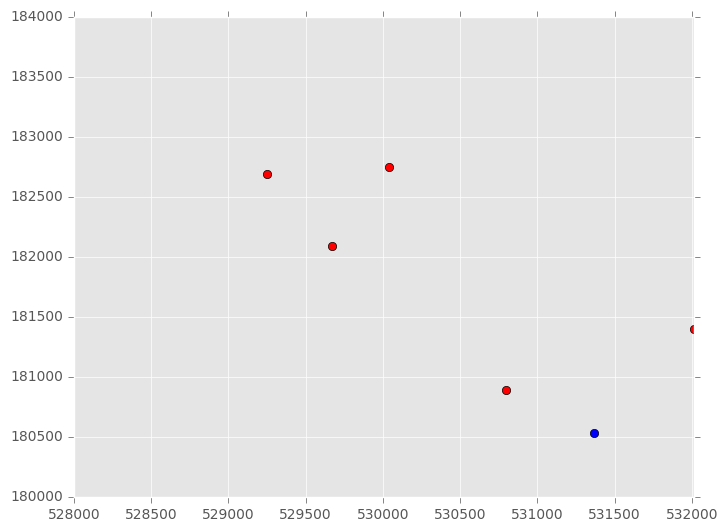

False
[[ 532014.377       181395.869            0.        ]
 [ 530797.058       180893.706       868320.76820091]
 [ 529672.192       182092.231       984872.65327889]
 [ 530041.262       182751.501       873037.52313317]
 [ 529252.304       182689.084       924700.45282498]]


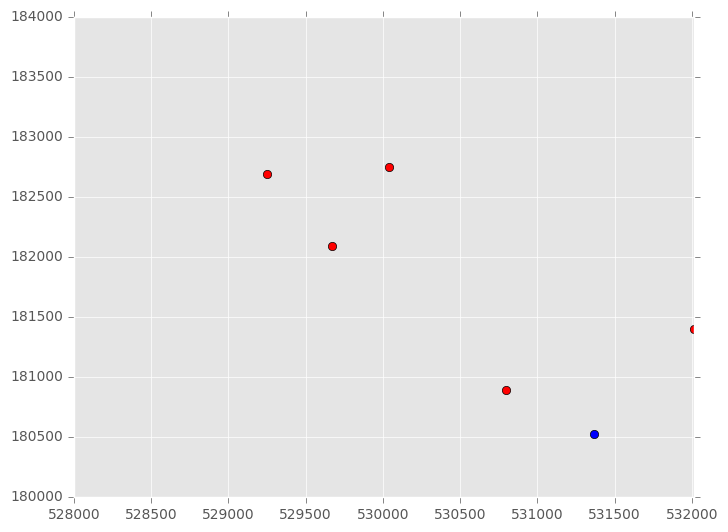

[[ 532014.377       181395.869            0.        ]
 [ 530797.058       180893.706       347545.96289638]
 [ 530041.262       182751.501       351405.00472631]]


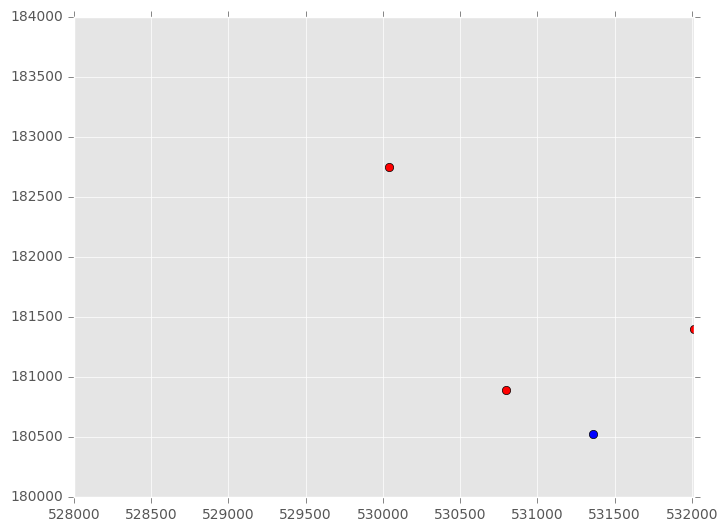

[[ 532014.377       181395.869            0.        ]
 [ 530797.058       180893.706       177004.00771431]
 [ 529254.357       182690.249       233383.69233838]]


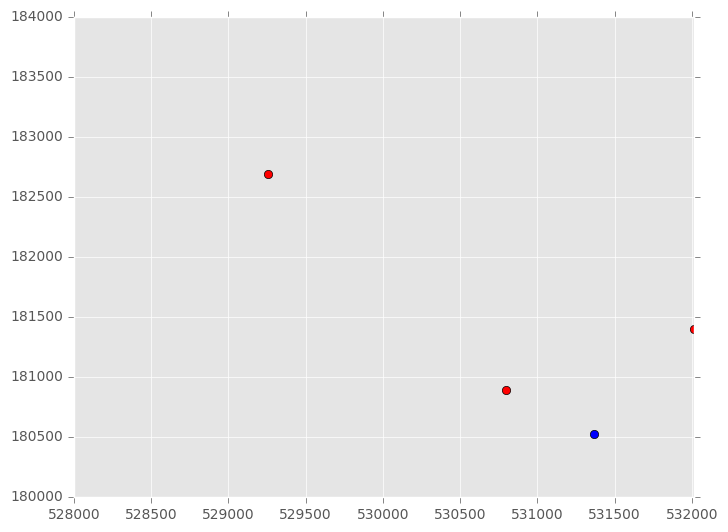

[[ 532014.377       181395.869            0.        ]
 [ 530796.335       180894.8         220175.56719879]
 [ 530040.568       182751.483       223033.94374265]
 [ 529254.357       182690.249       276555.25182286]]


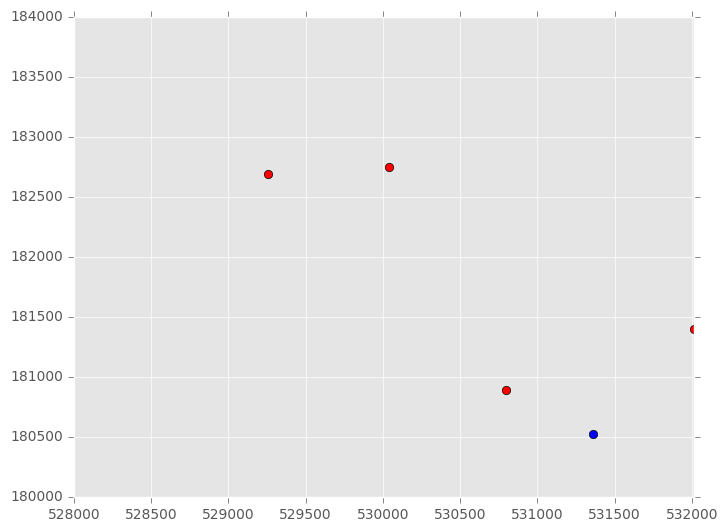

[[ 530796.335       180894.8              0.        ]
 [ 529672.192       182092.231         1344.50113592]
 [ 530040.568       182751.483         2117.38902307]
 [ 529254.357       182690.249         1352.59317859]]


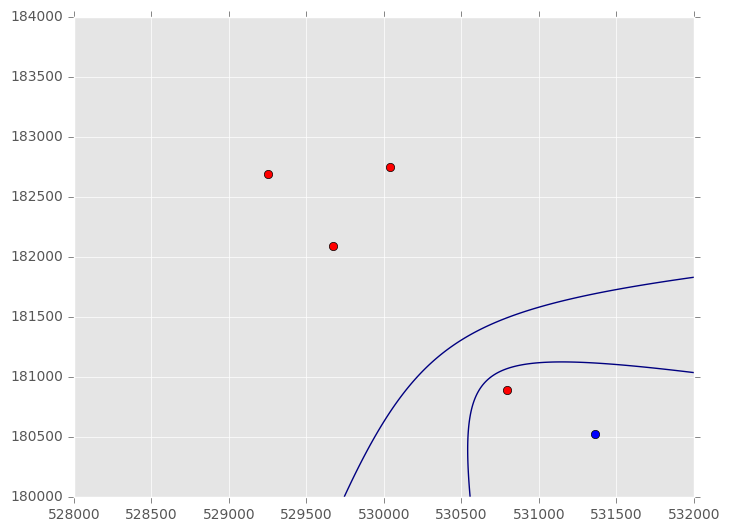

[[ 530796.335       180894.8              0.        ]
 [ 529672.192       182092.231         1344.50113592]
 [ 529256.409       182691.414         1352.59317859]]


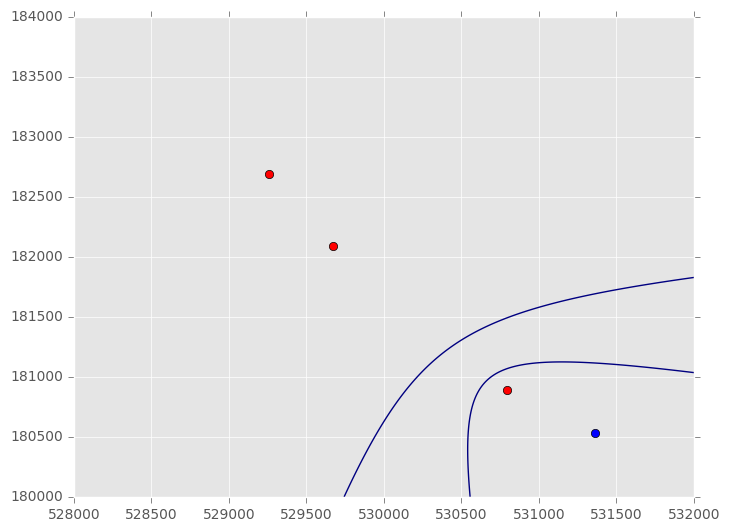

[[ 530796.335       180894.8              0.        ]
 [ 529672.192       182092.231         1344.50113592]
 [ 529256.409       182691.414         1352.59317859]]


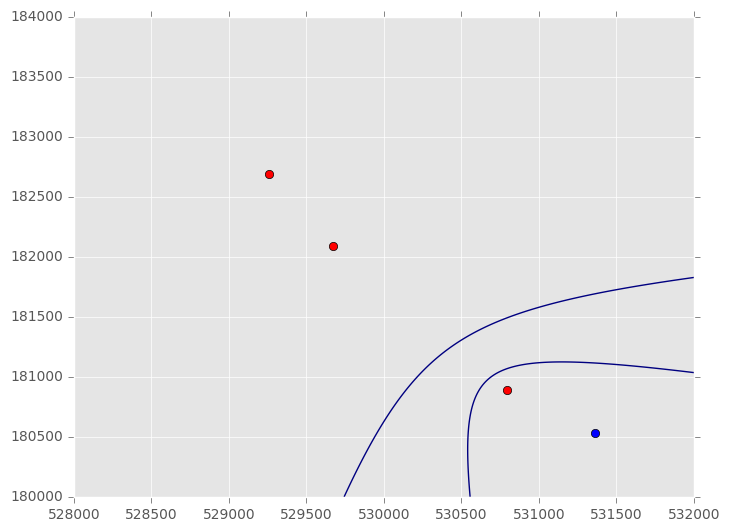

[[ 530796.335       180894.8              0.        ]
 [ 529672.192       182092.231         3631.73607549]
 [ 529256.409       182691.414         3425.39984258]]


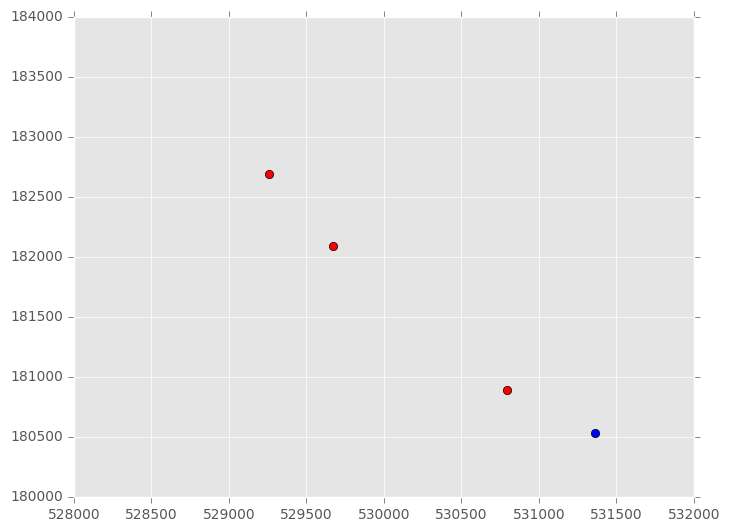

False
[[ 530796.335       180894.8              0.        ]
 [ 530040.539       182752.595         2403.29339052]
 [ 529256.409       182691.414         4068.68466934]]


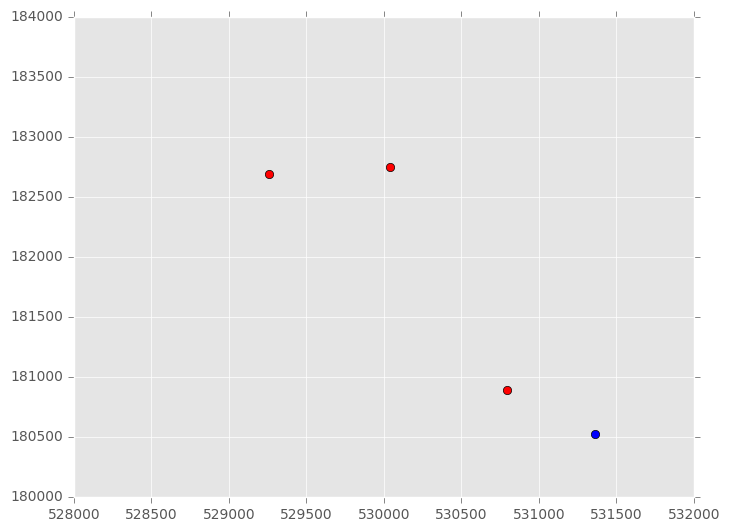

[[ 532014.377       181395.869            0.        ]
 [ 530796.335       180894.8         610149.12439636]
 [ 529672.886       182092.248       725271.48763711]
 [ 530040.539       182752.595       612507.16829719]
 [ 529256.409       182691.414       664170.097989  ]]


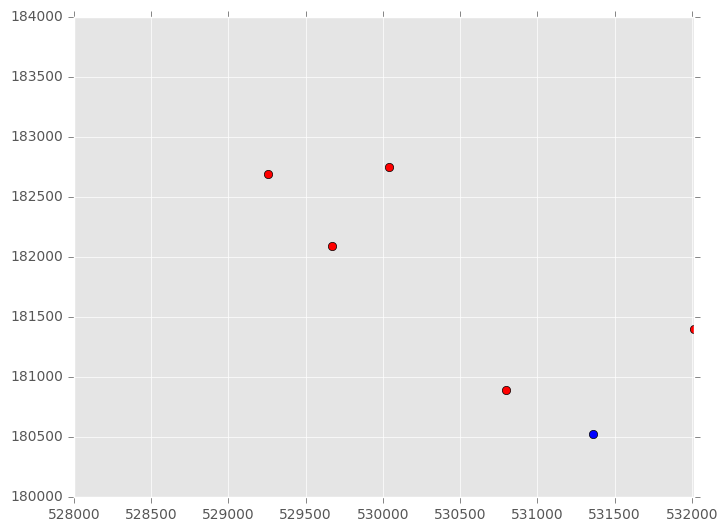

[[ 530796.335       180894.8              0.        ]
 [ 530040.539       182752.595         3904.29131961]
 [ 529254.3         182692.473         6427.39570077]]


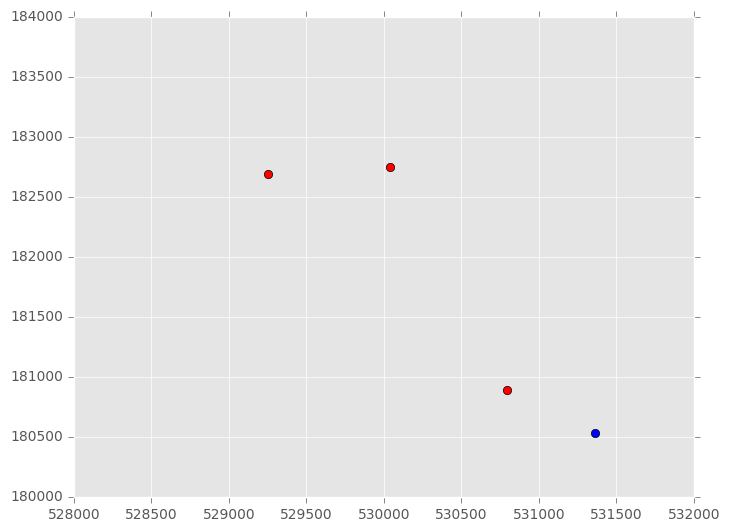

False
False
[[ 530794.948       180894.764            0.        ]
 [ 529673.58        182092.266         2774.02297315]
 [ 530040.539       182752.595         4190.19568706]
 [ 529252.885       182693.55          3711.30421003]]


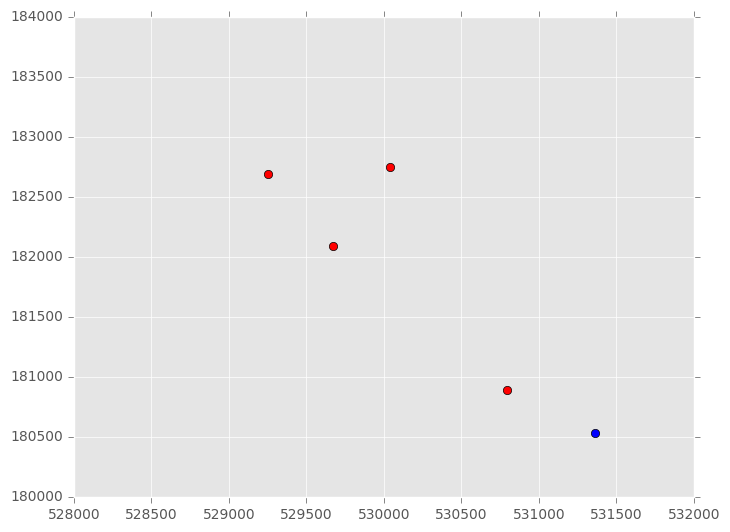

[[  5.30795584e+05   1.80897006e+05   0.00000000e+00]
 [  5.29674217e+05   1.82094508e+05   4.15311942e+02]
 [  5.30040511e+05   1.82753707e+05   1.47410420e+03]]


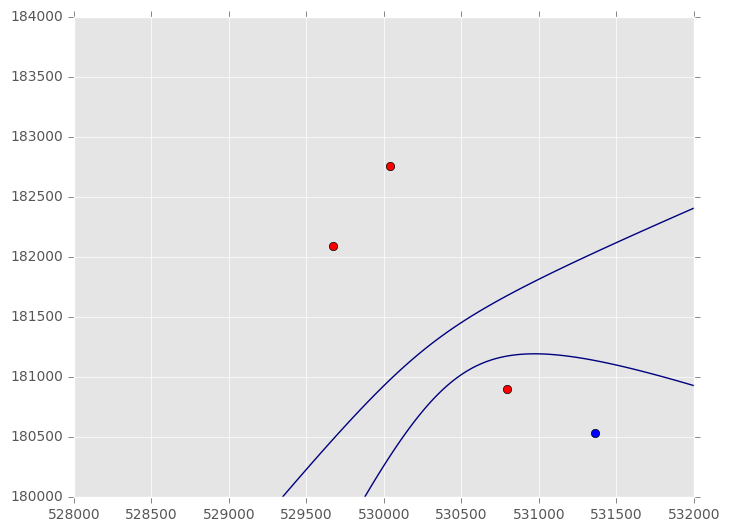

[[ 532014.377       181395.869            0.        ]
 [ 530795.584       180897.006       414447.58487896]
 [ 529674.217       182094.508       530070.28076274]
 [ 530040.511       182753.707       416448.24832048]
 [ 529252.885       182693.55        471399.07823792]]


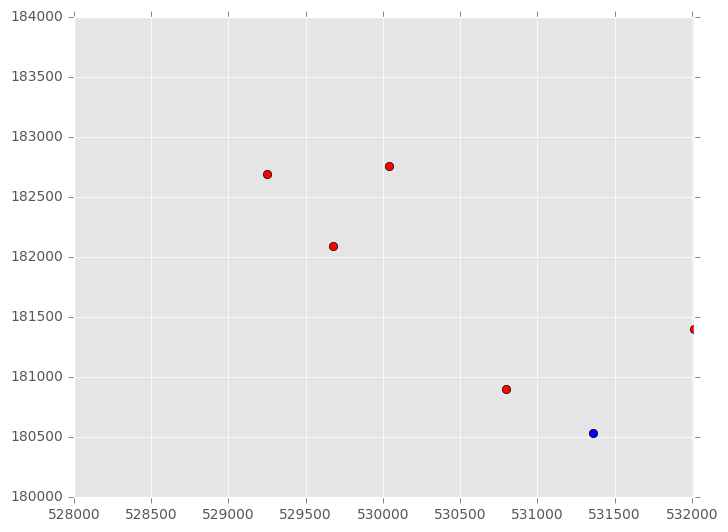

[[ 530795.584       180897.006            0.        ]
 [ 529249.388       182694.574         1638.49754604]
 [ 529674.217       182094.508         2488.1186057 ]
 [ 530040.511       182753.707         3261.00649286]]


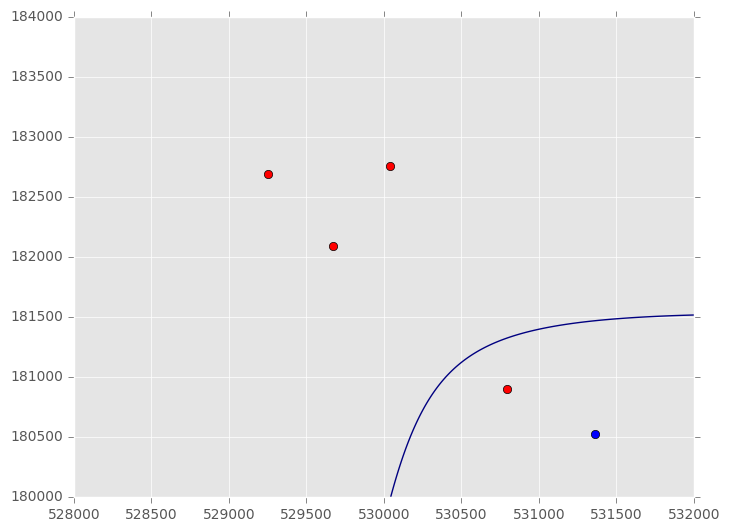

[[ 532014.377       181395.869            0.        ]
 [ 530795.613       180895.894       541532.07620911]
 [ 529672.801       182095.584       658441.34174639]
 [ 529249.388       182694.574       595838.95416919]
 [ 530040.454       182755.931       545033.73757972]]


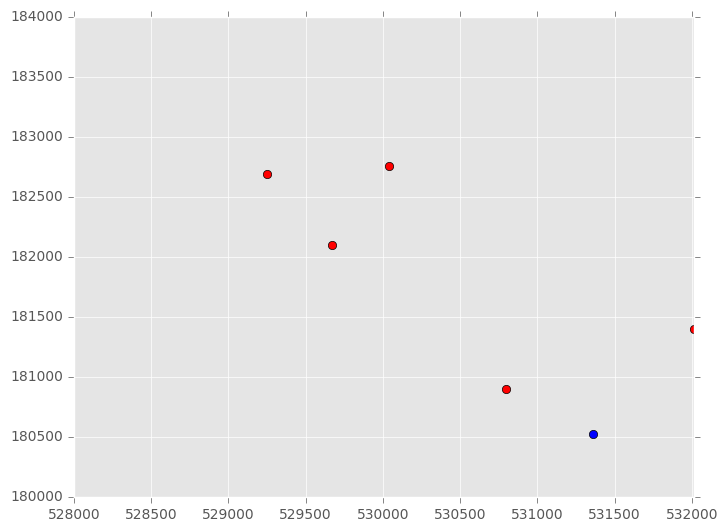

False
False
[[ 530795.613       180895.894            0.        ]
 [ 530042.563       182754.873         1474.10419632]
 [ 529673.494       182095.602         2202.21423826]
 [ 529248.029       182693.427         4068.68466934]]


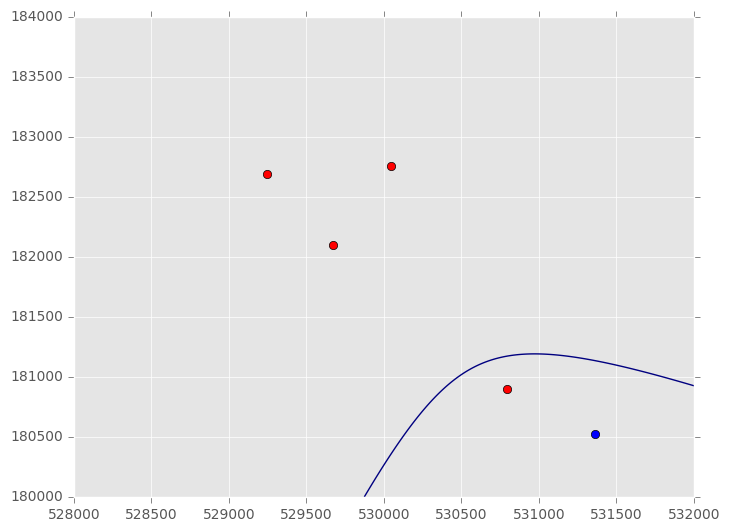

False
False
False
[[ 530797.029       180894.818            0.        ]
 [ 529673.494       182095.602         1273.02504405]
 [ 530043.285       182753.778         2045.91293121]
 [ 529247.279       182695.633         1638.49754604]]


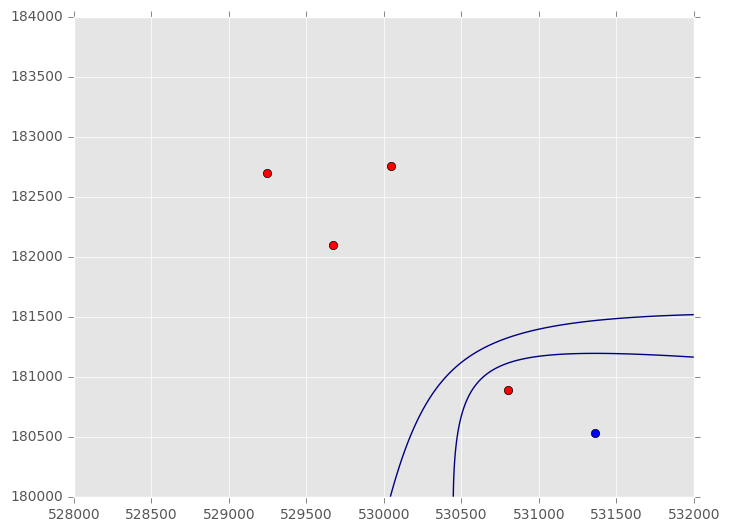

[[ 530797.029       180894.818            0.        ]
 [ 530043.285       182753.778         3832.81522775]
 [ 529247.279       182695.633         4283.11294492]]


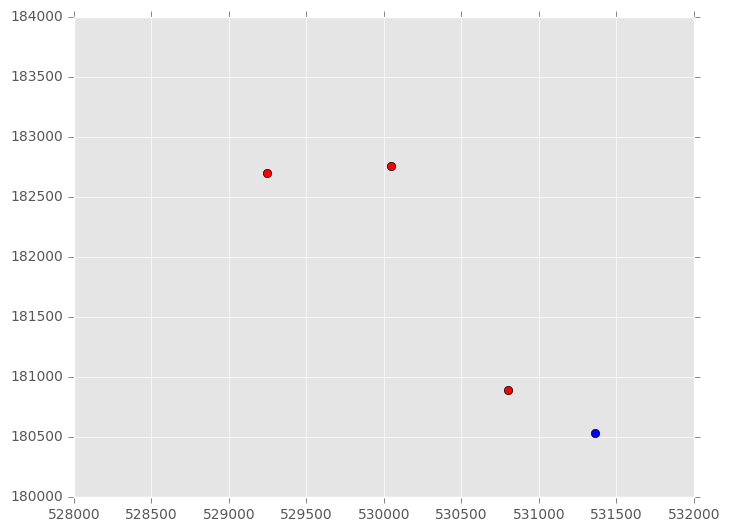

[[ 530796.335       180894.8              0.        ]
 [ 529673.466       182096.714         1558.9294115 ]
 [ 530042.649       182751.536         3546.91086031]]


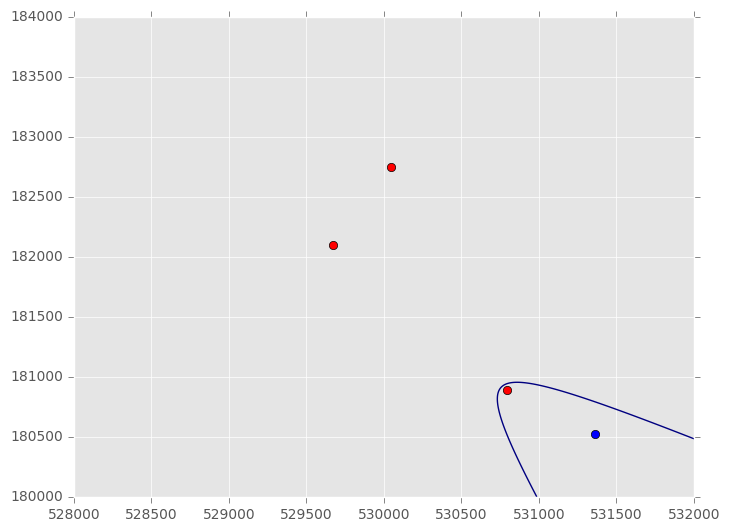

False
False
[[ 530794.976       180893.652            0.        ]
 [ 530042.649       182751.536         1545.58028818]
 [ 529247.307       182694.521         1995.87800535]]


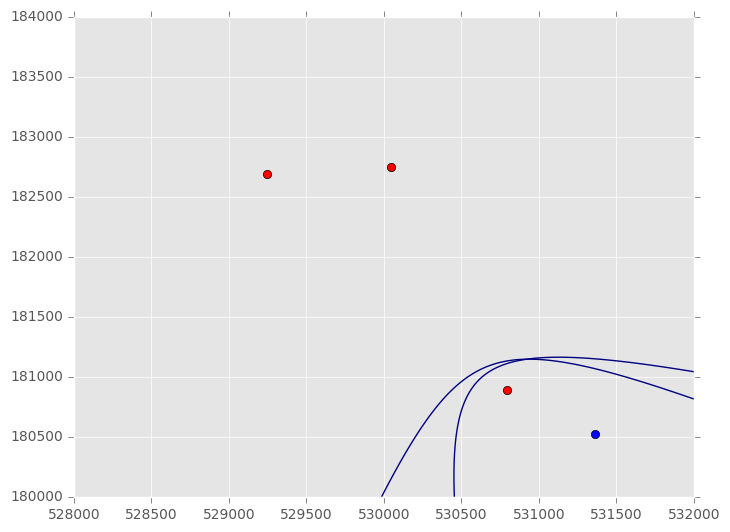

False
False
False
False
False
[[ 530795.005       180892.54             0.        ]
 [ 530039.209       182750.336         1760.00856376]
 [ 529248.723       182693.444         1924.40191349]
 [ 526677.588       179366.216         4617.66487184]]


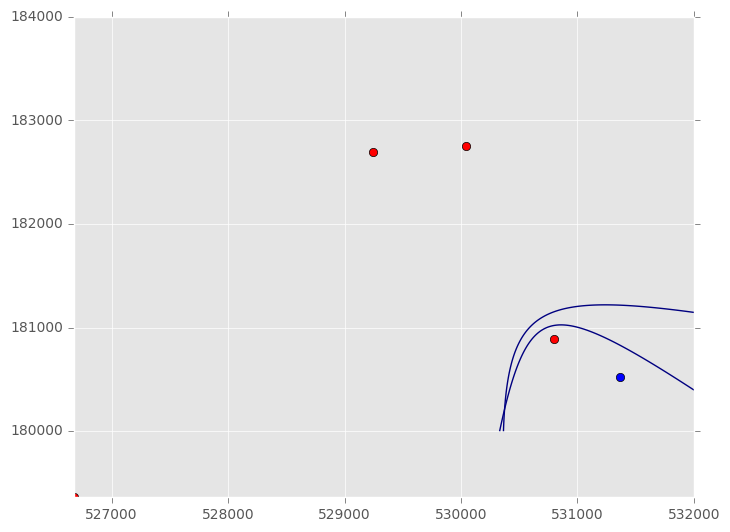

False
False
False
False
False
False
False
False
[[ 530795.005       180892.54             0.        ]
 [ 529672.022       182098.903         2202.21423826]
 [ 530037.822       182750.3           2403.29339052]]


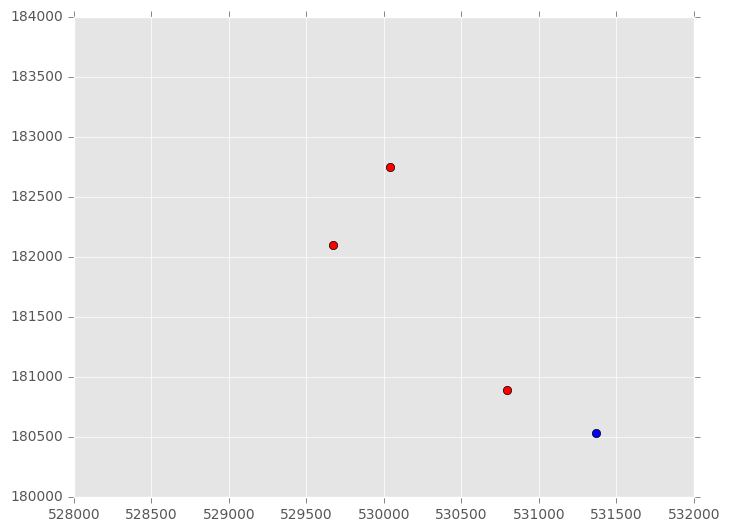

False
False
False
False
[[ 530795.67        180893.67             0.        ]
 [ 529248.723       182693.444         2281.78237279]
 [ 529672.022       182098.903         3989.1165348 ]]


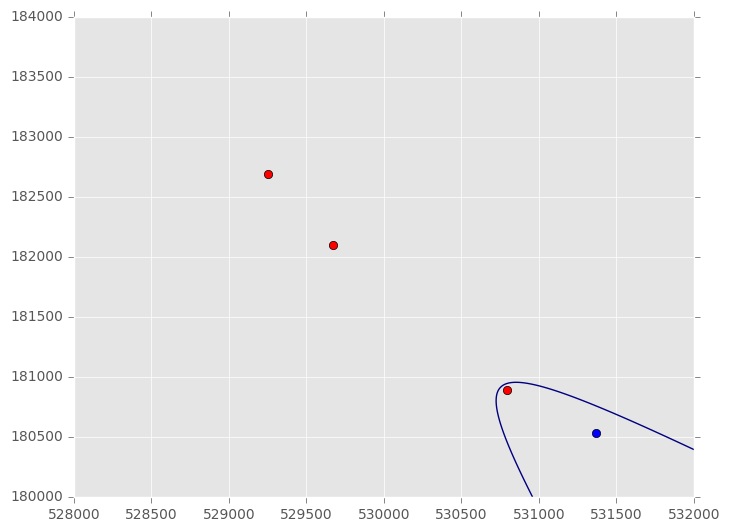

False
False
False
[[ 530793.588       180893.616            0.        ]
 [ 530037.794       182751.412         2617.7216661 ]
 [ 529249.388       182694.574         2496.21064838]]


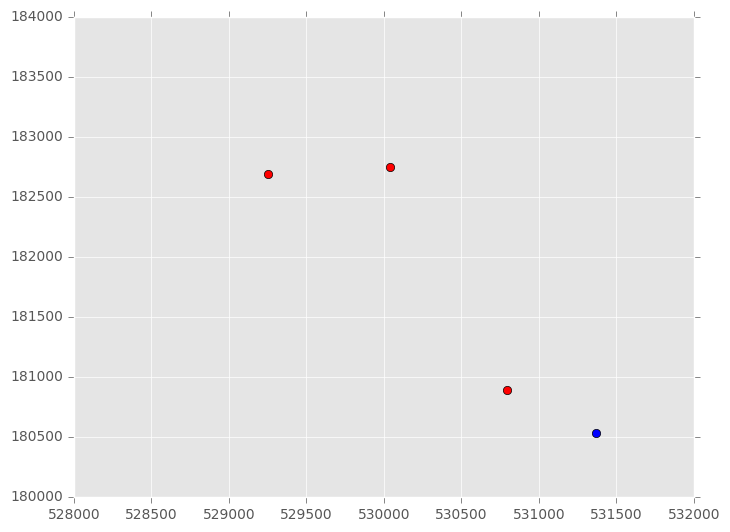

False
False
[[ 532014.377       181395.869            0.        ]
 [ 530792.923       180892.487       161422.21968845]
 [ 530037.794       182751.412       165781.59416141]]


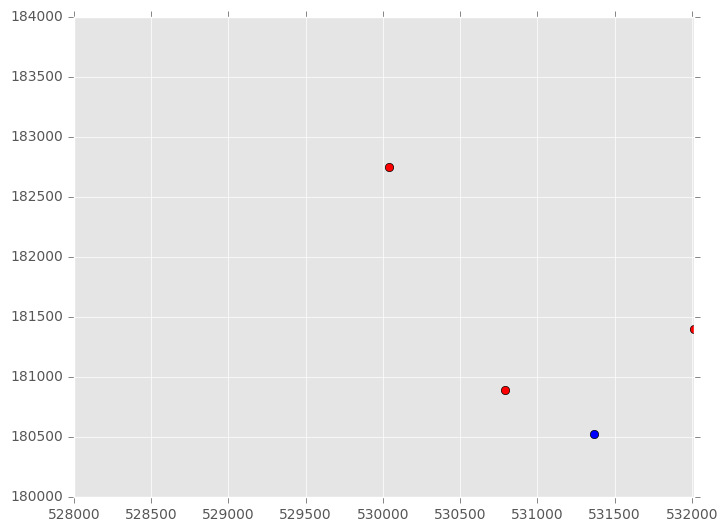

False
False
False
[[  5.30792895e+05   1.80893599e+05   0.00000000e+00]
 [  5.30037794e+05   1.82751412e+05   4.45823591e+01]
 [  5.29201771e+05   1.81920014e+05   1.13401702e+03]]


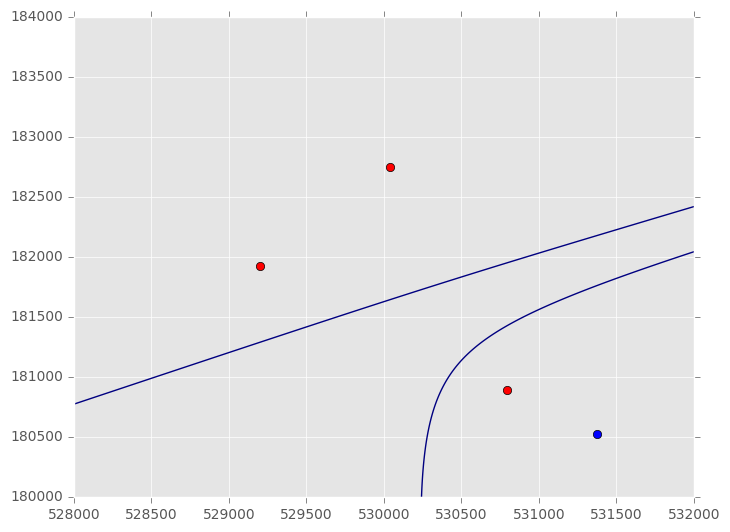

False
False
[[ 530792.895       180893.599            0.        ]
 [ 529671.994       182100.015         2488.1186057 ]
 [ 530035.684       182752.471         3332.48258472]]


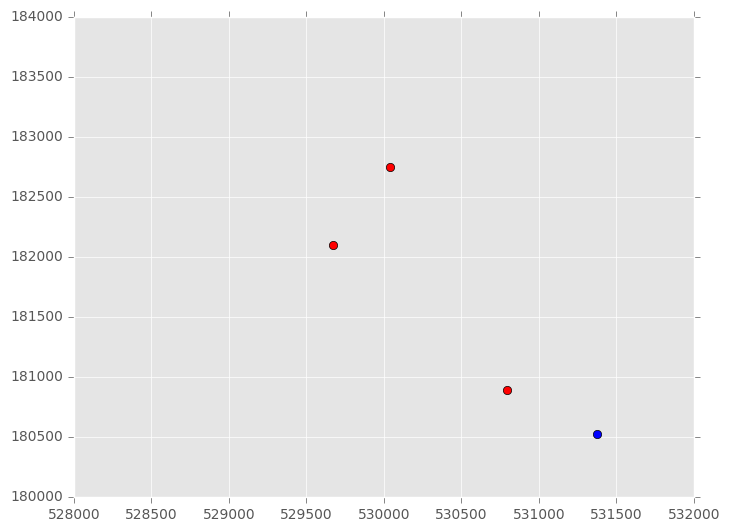

False
False
False
False
False
[[ 532014.377       181395.869            0.        ]
 [ 530794.89        180896.988       166497.02221063]
 [ 530035.656       182753.583       167282.5920905 ]]


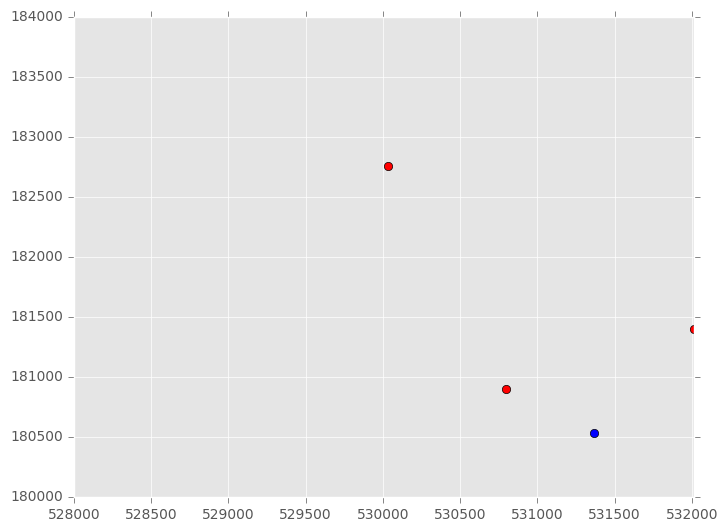

False
False
[[ 530794.196       180896.97             0.        ]
 [ 529202.408       181922.255         1991.73012679]
 [ 530035.656       182753.583         1474.10419632]
 [ 529247.279       182695.633         5212.30213912]]


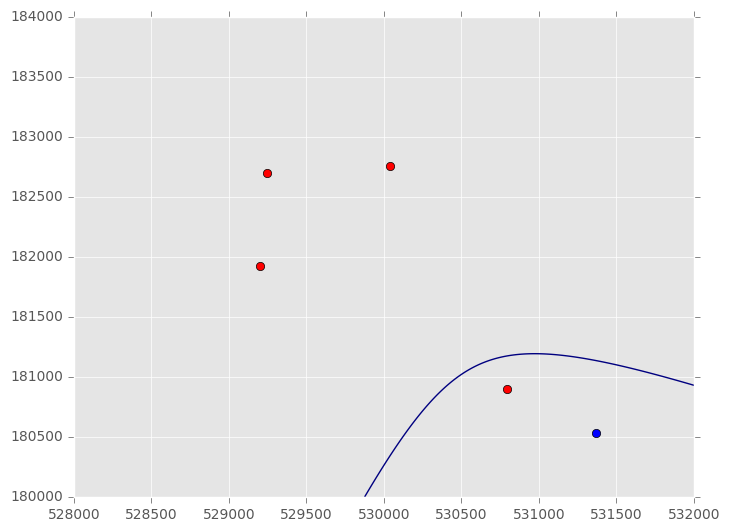

False
[[ 530794.196       180896.97             0.        ]
 [ 529216.283       181922.608         2563.53886168]
 [ 530036.378       182752.489         2975.10212541]]


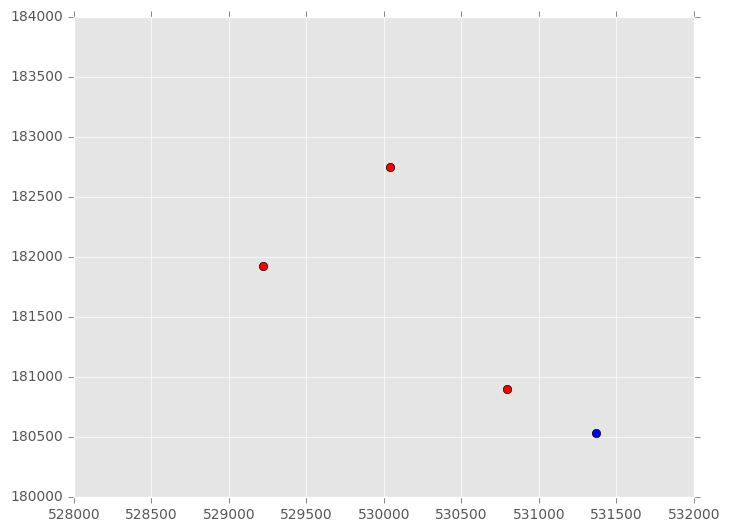

False
False
[[ 530794.862       180898.1              0.        ]
 [ 530037.071       182752.506         1474.10419632]
 [ 529245.892       182695.598         2782.11501583]]


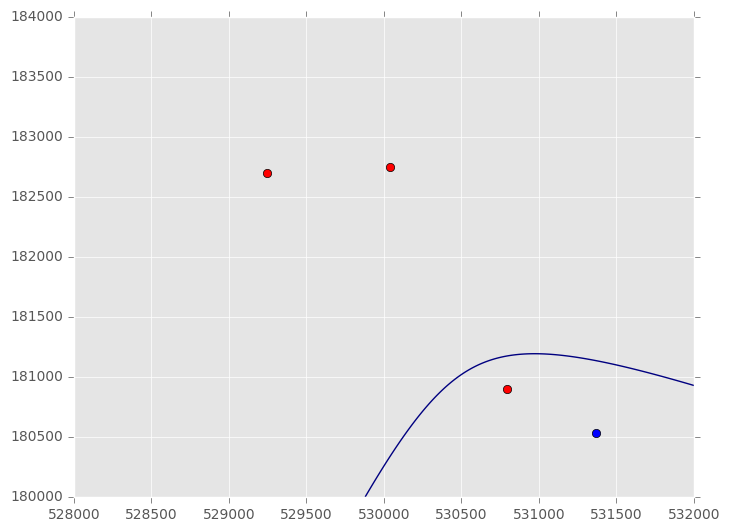

False
False
False
[[ 530794.168       180898.082            0.        ]
 [ 530037.043       182753.618         1474.10419632]
 [ 529246.586       182695.615         3139.49547513]]


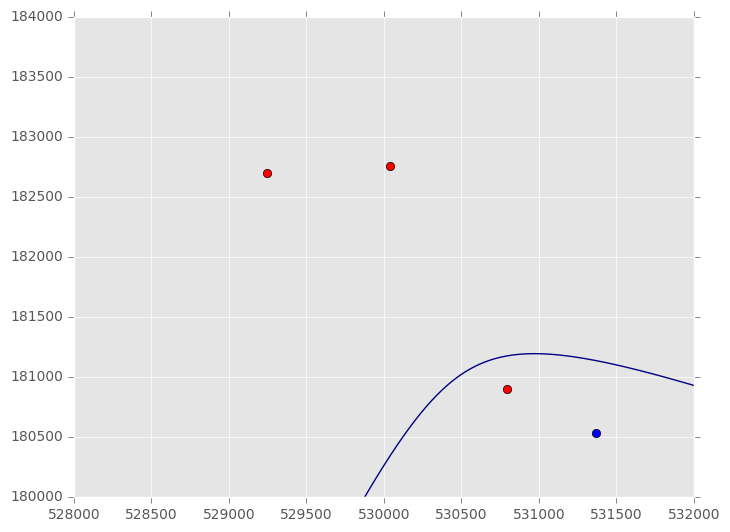

[[ 532014.377       181395.869            0.        ]
 [ 530794.168       180898.082       301086.50318626]
 [ 529246.586       182695.615       354178.2875847 ]]


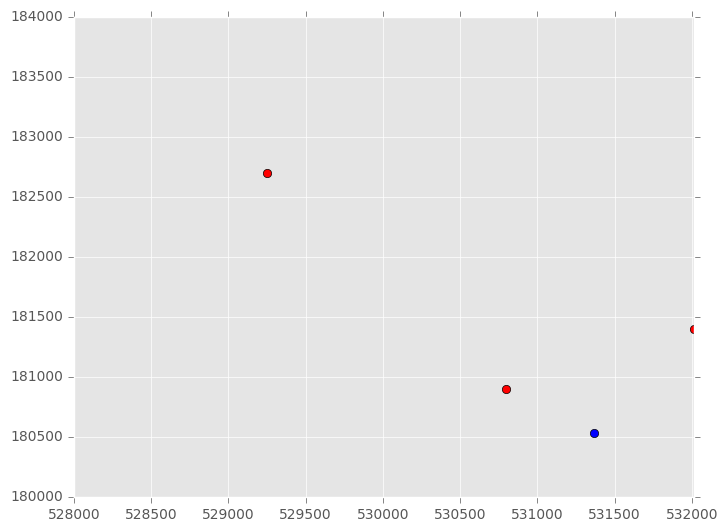

[[ 532014.377       181395.869            0.        ]
 [ 530793.474       180898.064       900056.15298752]
 [ 529246.586       182695.615       955864.0288767 ]]


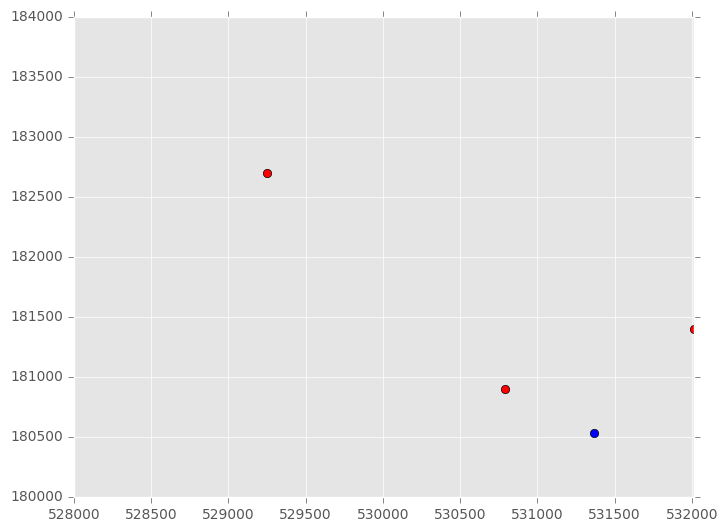

[[ 530793.474       180898.064            0.        ]
 [ 529194.833       181919.837         1419.92139189]
 [ 530037.043       182753.618         1188.19982887]
 [ 529246.586       182695.615         1066.68881114]]


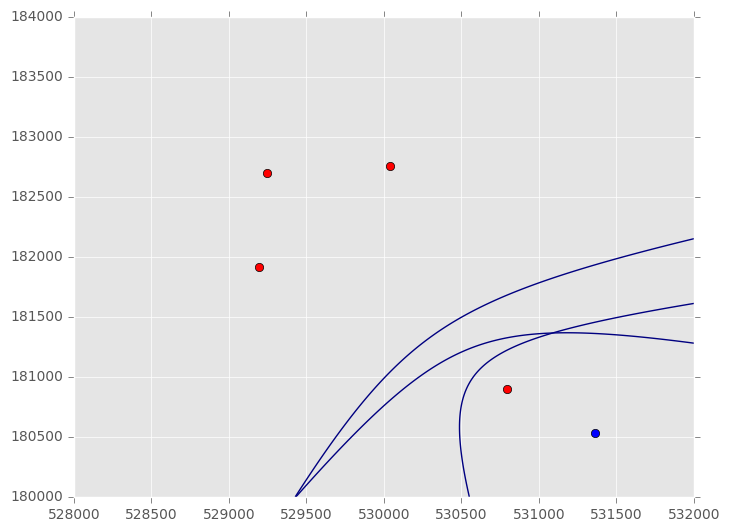

False
False
[[ 532014.377       181395.869            0.        ]
 [ 530037.014       182754.73        621513.15587176]
 [ 530792.78        180898.047       621585.29909424]]


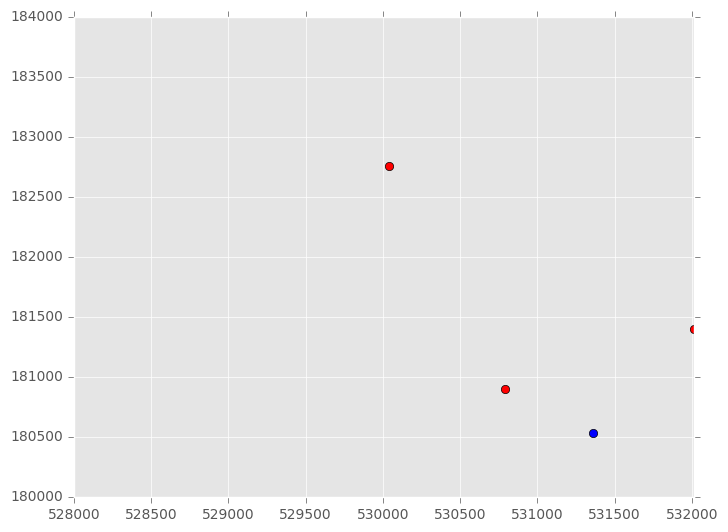

[[  532014.377        181395.869             0.        ]
 [  530037.014        182754.73        1476796.07108916]
 [  530792.78         180898.047       1477154.11867908]]


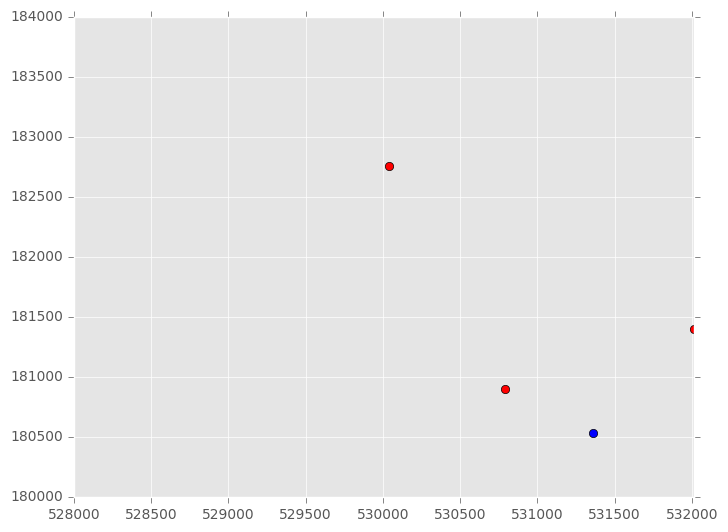

[[  532014.377        181395.869             0.        ]
 [  530792.751        180899.159       1175310.58274702]
 [  530037.708        182754.748       1178526.33975019]]


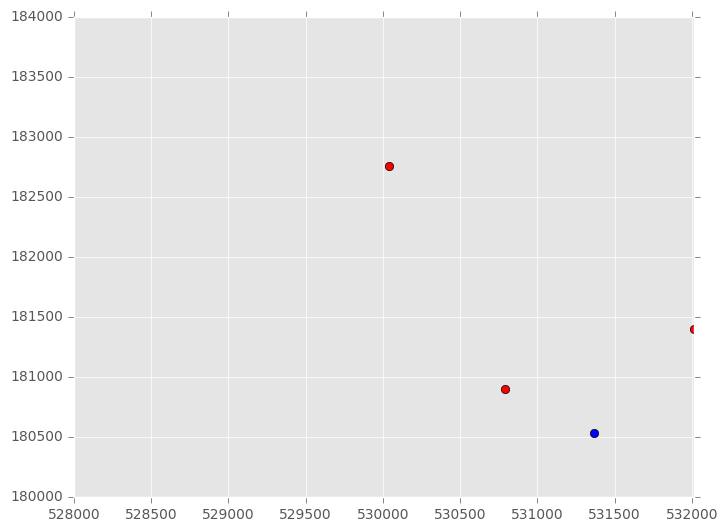

[[  5.30792751e+05   1.80899159e+05   0.00000000e+00]
 [  5.30037708e+05   1.82754748e+05   4.45823591e+01]
 [  5.29245892e+05   1.82695598e+05   7.80784444e+02]
 [  5.29667661e+05   1.82106580e+05   2.20221424e+03]]


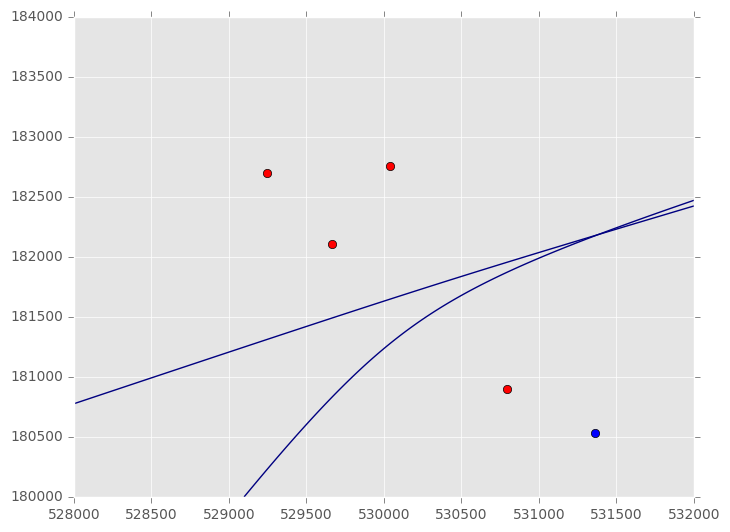

[[ 532014.377       181395.869            0.        ]
 [ 530792.751       180899.159       944728.7104011 ]
 [ 530037.708       182754.748       947372.65866937]
 [ 529194.89        181917.613       405239.99045369]]


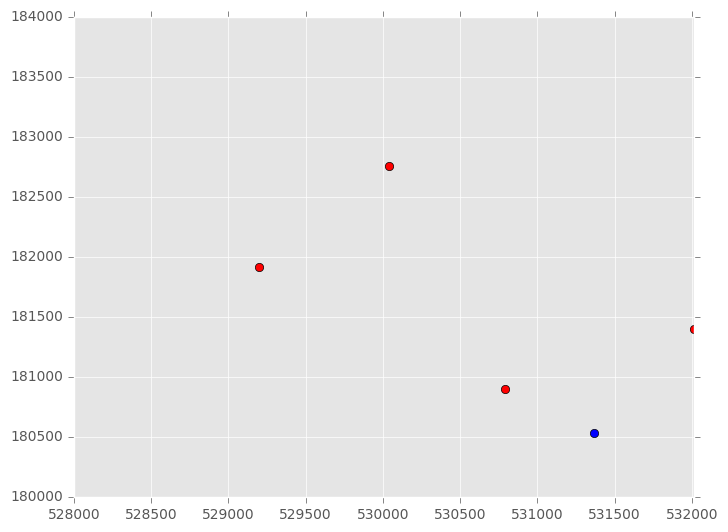

False
[[  532014.377        181395.869             0.        ]
 [  530792.086        180898.029       1172308.58688883]
 [  530037.708        182754.748       1174023.3459629 ]]


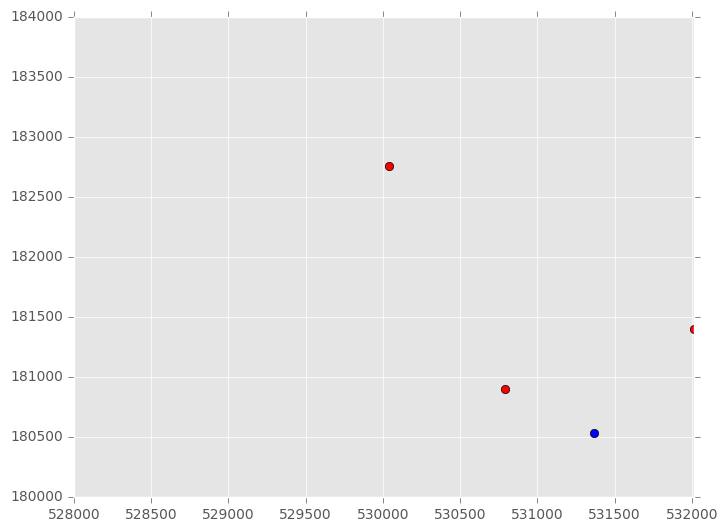

False
[[  5.30791392e+05   1.80898011e+05   0.00000000e+00]
 [  5.30037100e+05   1.82751394e+05   3.30486727e+02]
 [  5.29197721e+05   1.81915460e+05   1.70582576e+03]
 [  5.29666996e+05   1.82105451e+05   1.27302504e+03]
 [  5.29244505e+05   1.82695562e+05   7.80784444e+02]]


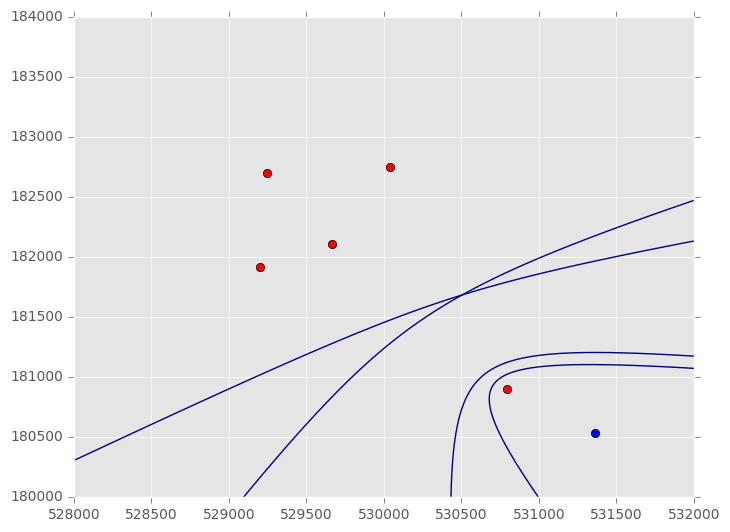

False
False
[[  5.30037794e+05   1.82751412e+05   0.00000000e+00]
 [  5.30791392e+05   1.80898011e+05   8.84606835e+02]
 [  5.29244505e+05   1.82695562e+05   1.86660557e+02]]


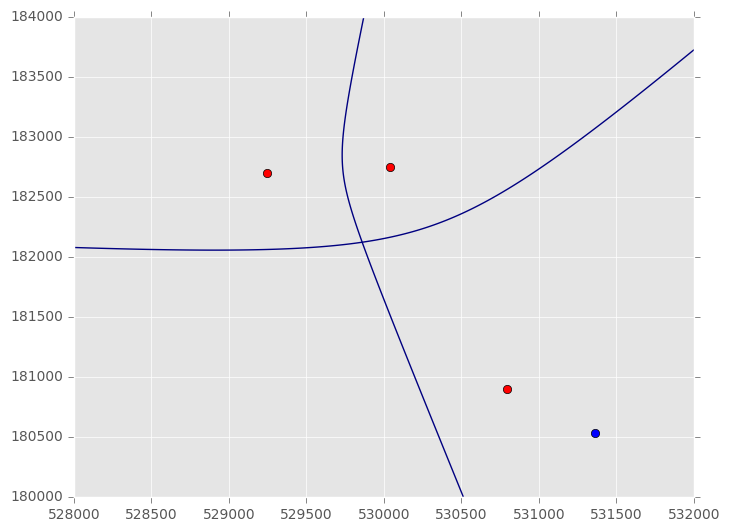

False
False
False
False
False
False
False
False
[[ 530790.698       180897.993            0.        ]
 [ 530037.1         182751.394         2045.91293121]
 [ 529242.396       182696.621         3139.49547513]]


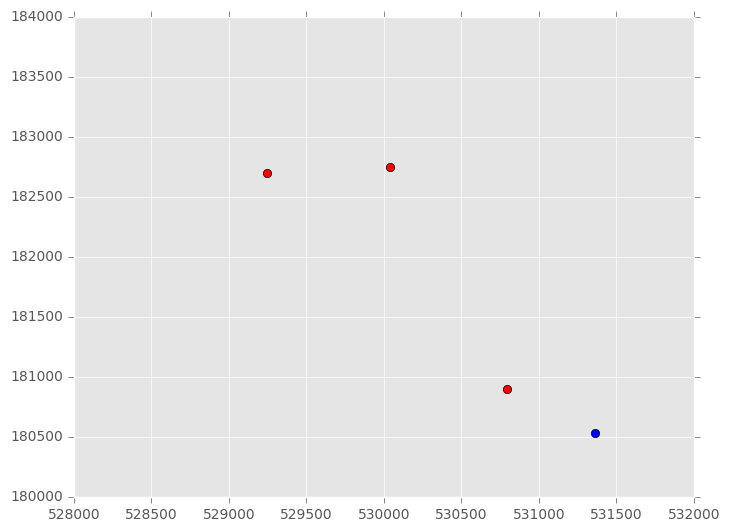

False
False
False
False
False
[[ 530790.698       180897.993            0.        ]
 [ 529217.005       181921.514         1991.73012679]
 [ 529245.552       182708.942         1281.11708673]]


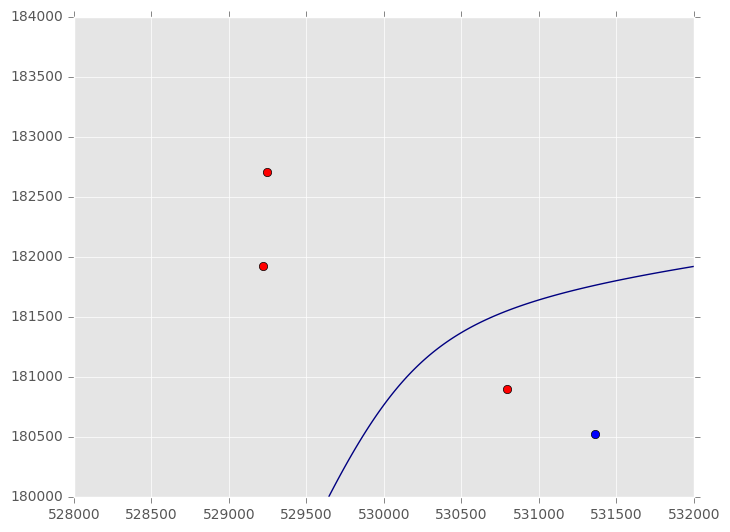

[[ 530790.698       180897.993            0.        ]
 [ 530037.1         182751.394          902.29546142]
 [ 529245.552       182708.942         1352.59317859]]


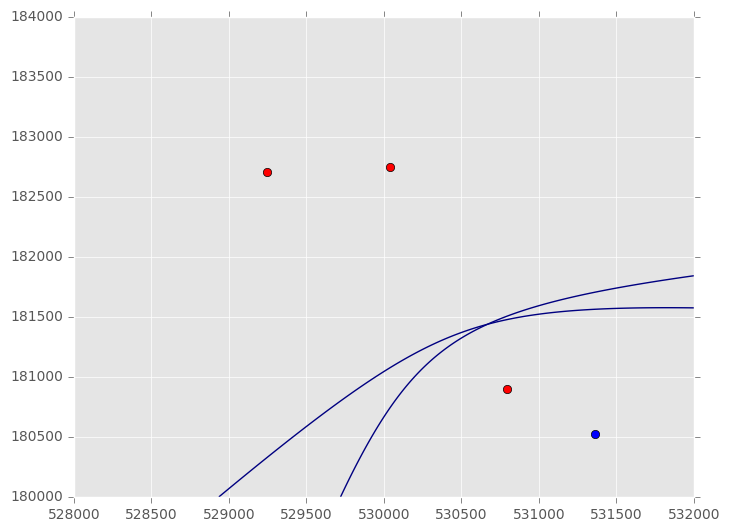

[[ 530790.698       180897.993            0.        ]
 [ 529245.552       182708.942         1352.59317859]
 [ 530037.1         182751.394         2689.19775797]]


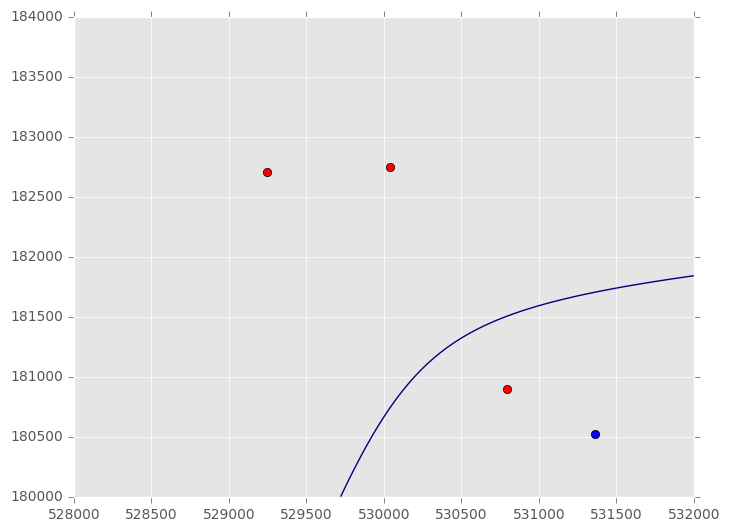

False
False
[[ 532014.377       181395.869            0.        ]
 [ 530791.392       180898.011       810711.03816036]
 [ 530037.1         182751.394       813069.08206119]]


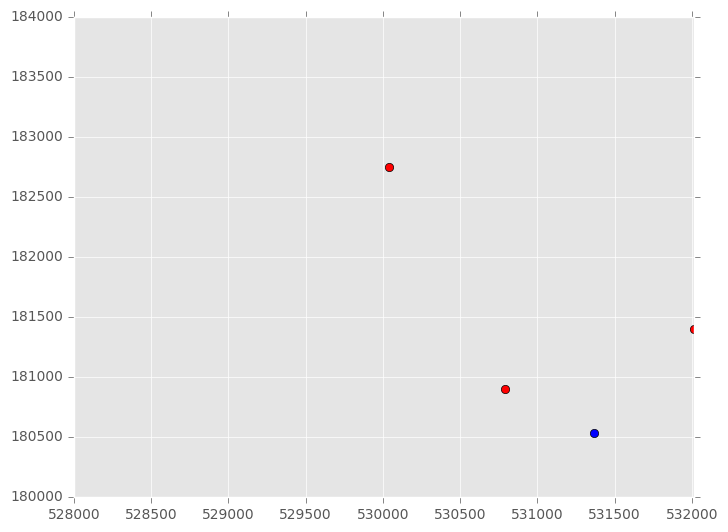

[[ 530790.641       180900.217            0.        ]
 [ 530037.1         182751.394         1474.10419632]
 [ 529246.303       182706.735         3997.20857748]]


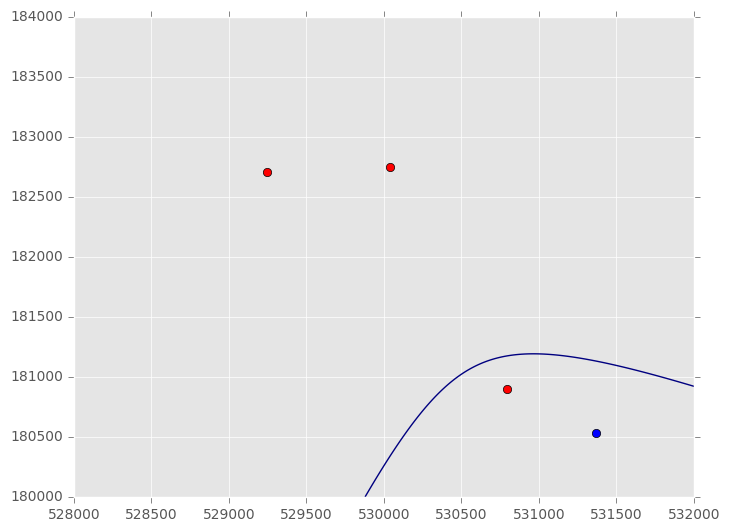

False
False
[[ 530788.56        180900.163            0.        ]
 [ 530037.794       182751.412         2403.29339052]
 [ 529246.331       182705.623         4068.68466934]]


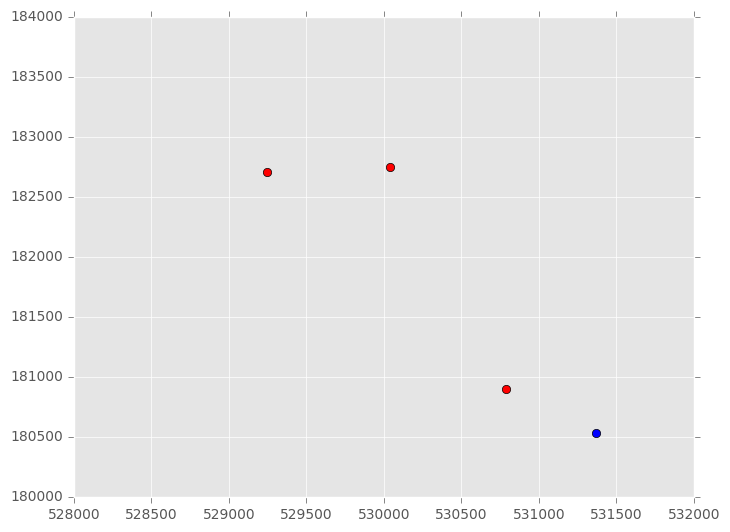

False
[[ 530788.56        180900.163            0.        ]
 [ 530037.794       182751.412         1474.10419632]
 [ 529664.943       182104.286         3131.40343246]]


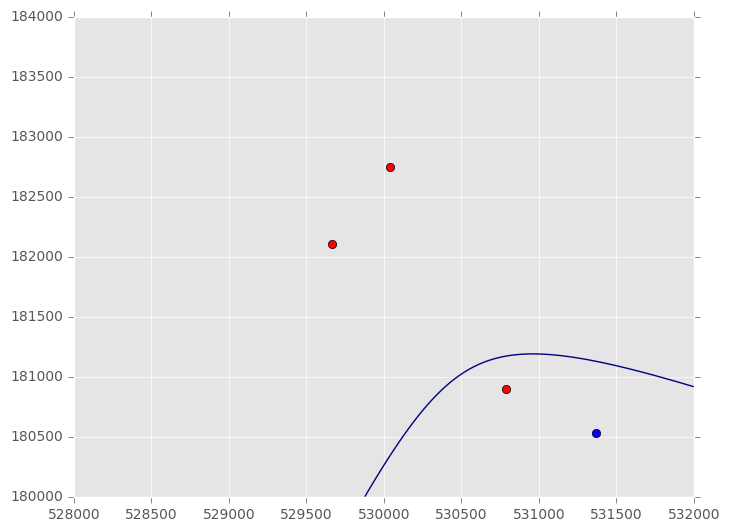

[[ 532014.377       181395.869            0.        ]
 [ 530787.952       180896.81        351191.24358133]
 [ 529664.249       182104.268       466528.03509766]
 [ 529246.359       182704.511       407856.83257285]]


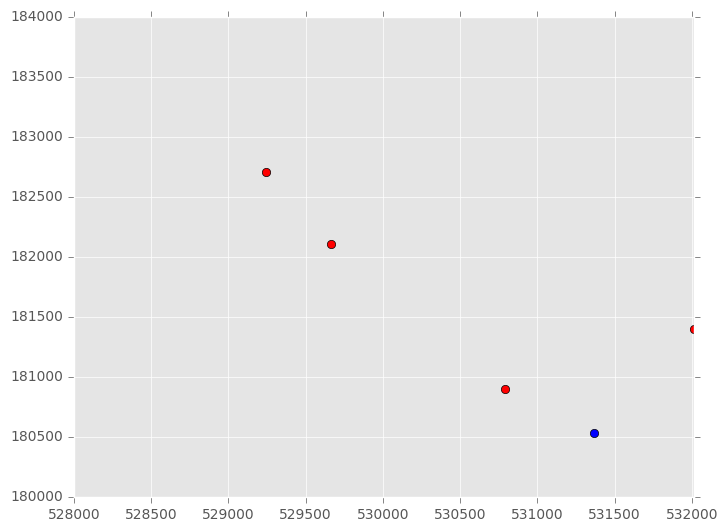

False
[[ 530787.952       180896.81             0.        ]
 [ 529198.826       181926.615         1348.44530003]
 [ 529664.249       182104.268          701.21630916]]


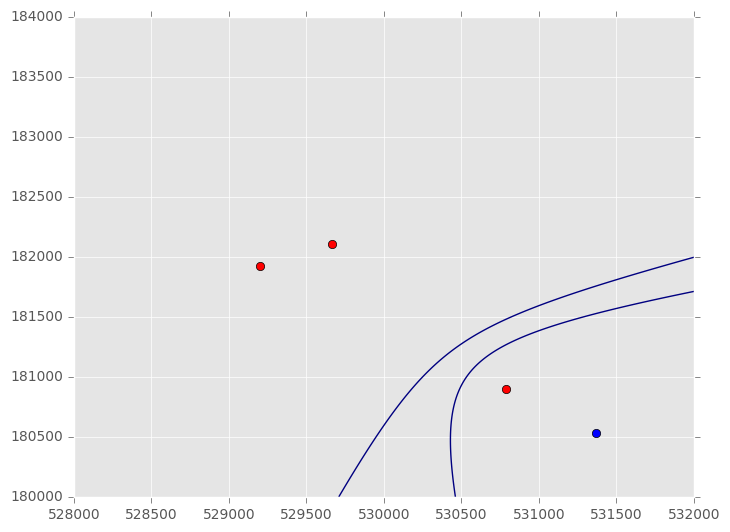

False
False
[[ 530787.952       180896.81             0.        ]
 [ 530035.713       182751.359         1188.19982887]
 [ 529662.862       182104.233         2774.02297315]]


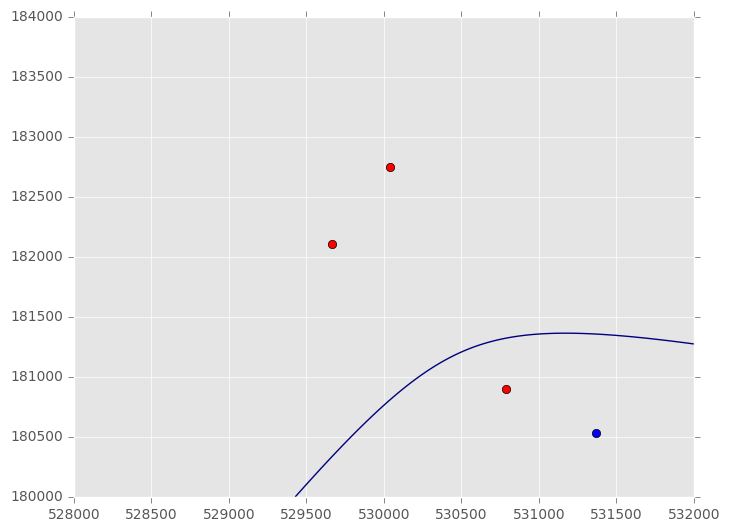

[[ 530788.645       180896.827            0.        ]
 [ 530035.713       182751.359          616.39109398]
 [ 529246.359       182704.511         1638.49754604]]


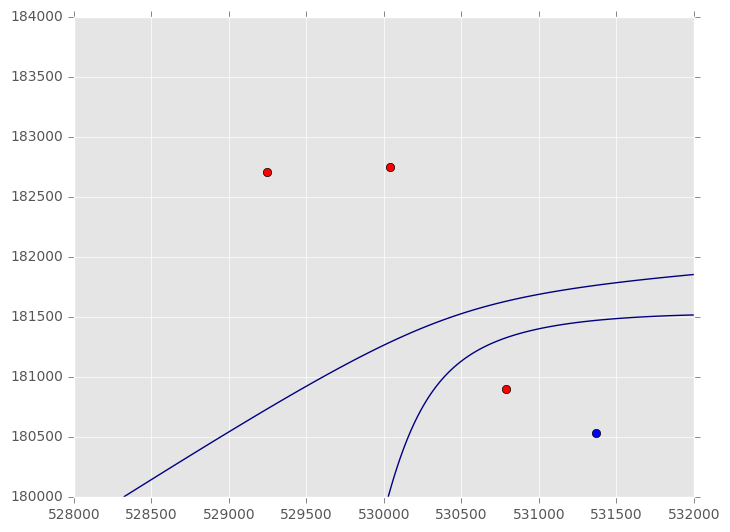

False
[[  5.30035713e+05   1.82751359e+05   0.00000000e+00]
 [  5.30788645e+05   1.80896827e+05   3.12798100e+02]
 [  5.29662862e+05   1.82104233e+05   2.74236490e+03]]


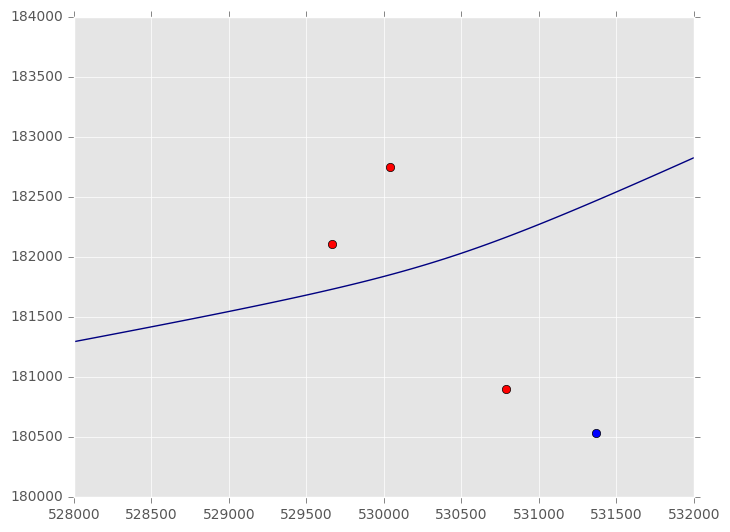

False
False
False
False
False
[[ 529245.085       182700.028            0.        ]
 [ 530034.325       182751.323          956.95691292]
 [ 529173.271       181921.514         1581.95909767]]


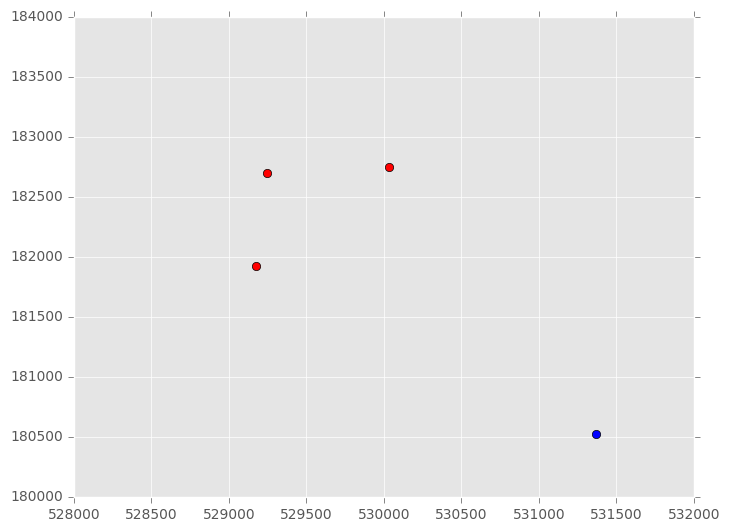

False
False
False


In [824]:
i = 608
#i = 2
for packet in data:
    D = TDOAs_2D_Offsets(packet['gateways'], offsets)
    print D
    if D is not False:
        A = convert_bng(packet['payload']['lon'], packet['payload']['lat'])
        plotTDOA(D,A)

In [1696]:
errors = []
for n,packet in enumerate(data):
    D = TDOAs_2D_Offsets(packet['gateways'], offsets)
    if D is not False:
        n = len(D[:,0])
        res = []
        for i in range(1,n):
            for j in range(i,n):
                if i != j:       
                    res += Chan_for3(D[(0,i,j),:])
        if res:
            A = convert_bng(packet['payload']['lon'], packet['payload']['lat'])
            errs = []
            for pos in res:
                errs.append(distance2D(pos[0][0],pos[0][1],A[0][0],A[1][0]))
            errors.append(min(errs))
            #plotTDOA(D,A)
            print ""

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1697]:
errors

[1355.1494215432651,
 902.9102530971439,
 672.6292156393603,
 310.90057146570047,
 416.79685651541274,
 858.5866973167359,
 232.77459560043476,
 464.9721886196775,
 299.96408816884826,
 934.0356314579166,
 253.89467019579263,
 433.4203371113684,
 162.10124116243404,
 611.3632206468642,
 594.5327945424,
 113.52009197856701,
 11370.643505248168,
 3509.9613811603185,
 324090.53366227826,
 940.9691727871559,
 14235.751816083226,
 2134.3610579502683,
 1440.150074163009]

In [1698]:
print np.mean(errors)
print np.median(errors)
print np.std(errors)

15927.8227193
672.629215639
65792.1043127


In [1006]:
len(errors)/170.0

0.17058823529411765

In [1007]:
len(errors)/float(len(data))

0.044753086419753084

In [1009]:
errors_2 = []
for val in errors:
    if val < 5000:
        errors_2.append(val)
print np.mean(errors_2)
print np.std(errors_2)
len(errors_2)

810.902460795
552.638158756


21

# Oxo Tower - oversampling

In [1016]:
## i=26520 -> data[495]
lat = 51.509
lon = -0.1084
realx, realy = convert_bng(lon, lat)
realx, realy = realx[0], realy[0]

oxoGateways = {}
for packet in data[495:]:
    for gw in packet['gateways']:
        x,y = convert_bng(gw['lon'], gw['lat'])
        oxoGateways[gw['addr']] = {
            'x': x[0],
            'y': y[0]
        }
        
for addr,gw in oxoGateways.iteritems():
    gw['real_distance'] = distance2D(realx,realy,gw['x'],gw['y'])

len(oxoGateways)

7

In [1039]:
oxoGateways

{u'70b3d54b109e0000': {'real_distance': 2566.352766780581,
  'x': 529173.271,
  'y': 181921.514},
 u'70b3d54b110f0000': {'real_distance': 2537.9644954233017,
  'x': 530034.325,
  'y': 182751.323},
 u'70b3d54b11440000': {'real_distance': 654.4255275590896,
  'x': 530789.339,
  'y': 180896.845},
 u'70b3d54b12330000': {'real_distance': 4849.60515838434,
  'x': 526676.922,
  'y': 179365.087},
 u'70b3d54b12600000': {'real_distance': 2991.9088747544215,
  'x': 529245.085,
  'y': 182700.028},
 u'70b3d54b13410000': {'real_distance': 1030.7694308937237,
  'x': 532014.377,
  'y': 181395.869},
 u'70b3d54b13830000': {'real_distance': 2279.3148377984685,
  'x': 529662.862,
  'y': 182104.233}}

In [1024]:
timediffs = {}

for packet in data[495:]:
    
    for gw1 in packet['gateways']:
        if gw1['addr'] not in timediffs:
            timediffs[gw1['addr']] = {}
            
        for gw2 in packet['gateways']:
            if gw1 is gw2:
                continue
            
            if gw2['addr'] not in timediffs[gw1['addr']]:
                timediffs[gw1['addr']][gw2['addr']] = []
            
            diff = gw1['time'] - gw2['time']
            timediffs[gw1['addr']][gw2['addr']].append(diff)
            

In [1126]:
def reject_outliers(data, m = 2.):
    if len(data) < 2:
        return data
    data2 = np.array(data)
    d = np.abs(data2 - np.median(data2))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data2[s<m]

In [1258]:
def timediff_stats_no(reject = False, m=2.):
    timediffs_no = {}
    for gw1,vals1 in timediffs.iteritems():
        if gw1 not in timediffs_no:
            timediffs_no[gw1] = {}

        for gw2,vals2 in vals1.iteritems():
            
            if len(vals2) < 10:
                continue
                
            if reject:
                vals2 = reject_outliers(vals2,m)

            if gw2 not in timediffs_no[gw1]:
                timediffs_no[gw1][gw2] = {}
                
            timediffs_no[gw1][gw2]['mean'] = np.mean(vals2)
            timediffs_no[gw1][gw2]['median'] = np.median(vals2)
            timediffs_no[gw1][gw2]['std'] = np.std(vals2)
            
    return timediffs_no

In [1338]:
timediff_stats = timediff_stats_no(reject = True, m=2)
timediff_stats_no_list = []
for gw1,vals1 in timediff_stats.iteritems():
    for gw2,vals2 in vals1.iteritems():
        vals2['gw1'] = gw1
        vals2['gw2'] = gw2
        timediff_stats_no_list.append(vals2)
df = pd.DataFrame(timediff_stats_no_list)

In [1476]:
dfpos = df[ df['mean'] > 0 ].sort_values('std')

realdist = []
offset = []

for i,row in dfpos.iterrows():
    realdiff = oxoGateways[row['gw1']]['real_distance'] - oxoGateways[row['gw2']]['real_distance']
    realdist.append(realdiff)
    
    o = offsets[row['gw1']][row['gw2']]['mean']
    offset.append(o)


dfpos['real_distance'] = realdist
dfpos['mean'] += offset
dfpos['distance'] = dfpos['mean']*C
dfpos = dfpos[dfpos['distance'] > 0]

In [1477]:
dfpos

gw1               gw2          mean    median       std  \
17  70b3d54b109e0000  70b3d54b11440000  6.494182e-06  0.000005  0.000002   
14  70b3d54b13830000  70b3d54b11440000  5.575058e-06  0.000008  0.000002   
20  70b3d54b110f0000  70b3d54b11440000  6.259191e-06  0.000008  0.000003   
19  70b3d54b110f0000  70b3d54b13830000  3.997527e-07  0.000002  0.000003   
0   70b3d54b12600000  70b3d54b13830000  1.562397e-06  0.000003  0.000003   
3   70b3d54b12600000  70b3d54b110f0000  4.035165e-06  0.000005  0.000003   
1   70b3d54b12600000  70b3d54b11440000  9.004420e-06  0.000012  0.000004   
15  70b3d54b13830000  70b3d54b13410000  4.990153e-04  0.059517  0.001569   
23  70b3d54b110f0000  70b3d54b13410000  2.146119e-04  0.059694  0.001726   

    real_distance       distance  
17    1911.927239    1946.906838  
14    1624.889310    1671.360476  
20    1883.538968    1876.458395  
19     258.649658     119.842845  
0      712.594037     468.394981  
3      453.944379    1209.711971  
1     2337.483347    2699.457198  
15    1248.545407  149601.036819  
23    1507.195065   64339.022476

<Container object of 3 artists>

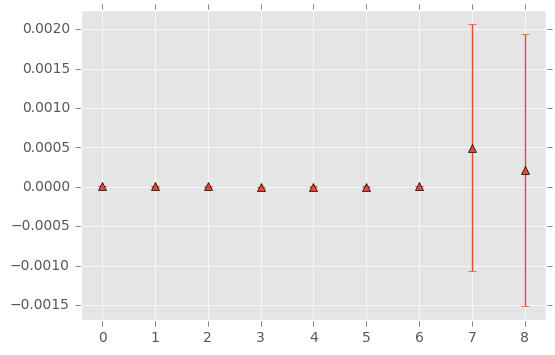

In [1478]:
plt.xticks(range(len(dfpos)), range(len(dfpos)), rotation='horizontal')
plt.margins(0.05)
plt.errorbar(range(len(dfpos)), dfpos['mean'], yerr=dfpos['std'], linestyle='None', marker='^')

<Container object of 3 artists>

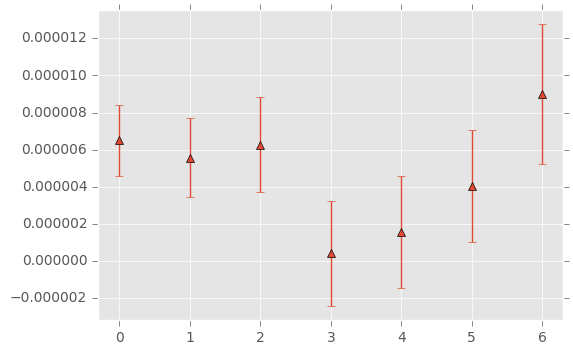

In [1479]:
dfpos_low = dfpos[ (dfpos['mean'] < 0.0001) & (dfpos['mean'] > -0.0001) ]
plt.xticks(range(len(dfpos_low)), range(len(dfpos_low)), rotation='horizontal')
plt.margins(0.05)
plt.errorbar(range(len(dfpos_low)), dfpos_low['mean'], yerr=dfpos_low['std'], linestyle='None', marker='^')

In [1509]:
#dfpos_low['x'] = oxoGateways[dfpos_low['gw1']]['x']

def first_two():
    dfgws = dfpos_low.iloc[0:3][['gw1','gw2','distance']]
    gw2 = dfgws.iloc[0]['gw2']
    dfgws = dfgws.append([{'gw1': gw2, 'gw2': gw2, 'distance': 0.}])
    xs = []
    ys = []
    for gw in dfgws['gw1']:
        xs.append(oxoGateways[gw]['x'])
        ys.append(oxoGateways[gw]['y'])
    dfgws['x'] = xs
    dfgws['y'] = ys
    print dfgws
    dfgws = dfgws[['x','y','distance']]
    D = scipy.matrix(dfgws.values)
    return D


def allD():
    dfgws = dfpos_low[['gw1','gw2','distance']]

    xs = []
    ys = []
    for gw in dfgws['gw1']:
        xs.append(oxoGateways[gw]['x'])
        ys.append(oxoGateways[gw]['y'])
    dfgws['x1'] = xs
    dfgws['y1'] = ys
    xs = []
    ys = []
    for gw in dfgws['gw2']:
        xs.append(oxoGateways[gw]['x'])
        ys.append(oxoGateways[gw]['y'])
    dfgws['x2'] = xs
    dfgws['y2'] = ys
    #dfgws = dfgws.sort_values('distance')
    dfgws = dfgws[['x1','y1','x2','y2','distance']]
    D = scipy.matrix(dfgws.values)
    return D

def realD():
    dfgws = dfpos_low[['gw1','gw2','real_distance']]

    xs = []
    ys = []
    for gw in dfgws['gw1']:
        xs.append(oxoGateways[gw]['x'])
        ys.append(oxoGateways[gw]['y'])
    dfgws['x1'] = xs
    dfgws['y1'] = ys
    xs = []
    ys = []
    for gw in dfgws['gw2']:
        xs.append(oxoGateways[gw]['x'])
        ys.append(oxoGateways[gw]['y'])
    dfgws['x2'] = xs
    dfgws['y2'] = ys
    #dfgws = dfgws.sort_values('real_distance')
    dfgws = dfgws[['x1','y1','x2','y2','real_distance']]
    D = scipy.matrix(dfgws.values)
    return D

In [1505]:
def plot_all(D):
    x = np.linspace(528000, 532000, 1000)
    y = np.linspace(180000, 184000, 1000)
    x, y = np.meshgrid(x, y)

    for i in range(len(D)):
        plt.contour(x, y, ( np.sqrt((x-D[i,0])**2 + (y-D[i,1])**2) - np.sqrt((x-D[i,2])**2 + (y-D[i,3])**2) ), [D[i,4]])

    plt.plot(D[:,0], D[:,1], 'or')
    plt.plot(D[:,2], D[:,3], 'or')
    plt.plot(realx, realy, 'ob')
    plt.show()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

[[  5.29173271e+05   1.81921514e+05   5.30789339e+05   1.80896845e+05
    1.91192724e+03]
 [  5.29662862e+05   1.82104233e+05   5.30789339e+05   1.80896845e+05
    1.62488931e+03]
 [  5.30034325e+05   1.82751323e+05   5.30789339e+05   1.80896845e+05
    1.88353897e+03]
 [  5.30034325e+05   1.82751323e+05   5.29662862e+05   1.82104233e+05
    2.58649658e+02]
 [  5.29245085e+05   1.82700028e+05   5.29662862e+05   1.82104233e+05
    7.12594037e+02]
 [  5.29245085e+05   1.82700028e+05   5.30034325e+05   1.82751323e+05
    4.53944379e+02]
 [  5.29245085e+05   1.82700028e+05   5.30789339e+05   1.80896845e+05
    2.33748335e+03]]


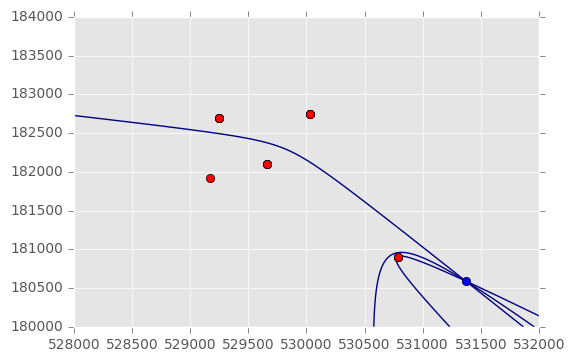

In [1482]:
D = realD()
print D
plot_all(D)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

[[  5.29173271e+05   1.81921514e+05   5.30789339e+05   1.80896845e+05
    1.94690684e+03]
 [  5.29662862e+05   1.82104233e+05   5.30789339e+05   1.80896845e+05
    1.67136048e+03]
 [  5.30034325e+05   1.82751323e+05   5.30789339e+05   1.80896845e+05
    1.87645840e+03]
 [  5.30034325e+05   1.82751323e+05   5.29662862e+05   1.82104233e+05
    1.19842845e+02]
 [  5.29245085e+05   1.82700028e+05   5.29662862e+05   1.82104233e+05
    4.68394981e+02]
 [  5.29245085e+05   1.82700028e+05   5.30034325e+05   1.82751323e+05
    1.20971197e+03]
 [  5.29245085e+05   1.82700028e+05   5.30789339e+05   1.80896845e+05
    2.69945720e+03]]


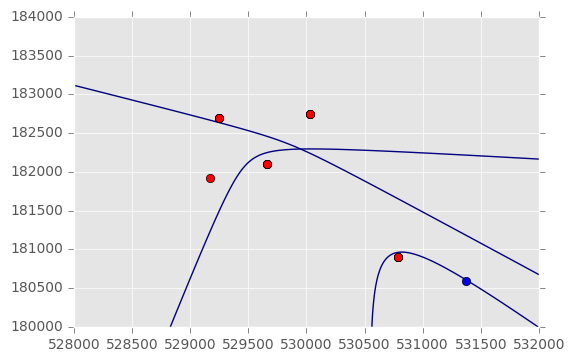

In [1508]:
D = allD()
print D
plot_all(D)

# Iterative method

## Least Squares - Gauss-Newton?

In [1532]:
def mlat_iter(rel_stations, prange_obs, xguess = [0,0], limit = 20, maxrounds = 10000):
    xerr = [1e9, 1e9]
    rounds = 0
    while numpy.linalg.norm(xerr) > limit:
        prange_est = [[numpy.linalg.norm(station - xguess)] for station in rel_stations]
        dphat = prange_obs - prange_est
        H = numpy.array([(numpy.array(-rel_stations[row,:])+xguess) / prange_est[row] for row in range(0,len(rel_stations))])
        #now we have H, the Jacobian, and can solve for residual error
        xerr = numpy.linalg.lstsq(H, dphat)[0].flatten()
        xguess += xerr
        #print xguess, xerr
        rounds += 1
        if rounds > maxrounds:
            raise Exception("Failed to converge!")
            break
    return xguess

In [1543]:
def mlat(D, lmt, guess=None):
    R = [ ([D[x,0],D[x,1]], D[x,2]) for x in range(len(D))]
    
    sorted_R = sorted(R, key=lambda time: time[1])

    stations = [sorted_reply[0] for sorted_reply in sorted_R]
    timestamps = [sorted_reply[1] for sorted_reply in sorted_R]

    me = stations[0]
    
    #list of stations in XY relative to me
    rel_stations = [numpy.array(station) - numpy.array(me) for station in stations[1:]]
    rel_stations.append([0,0]-numpy.array(me))
    rel_stations = numpy.array(rel_stations) #convert list of arrays to 2d array

    #differentiate the timestamps to get TDOA, multiply by c to get pseudorange
    prange_obs = [[(stamp-timestamps[0])] for stamp in timestamps[1:]]
    prange_obs.append( [numpy.linalg.norm(me)] )
    prange_obs = numpy.array(prange_obs)

    #xguess = llh2ecef([37.617175,-122.400843, 8000])-numpy.array(me)
    #xguess = [1.8,1.6]
    #start our guess directly overhead, who cares
    if guess is None:
        xguess = numpy.array(me) - numpy.array(me)
    else:
        xguess = guess
    
    xypos = mlat_iter(rel_stations, prange_obs, xguess, limit=lmt)

    
    return xypos+me

In [1596]:
def TDOAs_mlat(gateways, reject=False, m=10.):
    tmp = []
    for gw in gateways:
        x,y = convert_bng(gw['lon'], gw['lat'])
        tmp.append(x+y+[gw['time']])
    
    D = scipy.array(tmp)
    
    if reject:
        
        times = reject_outliers(D[:,2], m)
        if isinstance(times, float):
            return False
        todelete = []
        for i in range(len(D[:,2])):
            if D[i,2] not in times:
                todelete.append(i)
        D = numpy.delete(D, todelete, axis=0)
    
    if len(D[:,2]) < 3:
        return False

    D = D[D[:,2].argsort()]

    for i in reversed(range(len(D[:,2]))):
        D[i,2] -= D[0,2]
        D[i,2] *= C
    return scipy.matrix(D)

[ 528843.6278659   183535.87158122]


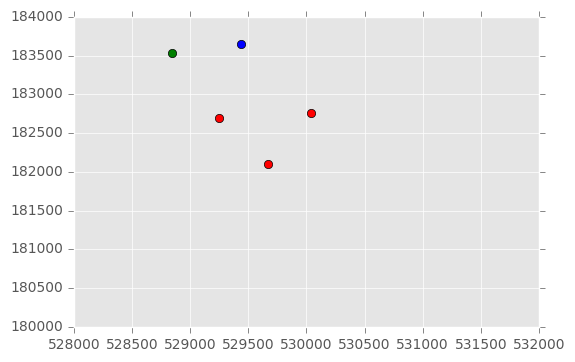

In [1538]:
packet = data[2]
D = TDOAs_2D_Offsets(packet['gateways'], offsets)
if D is not False:
    result = mlat(D, 20)
    print result
    A = convert_bng(packet['payload']['lon'], packet['payload']['lat'])
    plotTDOA(D,A,result)

## Run on Raw Data - no offset

In [1594]:
def run_raw(use_last_pos=False, reject=False, m=10.):
    
    errors = []
    prev_result = None
    for i,packet in enumerate(data):
        if len(packet['gateways']) < 3:
            continue
            
        D = TDOAs_mlat(packet['gateways'], reject=reject, m=m)
        
        if D is not False:
            try:
                res = mlat(D, 20, guess=prev_result)
            except:
                continue

            A = convert_bng(packet['payload']['lon'], packet['payload']['lat'])

            x = res[0]
            y = res[1]
            error = distance2D(x,y,A[0][0],A[1][0])
            errors.append(error)
            
            if use_last_pos:
                prev_result = res
            
            #plotTDOA(D,A,res)
    
    return errors


In [1541]:
errors_raw = run_raw()
print "Mean Error: %.3f" % np.mean(errors_raw)
print "Median Error: %.3f" % np.median(errors_raw)
print "Standard Deviation: %.3f" % np.std(errors_raw)
print "Proportion of 3+ gateways: %.3f" % (len(errors_raw)/170.0)
print "Number calculated: %d" % len(errors_raw)

Mean Error: 971.724
Median Error: 850.064
Standard Deviation: 614.283
Proportion of 3+ gateways: 0.441
Number calculated: 75


In [1599]:
errors_raw = run_raw(reject=True, m=100.)
print "Mean Error: %.3f" % np.mean(errors_raw)
print "Median Error: %.3f" % np.median(errors_raw)
print "Standard Deviation: %.3f" % np.std(errors_raw)
print "Proportion of 3+ gateways: %.3f" % (len(errors_raw)/170.0)
print "Number calculated: %d" % len(errors_raw)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


Mean Error: 1081.009
Median Error: 910.154
Standard Deviation: 718.972
Proportion of 3+ gateways: 0.576
Number calculated: 98


## Run on Raw Data - no offset - using last position as xguess

In [1547]:
errors_raw_lastpos = run_raw(use_last_pos=True)
print "Mean Error: %.3f" % np.mean(errors_raw_lastpos)
print "Median Error: %.3f" % np.median(errors_raw_lastpos)
print "Standard Deviation: %.3f" % np.std(errors_raw_lastpos)
print "Proportion of 3+ gateways: %.3f" % (len(errors_raw_lastpos)/170.0)
print "Number calculated: %d" % len(errors_raw_lastpos)

Mean Error: 1446.603
Median Error: 976.296
Standard Deviation: 1492.073
Proportion of 3+ gateways: 0.447
Number calculated: 76


## Offsets

In [1578]:
def TDOAs_mlat_Offsets(gateways, offsets, m=2.):
    tmp = []
    times = []
    for gw in gateways:
        x,y = convert_bng(gw['lon'], gw['lat'])
        tmp.append({
                'x': x[0],
                'y': y[0],
                'time': gw['time'],
                'addr': gw['addr']
            })
        times.append(gw['time'])
     
    D = pd.DataFrame(tmp)
    
    times = reject_outliers(times, m)
    if isinstance(times, float):
        return False
    
    D = D[D['time'].isin(times)]
    D = D.sort_values('time')

    if len(D) < 3:
        return False

    t = D.iloc[0]['time'].copy()

    D['time'] -= t
    for addr in D['addr']:
        if addr == D.iloc[0]['addr']: continue
        offset = offsets[addr][D.iloc[0]['addr']]['mean']
        D.ix[D['addr']==addr, 'time'] += offset

    D['distance'] = D['time']*C
    D = D[['x','y','distance']]
    
    return scipy.matrix(D.values)

In [1600]:
def run_offsets(use_last_pos=False, m=.2, om=1., acc=20):
    
    errors = []
    prev_result = None
    
    offsets = calculate_offsets(m=om)
    
    for i,packet in enumerate(data):
        if len(packet['gateways']) < 3:
            continue
            
        D = TDOAs_mlat_Offsets(packet['gateways'], offsets, m=m)
        
        if D is not False:
            try:
                res = mlat(D, acc, guess=prev_result)
            except:
                continue

            A = convert_bng(packet['payload']['lon'], packet['payload']['lat'])

            x = res[0]
            y = res[1]
            error = distance2D(x,y,A[0][0],A[1][0])
            if numpy.isnan(error):
                continue
            errors.append(error)
            
            if use_last_pos:
                prev_result = res
            
            #plotTDOA(D,A,res)
    
    return errors

In [1585]:
errors_offsets = run_offsets(m=5.)
print "Mean Error: %.3f" % np.mean(errors_offsets)
print "Median Error: %.3f" % np.median(errors_offsets)
print "Standard Deviation: %.3f" % np.std(errors_offsets)
print "Proportion of 3+ gateways: %.3f" % (len(errors_offsets)/170.0)
print "Number calculated: %d" % len(errors_offsets)



/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


Mean Error: 967.054
Median Error: 855.117
Standard Deviation: 611.302
Proportion of 3+ gateways: 0.518
Number calculated: 88


In [1653]:
errors_offsets = run_offsets(m=100.)
print "Mean Error: %.3f" % np.mean(errors_offsets)
print "Median Error: %.3f" % np.median(errors_offsets)
print "Standard Deviation: %.3f" % np.std(errors_offsets)
print "Proportion of 3+ gateways: %.3f" % (len(errors_offsets)/170.0)
print "Number calculated: %d" % len(errors_offsets)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


Mean Error: 938.146
Median Error: 862.639
Standard Deviation: 557.019
Proportion of 3+ gateways: 0.553
Number calculated: 94


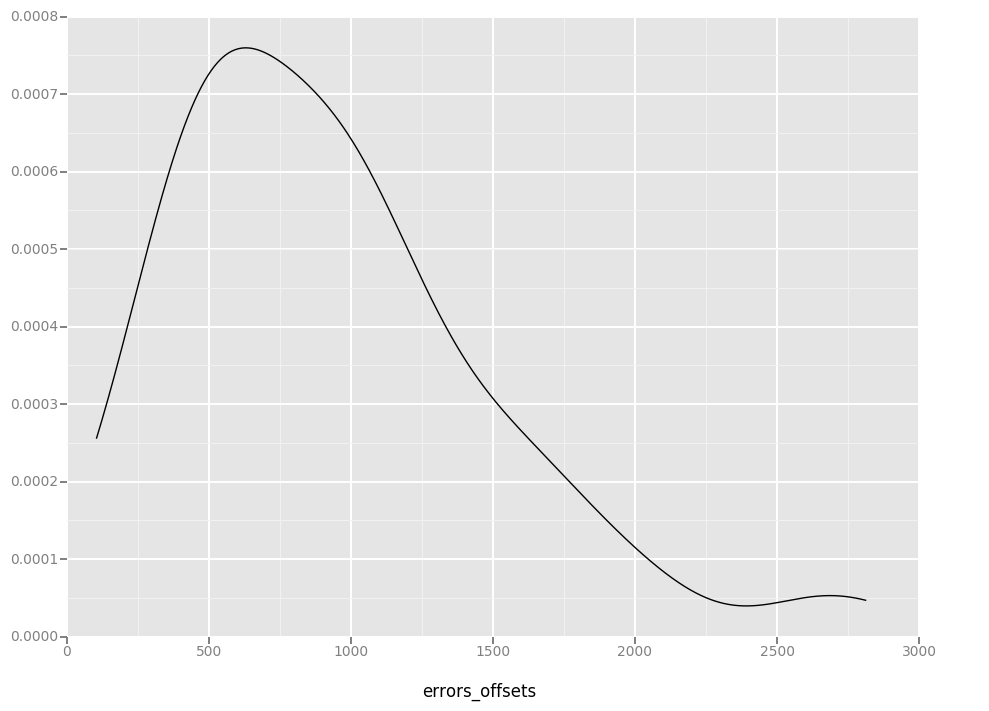

<ggplot: (324710053)>

In [1655]:
df = pd.DataFrame(errors_offsets)
ggplot(aes(x='errors_offsets'), data=df) + stat_density()

In [1592]:
errors_offsets = run_offsets(use_last_pos=True,m=100.)
print "Mean Error: %.3f" % np.mean(errors_offsets)
print "Median Error: %.3f" % np.median(errors_offsets)
print "Standard Deviation: %.3f" % np.std(errors_offsets)
print "Proportion of 3+ gateways: %.3f" % (len(errors_offsets)/170.0)
print "Number calculated: %d" % len(errors_offsets)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


Mean Error: 990.857
Median Error: 965.537
Standard Deviation: 548.169
Proportion of 3+ gateways: 0.276
Number calculated: 47


In [1602]:
errors_offsets = run_offsets(m=100., acc=1000)
print "Mean Error: %.3f" % np.mean(errors_offsets)
print "Median Error: %.3f" % np.median(errors_offsets)
print "Standard Deviation: %.3f" % np.std(errors_offsets)
print "Proportion of 3+ gateways: %.3f" % (len(errors_offsets)/170.0)
print "Number calculated: %d" % len(errors_offsets)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


Mean Error: 979.841
Median Error: 940.215
Standard Deviation: 543.000
Proportion of 3+ gateways: 0.588
Number calculated: 100


## Oversampling Oxotower

In [1666]:
## i=26520 -> data[495]
lat = 51.509
lon = -0.1084
realx, realy = convert_bng(lon, lat)
realx, realy = realx[0], realy[0]


def run_raw_oxo(reject=False, m=10., guess=False, offsets=False):
    
    errors = []
    results = []
    
    os = calculate_offsets(m=1.)

    for packet in data[495:]:
        if len(packet['gateways']) < 3:
            continue
            
        if offsets:
            D = TDOAs_mlat_Offsets(packet['gateways'], os, m=m)  
        else:
            D = TDOAs_mlat(packet['gateways'], reject=reject, m=m)
        
        if D is not False:
            
            xguess = None
            if len(results) > 2 and guess:
                avgx,avgy,stdx,stdy = average_results_oxo(results)
                xguess = [avgx,avgy]
            
            try:
                res = mlat(D, 20, guess=xguess)
            except:
                continue

            x = res[0]
            y = res[1]
            error = distance2D(x,y,realx,realy)
            errors.append(error)
            
            results.append(res)
            
            #plotTDOA(D,A,res)
    
    return errors, results

In [1604]:
def average_results_oxo(results, reject=False, m=10.):
    
    results = np.array(results)
    
    if reject:
        for i in [0,1]:
            remain = reject_outliers(results[:,i], m)
            if isinstance(remain, float):
                remain = [remain]
            todelete = []
            for j in range(len(results[:,i])):
                if results[j,i] not in remain:
                    todelete.append(j)
            results = numpy.delete(results, todelete, axis=0)    
    
    mean_x = np.mean(results[:,0])
    std_x = np.std(results[:,0])
    mean_y = np.mean(results[:,1])
    std_y = np.std(results[:,1])
    
    return mean_x, mean_y, std_x, std_y

In [1605]:
errs, res = run_raw_oxo()
print "Mean Error: %.3f" % np.mean(errs)
print "Standard Deviation: %.3f" % np.std(errs)
print "Number calculated: %d" % len(errs)
print ""
x,y,stdx,stdy = average_results_oxo(res)
error = distance2D(x,y,realx,realy)
print "Result: %.3f, %.3f" % (x,y)
print "Standard deviation: %.3f, %.3f" % (stdx,stdy)
print "Final Error: %.3f" % error

Mean Error: 1195.552
Standard Deviation: 838.491
Number calculated: 22

Result: 530925.828, 180740.732
Standard deviation: 474.386, 1299.724
Final Error: 466.997


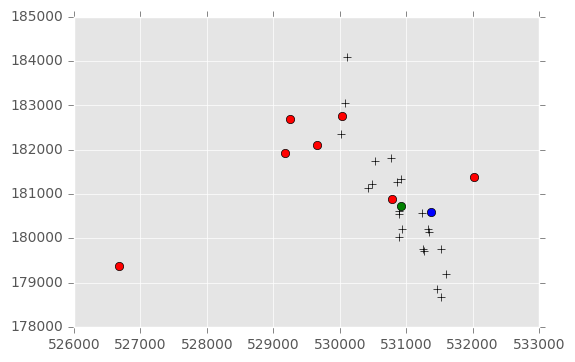

In [1613]:
r = np.array(res)
plt.plot(r[:,0], r[:,1], '+k')    

for gw in oxoGateways.values():
    plt.plot(gw['x'], gw['y'], 'or')
plt.plot(realx, realy, 'ob')
plt.plot(530925.828, 180740.732, 'og')
plt.show()

In [1667]:
errs, res = run_raw_oxo(reject=True, m=5.)
print "Mean Error: %.3f" % np.mean(errs)
print "Standard Deviation: %.3f" % np.std(errs)
print "Number calculated: %d" % len(errs)
print ""
x,y,stdx,stdy = average_results_oxo(res, reject=True, m=20.)
error = distance2D(x,y,realx,realy)
print "Result: %.3f, %.3f" % (x,y)
print "Standard deviation: %.3f, %.3f" % (stdx,stdy)
print "Final Error: %.3f" % error

Mean Error: 1197.685
Standard Deviation: 835.759
Number calculated: 49

Result: 531010.563, 180433.799
Standard deviation: 516.901, 1308.575
Final Error: 391.648


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


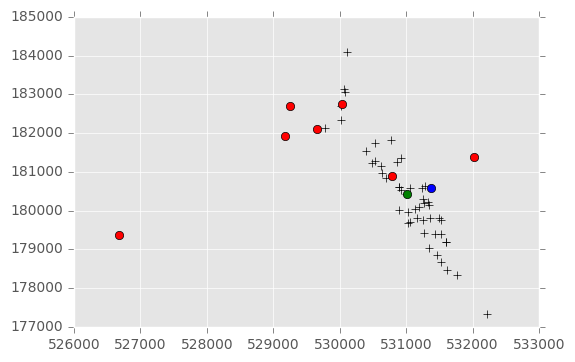

In [1668]:
r = np.array(res)
plt.plot(r[:,0], r[:,1], '+k')    

for gw in oxoGateways.values():
    plt.plot(gw['x'], gw['y'], 'or')
plt.plot(realx, realy, 'ob')
plt.plot(x, y, 'og')
plt.show()

In [1695]:
map_2 = folium.Map(location=[51.523668, -0.117931], tiles='Stamen Toner', zoom_start=12)

for gw in oxoGateways.values():
    gwlon, gwlat = convert_lonlat(gw['x'], gw['y'])
    folium.CircleMarker([gwlat[0], gwlon[0]],
                    radius=7,
                    color='#db3a00',
                    fill_color='#db3a00',
                    fill_opacity=1
                   ).add_to(map_2)       
    
for point in res:
    plon, plat = convert_lonlat(point[0], point[1])
    folium.CircleMarker([plat[0], plon[0]],
                    radius=2,
                    color='#d80be2',
                    fill_color='#d80be2',
                    fill_opacity=1
                   ).add_to(map_2)    
    

rlon, rlat = convert_lonlat(realx, realy)
folium.CircleMarker([rlat[0], rlon[0]],
                radius=7,
                color='#0059ff',
                fill_color='#0059ff',
                fill_opacity=1
               ).add_to(map_2) 

elon, elat = convert_lonlat(x, y)
folium.CircleMarker([elat[0], elon[0]],
                radius=7,
                color='#3bd100',
                fill_color='#3bd100',
                fill_opacity=1
               ).add_to(map_2) 
  
    
map_2

In [ ]:
labels = ['Chan, Raw Data']
means = [1112.44, ]
stds = []